In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import numpy as np
import phyloinfer as pinf
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from matplotlib.colors import LogNorm

In [4]:
from models import SBN
from utils import generate

In [ ]:
from collection

In [5]:
import pdb

In [6]:
taxa = list('ABCDEFGH')
all_tree = generate(taxa)

In [7]:
tree_space_cap = len(all_tree)

In [50]:
beta_v = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
K_v = [500, 1000, 2000, 4000, 8000]

reg_lam = 50.0
nrep = 10
kl_div_mat = np.empty((nrep,6,5,6))

for rep in range(nrep):
    output_ccd = '../results/simulation/ccd/rep' + '{:02d}'.format(rep)
    output_sbn = '../results/simulation/sbn-sa/rep' + '{:02d}'.format(rep)
#     output_sbn_alpha = '../results/simulation/sbn-sa-alpha/rep' + '{:02d}'.format(rep)
    output_sbn_em = '../results/simulation/sbn-em/rep' + '{:02d}'.format(rep)
    output_sbn_em_alpha = '../results/simulation/sbn-em-alpha/rep' + '{:02d}'.format(rep)
    output_sbn_em_alpha_train = '../results/simulation/sbn-em-alpha-train/rep' + '{:02d}'.format(rep)
    output_freq = '../results/simulation/freq/rep' + '{:02d}'.format(rep)
    output_n_unique_tree = '../results/simulation/n-tree/rep' +'{:02d}'.format(rep)
    
    kl_div_ccd = open(output_ccd, 'w')
    kl_div_sbn = open(output_sbn, 'w')
#     kl_div_sbn_alpha = open(output_sbn_alpha, 'w')
    kl_div_sbn_em = open(output_sbn_em, 'w')
    kl_div_sbn_em_alpha = open(output_sbn_em_alpha, 'w')
    kl_div_sbn_em_alpha_train = open(output_sbn_em_alpha_train, 'w')
    kl_div_freq = open(output_freq, 'w')
    n_unique_tree = open(output_n_unique_tree, 'w')
    
    kl_div_ccd.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
#     kl_div_sbn_alpha.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn_em.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn_em_alpha.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn_em_alpha_train.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_freq.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    n_unique_tree.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    
    kl_div_ccd.flush()
    kl_div_sbn.flush()
#     kl_div_sbn_alpha.flush()
    kl_div_sbn_em.flush()
    kl_div_sbn_em_alpha.flush()
    kl_div_sbn_em_alpha_train.flush()
    kl_div_freq.flush()
    n_unique_tree.flush()
    
    for l, beta in enumerate(beta_v):
        kl_div_ccd.write('{:.3f}'.format(beta))
        kl_div_sbn.write('{:.3f}'.format(beta))
#         kl_div_sbn_alpha.write('{:.3f}'.format(beta))
        kl_div_sbn_em.write('{:.3f}'.format(beta))
        kl_div_sbn_em_alpha.write('{:.3f}'.format(beta))
        kl_div_sbn_em_alpha_train.write('{:.3f}'.format(beta))
        kl_div_freq.write('{:.3f}'.format(beta))
        n_unique_tree.write('{:.3f}'.format(beta))
        
        for j, n_trees in enumerate(K_v):
            samp_freq = np.random.dirichlet(beta*np.ones(tree_space_cap))
            emp_tree_freq = {tree:samp_freq[i] for i, tree in enumerate(all_tree) if samp_freq[i]>1e-20}

            samp_trees = np.random.choice(all_tree, n_trees, p=samp_freq)
            unique_samp_trees, samp_counts = np.unique(samp_trees, return_counts=True)

            tree_id = {tree.get_topology_id():[tree] for tree in unique_samp_trees}
            tree_count_dict = {tree.get_topology_id():samp_counts[i] for i, tree in enumerate(unique_samp_trees)}

            model = SBN(taxa, emp_tree_freq)
            model.bn_train_count(tree_count_dict, tree_id)
            
            kl_div = model.kl_div()
            kl_div_mat[rep, l, j, 0], kl_div_mat[rep, l, j, 1] = kl_div['ccd'], kl_div['bn']
#             pdb.set_trace()
            kl_div_mat[rep, l, j, 5] = kl_div['freq']
            
#             model.alpha = 0.1
#             kl_div_mat[rep, l, j, 2] = model.kl_div(method='bn', MAP=True)['bn']

            logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=100, abstol=1e-05, monitor=True, MAP=False)
            kl_div_mat[rep, l, j, 2] = model.kl_div(method='bn')['bn']

            model = SBN(taxa, emp_tree_freq, alpha=reg_lam/n_trees)            
            logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=100, abstol=1e-05, monitor=True, MAP=True)
            kl_div_mat[rep, l, j, 3] = model.kl_div(method='bn', MAP=True)['bn']
            kl_div_mat[rep, l, j, 4] = model.kl_div(method='bn')['bn']

            kl_div_ccd.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 0]))
            kl_div_sbn.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 1]))
#             kl_div_sbn_alpha.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 2]))
            kl_div_sbn_em.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 2]))
            kl_div_sbn_em_alpha.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 3]))
            kl_div_sbn_em_alpha_train.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 4]))
            kl_div_freq.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 5]))
            n_unique_tree.write('\t'+str(len(samp_counts)).ljust(6))
            
            kl_div_ccd.flush()
            kl_div_sbn.flush()
#             kl_div_sbn_alpha.flush()
            kl_div_sbn_em.flush()
            kl_div_sbn_em_alpha.flush()
            kl_div_sbn_em_alpha_train.flush()
            kl_div_freq.flush()
            n_unique_tree.flush()
        
        kl_div_ccd.write('\n')
        kl_div_sbn.write('\n')
#         kl_div_sbn_alpha.write('\n')
        kl_div_sbn_em.write('\n')
        kl_div_sbn_em_alpha.write('\n')
        kl_div_sbn_em_alpha_train.write('\n')
        kl_div_freq.write('\n')
        n_unique_tree.write('\n')
        
    kl_div_ccd.close()
    kl_div_sbn.close()
#     kl_div_sbn_alpha.close()
    kl_div_sbn_em.close()
    kl_div_sbn_em_alpha.close()
    kl_div_sbn_em_alpha_train.close()
    kl_div_freq.close()
    n_unique_tree.close()
                                    

Iter: 1: current per tree log-likelihood -3.215915
Iter: 2: current per tree log-likelihood -3.195736
Iter: 3: current per tree log-likelihood -3.187826
Iter: 4: current per tree log-likelihood -3.184586
Iter: 5: current per tree log-likelihood -3.182349
Iter: 6: current per tree log-likelihood -3.180147
Iter: 7: current per tree log-likelihood -3.178101
Iter: 8: current per tree log-likelihood -3.174858
Iter: 9: current per tree log-likelihood -3.168849
Iter: 10: current per tree log-likelihood -3.158859
Iter: 11: current per tree log-likelihood -3.146938
Iter: 12: current per tree log-likelihood -3.134626
Iter: 13: current per tree log-likelihood -3.122097
Iter: 14: current per tree log-likelihood -3.113991
Iter: 15: current per tree log-likelihood -3.110651
Iter: 16: current per tree log-likelihood -3.109001
Iter: 17: current per tree log-likelihood -3.108336
Iter: 18: current per tree log-likelihood -3.108203
Iter: 19: current per tree log-likelihood -3.108198
Iter: 1: current per 

Iter: 29: current per tree log-likelihood -3.512380
Iter: 30: current per tree log-likelihood -3.512207
Iter: 31: current per tree log-likelihood -3.512036
Iter: 32: current per tree log-likelihood -3.511869
Iter: 33: current per tree log-likelihood -3.511705
Iter: 34: current per tree log-likelihood -3.511544
Iter: 35: current per tree log-likelihood -3.511387
Iter: 36: current per tree log-likelihood -3.511234
Iter: 37: current per tree log-likelihood -3.511086
Iter: 38: current per tree log-likelihood -3.510944
Iter: 39: current per tree log-likelihood -3.510809
Iter: 40: current per tree log-likelihood -3.510680
Iter: 41: current per tree log-likelihood -3.510557
Iter: 42: current per tree log-likelihood -3.510441
Iter: 43: current per tree log-likelihood -3.510330
Iter: 44: current per tree log-likelihood -3.510224
Iter: 45: current per tree log-likelihood -3.510121
Iter: 46: current per tree log-likelihood -3.510022
Iter: 47: current per tree log-likelihood -3.509924
Iter: 48: cu

Iter: 42: current per tree log-likelihood -2.779847
Iter: 43: current per tree log-likelihood -2.779768
Iter: 44: current per tree log-likelihood -2.779690
Iter: 45: current per tree log-likelihood -2.779612
Iter: 46: current per tree log-likelihood -2.779534
Iter: 47: current per tree log-likelihood -2.779456
Iter: 48: current per tree log-likelihood -2.779377
Iter: 49: current per tree log-likelihood -2.779299
Iter: 50: current per tree log-likelihood -2.779220
Iter: 51: current per tree log-likelihood -2.779141
Iter: 52: current per tree log-likelihood -2.779062
Iter: 53: current per tree log-likelihood -2.778983
Iter: 54: current per tree log-likelihood -2.778904
Iter: 55: current per tree log-likelihood -2.778825
Iter: 56: current per tree log-likelihood -2.778745
Iter: 57: current per tree log-likelihood -2.778665
Iter: 58: current per tree log-likelihood -2.778585
Iter: 59: current per tree log-likelihood -2.778504
Iter: 60: current per tree log-likelihood -2.778423
Iter: 61: cu

Iter: 82: current per tree log-likelihood -3.226723
Iter: 83: current per tree log-likelihood -3.226695
Iter: 84: current per tree log-likelihood -3.226666
Iter: 85: current per tree log-likelihood -3.226636
Iter: 86: current per tree log-likelihood -3.226606
Iter: 87: current per tree log-likelihood -3.226576
Iter: 88: current per tree log-likelihood -3.226545
Iter: 89: current per tree log-likelihood -3.226514
Iter: 90: current per tree log-likelihood -3.226483
Iter: 91: current per tree log-likelihood -3.226452
Iter: 92: current per tree log-likelihood -3.226424
Iter: 93: current per tree log-likelihood -3.226396
Iter: 94: current per tree log-likelihood -3.226370
Iter: 95: current per tree log-likelihood -3.226345
Iter: 96: current per tree log-likelihood -3.226320
Iter: 97: current per tree log-likelihood -3.226294
Iter: 98: current per tree log-likelihood -3.226269
Iter: 99: current per tree log-likelihood -3.226243
Iter: 100: current per tree log-likelihood -3.226218
Iter: 1: cu

Iter: 20: current per tree log-likelihood -3.422262
Iter: 21: current per tree log-likelihood -3.421349
Iter: 22: current per tree log-likelihood -3.420695
Iter: 23: current per tree log-likelihood -3.420510
Iter: 24: current per tree log-likelihood -3.420500
Iter: 1: current per tree log-likelihood -4.283672
Iter: 2: current per tree log-likelihood -4.259742
Iter: 3: current per tree log-likelihood -4.251640
Iter: 4: current per tree log-likelihood -4.247531
Iter: 5: current per tree log-likelihood -4.244499
Iter: 6: current per tree log-likelihood -4.241442
Iter: 7: current per tree log-likelihood -4.238015
Iter: 8: current per tree log-likelihood -4.234487
Iter: 9: current per tree log-likelihood -4.231614
Iter: 10: current per tree log-likelihood -4.229394
Iter: 11: current per tree log-likelihood -4.227690
Iter: 12: current per tree log-likelihood -4.226415
Iter: 13: current per tree log-likelihood -4.225377
Iter: 14: current per tree log-likelihood -4.224459
Iter: 15: current per

Iter: 28: current per tree log-likelihood -4.037100
Iter: 29: current per tree log-likelihood -4.036857
Iter: 30: current per tree log-likelihood -4.036616
Iter: 31: current per tree log-likelihood -4.036379
Iter: 32: current per tree log-likelihood -4.036144
Iter: 33: current per tree log-likelihood -4.035913
Iter: 34: current per tree log-likelihood -4.035685
Iter: 35: current per tree log-likelihood -4.035463
Iter: 36: current per tree log-likelihood -4.035246
Iter: 37: current per tree log-likelihood -4.035036
Iter: 38: current per tree log-likelihood -4.034832
Iter: 39: current per tree log-likelihood -4.034637
Iter: 40: current per tree log-likelihood -4.034448
Iter: 41: current per tree log-likelihood -4.034266
Iter: 42: current per tree log-likelihood -4.034090
Iter: 43: current per tree log-likelihood -4.033920
Iter: 44: current per tree log-likelihood -4.033755
Iter: 45: current per tree log-likelihood -4.033595
Iter: 46: current per tree log-likelihood -4.033439
Iter: 47: cu

Iter: 62: current per tree log-likelihood -3.484112
Iter: 63: current per tree log-likelihood -3.484024
Iter: 64: current per tree log-likelihood -3.483936
Iter: 65: current per tree log-likelihood -3.483847
Iter: 66: current per tree log-likelihood -3.483759
Iter: 67: current per tree log-likelihood -3.483670
Iter: 68: current per tree log-likelihood -3.483581
Iter: 69: current per tree log-likelihood -3.483493
Iter: 70: current per tree log-likelihood -3.483406
Iter: 71: current per tree log-likelihood -3.483319
Iter: 72: current per tree log-likelihood -3.483232
Iter: 73: current per tree log-likelihood -3.483146
Iter: 74: current per tree log-likelihood -3.483061
Iter: 75: current per tree log-likelihood -3.482976
Iter: 76: current per tree log-likelihood -3.482891
Iter: 77: current per tree log-likelihood -3.482807
Iter: 78: current per tree log-likelihood -3.482723
Iter: 79: current per tree log-likelihood -3.482640
Iter: 80: current per tree log-likelihood -3.482556
Iter: 81: cu

Iter: 96: current per tree log-likelihood -3.831368
Iter: 97: current per tree log-likelihood -3.831341
Iter: 98: current per tree log-likelihood -3.831313
Iter: 99: current per tree log-likelihood -3.831285
Iter: 100: current per tree log-likelihood -3.831258
Iter: 1: current per tree log-likelihood -3.331638
Iter: 2: current per tree log-likelihood -3.302001
Iter: 3: current per tree log-likelihood -3.291682
Iter: 4: current per tree log-likelihood -3.284277
Iter: 5: current per tree log-likelihood -3.271626
Iter: 6: current per tree log-likelihood -3.250319
Iter: 7: current per tree log-likelihood -3.225304
Iter: 8: current per tree log-likelihood -3.208736
Iter: 9: current per tree log-likelihood -3.202235
Iter: 10: current per tree log-likelihood -3.199936
Iter: 11: current per tree log-likelihood -3.198875
Iter: 12: current per tree log-likelihood -3.198343
Iter: 13: current per tree log-likelihood -3.198145
Iter: 14: current per tree log-likelihood -3.198040
Iter: 15: current pe

Iter: 20: current per tree log-likelihood -3.818615
Iter: 21: current per tree log-likelihood -3.818482
Iter: 22: current per tree log-likelihood -3.818477
Iter: 1: current per tree log-likelihood -4.792946
Iter: 2: current per tree log-likelihood -4.764978
Iter: 3: current per tree log-likelihood -4.755836
Iter: 4: current per tree log-likelihood -4.749542
Iter: 5: current per tree log-likelihood -4.741613
Iter: 6: current per tree log-likelihood -4.731790
Iter: 7: current per tree log-likelihood -4.719605
Iter: 8: current per tree log-likelihood -4.706351
Iter: 9: current per tree log-likelihood -4.697066
Iter: 10: current per tree log-likelihood -4.690493
Iter: 11: current per tree log-likelihood -4.684490
Iter: 12: current per tree log-likelihood -4.679444
Iter: 13: current per tree log-likelihood -4.675629
Iter: 14: current per tree log-likelihood -4.672974
Iter: 15: current per tree log-likelihood -4.671160
Iter: 16: current per tree log-likelihood -4.669936
Iter: 17: current per

Iter: 37: current per tree log-likelihood -4.849349
Iter: 38: current per tree log-likelihood -4.849153
Iter: 39: current per tree log-likelihood -4.848963
Iter: 40: current per tree log-likelihood -4.848779
Iter: 41: current per tree log-likelihood -4.848600
Iter: 42: current per tree log-likelihood -4.848426
Iter: 43: current per tree log-likelihood -4.848257
Iter: 44: current per tree log-likelihood -4.848092
Iter: 45: current per tree log-likelihood -4.847931
Iter: 46: current per tree log-likelihood -4.847775
Iter: 47: current per tree log-likelihood -4.847624
Iter: 48: current per tree log-likelihood -4.847477
Iter: 49: current per tree log-likelihood -4.847335
Iter: 50: current per tree log-likelihood -4.847197
Iter: 51: current per tree log-likelihood -4.847064
Iter: 52: current per tree log-likelihood -4.846935
Iter: 53: current per tree log-likelihood -4.846810
Iter: 54: current per tree log-likelihood -4.846688
Iter: 55: current per tree log-likelihood -4.846571
Iter: 56: cu

Iter: 60: current per tree log-likelihood -4.783776
Iter: 61: current per tree log-likelihood -4.783676
Iter: 62: current per tree log-likelihood -4.783576
Iter: 63: current per tree log-likelihood -4.783478
Iter: 64: current per tree log-likelihood -4.783379
Iter: 65: current per tree log-likelihood -4.783280
Iter: 66: current per tree log-likelihood -4.783181
Iter: 67: current per tree log-likelihood -4.783082
Iter: 68: current per tree log-likelihood -4.782982
Iter: 69: current per tree log-likelihood -4.782881
Iter: 70: current per tree log-likelihood -4.782780
Iter: 71: current per tree log-likelihood -4.782680
Iter: 72: current per tree log-likelihood -4.782580
Iter: 73: current per tree log-likelihood -4.782484
Iter: 74: current per tree log-likelihood -4.782391
Iter: 75: current per tree log-likelihood -4.782300
Iter: 76: current per tree log-likelihood -4.782210
Iter: 77: current per tree log-likelihood -4.782121
Iter: 78: current per tree log-likelihood -4.782034
Iter: 79: cu

Iter: 66: current per tree log-likelihood -4.512813
Iter: 67: current per tree log-likelihood -4.512777
Iter: 68: current per tree log-likelihood -4.512742
Iter: 69: current per tree log-likelihood -4.512707
Iter: 70: current per tree log-likelihood -4.512672
Iter: 71: current per tree log-likelihood -4.512638
Iter: 72: current per tree log-likelihood -4.512604
Iter: 73: current per tree log-likelihood -4.512570
Iter: 74: current per tree log-likelihood -4.512537
Iter: 75: current per tree log-likelihood -4.512504
Iter: 76: current per tree log-likelihood -4.512471
Iter: 77: current per tree log-likelihood -4.512437
Iter: 78: current per tree log-likelihood -4.512404
Iter: 79: current per tree log-likelihood -4.512371
Iter: 80: current per tree log-likelihood -4.512337
Iter: 81: current per tree log-likelihood -4.512304
Iter: 82: current per tree log-likelihood -4.512270
Iter: 83: current per tree log-likelihood -4.512237
Iter: 84: current per tree log-likelihood -4.512203
Iter: 85: cu

Iter: 88: current per tree log-likelihood -4.113491
Iter: 89: current per tree log-likelihood -4.113481
Iter: 1: current per tree log-likelihood -4.873475
Iter: 2: current per tree log-likelihood -4.825855
Iter: 3: current per tree log-likelihood -4.806931
Iter: 4: current per tree log-likelihood -4.795773
Iter: 5: current per tree log-likelihood -4.782911
Iter: 6: current per tree log-likelihood -4.761927
Iter: 7: current per tree log-likelihood -4.735343
Iter: 8: current per tree log-likelihood -4.715151
Iter: 9: current per tree log-likelihood -4.704390
Iter: 10: current per tree log-likelihood -4.698469
Iter: 11: current per tree log-likelihood -4.694635
Iter: 12: current per tree log-likelihood -4.691740
Iter: 13: current per tree log-likelihood -4.689430
Iter: 14: current per tree log-likelihood -4.688101
Iter: 15: current per tree log-likelihood -4.687776
Iter: 16: current per tree log-likelihood -4.687749
Iter: 17: current per tree log-likelihood -4.687745
Iter: 1: current per 

Iter: 40: current per tree log-likelihood -5.256831
Iter: 41: current per tree log-likelihood -5.256560
Iter: 42: current per tree log-likelihood -5.256318
Iter: 43: current per tree log-likelihood -5.256090
Iter: 44: current per tree log-likelihood -5.255872
Iter: 45: current per tree log-likelihood -5.255661
Iter: 46: current per tree log-likelihood -5.255459
Iter: 47: current per tree log-likelihood -5.255263
Iter: 48: current per tree log-likelihood -5.255075
Iter: 49: current per tree log-likelihood -5.254895
Iter: 50: current per tree log-likelihood -5.254721
Iter: 51: current per tree log-likelihood -5.254555
Iter: 52: current per tree log-likelihood -5.254395
Iter: 53: current per tree log-likelihood -5.254242
Iter: 54: current per tree log-likelihood -5.254095
Iter: 55: current per tree log-likelihood -5.253953
Iter: 56: current per tree log-likelihood -5.253818
Iter: 57: current per tree log-likelihood -5.253688
Iter: 58: current per tree log-likelihood -5.253564
Iter: 59: cu

Iter: 50: current per tree log-likelihood -5.217626
Iter: 51: current per tree log-likelihood -5.217515
Iter: 52: current per tree log-likelihood -5.217405
Iter: 53: current per tree log-likelihood -5.217297
Iter: 54: current per tree log-likelihood -5.217190
Iter: 55: current per tree log-likelihood -5.217085
Iter: 56: current per tree log-likelihood -5.216981
Iter: 57: current per tree log-likelihood -5.216878
Iter: 58: current per tree log-likelihood -5.216777
Iter: 59: current per tree log-likelihood -5.216677
Iter: 60: current per tree log-likelihood -5.216578
Iter: 61: current per tree log-likelihood -5.216481
Iter: 62: current per tree log-likelihood -5.216384
Iter: 63: current per tree log-likelihood -5.216289
Iter: 64: current per tree log-likelihood -5.216195
Iter: 65: current per tree log-likelihood -5.216101
Iter: 66: current per tree log-likelihood -5.216009
Iter: 67: current per tree log-likelihood -5.215917
Iter: 68: current per tree log-likelihood -5.215826
Iter: 69: cu

Iter: 49: current per tree log-likelihood -5.100120
Iter: 50: current per tree log-likelihood -5.100060
Iter: 51: current per tree log-likelihood -5.100000
Iter: 52: current per tree log-likelihood -5.099938
Iter: 53: current per tree log-likelihood -5.099876
Iter: 54: current per tree log-likelihood -5.099814
Iter: 55: current per tree log-likelihood -5.099750
Iter: 56: current per tree log-likelihood -5.099684
Iter: 57: current per tree log-likelihood -5.099618
Iter: 58: current per tree log-likelihood -5.099550
Iter: 59: current per tree log-likelihood -5.099482
Iter: 60: current per tree log-likelihood -5.099413
Iter: 61: current per tree log-likelihood -5.099342
Iter: 62: current per tree log-likelihood -5.099268
Iter: 63: current per tree log-likelihood -5.099191
Iter: 64: current per tree log-likelihood -5.099110
Iter: 65: current per tree log-likelihood -5.099023
Iter: 66: current per tree log-likelihood -5.098929
Iter: 67: current per tree log-likelihood -5.098828
Iter: 68: cu

Iter: 44: current per tree log-likelihood -4.865710
Iter: 45: current per tree log-likelihood -4.865566
Iter: 46: current per tree log-likelihood -4.865424
Iter: 47: current per tree log-likelihood -4.865302
Iter: 48: current per tree log-likelihood -4.865188
Iter: 49: current per tree log-likelihood -4.865061
Iter: 50: current per tree log-likelihood -4.864905
Iter: 51: current per tree log-likelihood -4.864711
Iter: 52: current per tree log-likelihood -4.864461
Iter: 53: current per tree log-likelihood -4.864143
Iter: 54: current per tree log-likelihood -4.863767
Iter: 55: current per tree log-likelihood -4.863419
Iter: 56: current per tree log-likelihood -4.863202
Iter: 57: current per tree log-likelihood -4.863105
Iter: 58: current per tree log-likelihood -4.863065
Iter: 59: current per tree log-likelihood -4.863030
Iter: 60: current per tree log-likelihood -4.862998
Iter: 61: current per tree log-likelihood -4.862971
Iter: 62: current per tree log-likelihood -4.862950
Iter: 63: cu

Iter: 77: current per tree log-likelihood -6.122521
Iter: 78: current per tree log-likelihood -6.122506
Iter: 79: current per tree log-likelihood -6.122491
Iter: 80: current per tree log-likelihood -6.122476
Iter: 81: current per tree log-likelihood -6.122462
Iter: 82: current per tree log-likelihood -6.122448
Iter: 83: current per tree log-likelihood -6.122435
Iter: 84: current per tree log-likelihood -6.122422
Iter: 85: current per tree log-likelihood -6.122410
Iter: 86: current per tree log-likelihood -6.122398
Iter: 87: current per tree log-likelihood -6.122386
Iter: 88: current per tree log-likelihood -6.122375
Iter: 89: current per tree log-likelihood -6.122364
Iter: 90: current per tree log-likelihood -6.122353
Iter: 91: current per tree log-likelihood -6.122342
Iter: 92: current per tree log-likelihood -6.122332
Iter: 93: current per tree log-likelihood -6.122322
Iter: 1: current per tree log-likelihood -5.741551
Iter: 2: current per tree log-likelihood -5.694345
Iter: 3: curre

Iter: 100: current per tree log-likelihood -5.804618
Iter: 1: current per tree log-likelihood -5.936602
Iter: 2: current per tree log-likelihood -5.888884
Iter: 3: current per tree log-likelihood -5.868007
Iter: 4: current per tree log-likelihood -5.845324
Iter: 5: current per tree log-likelihood -5.803304
Iter: 6: current per tree log-likelihood -5.737736
Iter: 7: current per tree log-likelihood -5.663218
Iter: 8: current per tree log-likelihood -5.599169
Iter: 9: current per tree log-likelihood -5.554296
Iter: 10: current per tree log-likelihood -5.526577
Iter: 11: current per tree log-likelihood -5.511024
Iter: 12: current per tree log-likelihood -5.500423
Iter: 13: current per tree log-likelihood -5.492946
Iter: 14: current per tree log-likelihood -5.488028
Iter: 15: current per tree log-likelihood -5.483903
Iter: 16: current per tree log-likelihood -5.480420
Iter: 17: current per tree log-likelihood -5.478093
Iter: 18: current per tree log-likelihood -5.476577
Iter: 19: current pe

Iter: 89: current per tree log-likelihood -5.746766
Iter: 90: current per tree log-likelihood -5.746695
Iter: 91: current per tree log-likelihood -5.746625
Iter: 92: current per tree log-likelihood -5.746556
Iter: 93: current per tree log-likelihood -5.746488
Iter: 94: current per tree log-likelihood -5.746421
Iter: 95: current per tree log-likelihood -5.746354
Iter: 96: current per tree log-likelihood -5.746289
Iter: 97: current per tree log-likelihood -5.746224
Iter: 98: current per tree log-likelihood -5.746161
Iter: 99: current per tree log-likelihood -5.746098
Iter: 100: current per tree log-likelihood -5.746036
Iter: 1: current per tree log-likelihood -6.126504
Iter: 2: current per tree log-likelihood -6.079885
Iter: 3: current per tree log-likelihood -6.057086
Iter: 4: current per tree log-likelihood -6.029943
Iter: 5: current per tree log-likelihood -5.979629
Iter: 6: current per tree log-likelihood -5.908005
Iter: 7: current per tree log-likelihood -5.846285
Iter: 8: current p

Iter: 74: current per tree log-likelihood -5.801460
Iter: 75: current per tree log-likelihood -5.801414
Iter: 76: current per tree log-likelihood -5.801368
Iter: 77: current per tree log-likelihood -5.801324
Iter: 78: current per tree log-likelihood -5.801280
Iter: 79: current per tree log-likelihood -5.801237
Iter: 80: current per tree log-likelihood -5.801195
Iter: 81: current per tree log-likelihood -5.801155
Iter: 82: current per tree log-likelihood -5.801115
Iter: 83: current per tree log-likelihood -5.801075
Iter: 84: current per tree log-likelihood -5.801036
Iter: 85: current per tree log-likelihood -5.800998
Iter: 86: current per tree log-likelihood -5.800960
Iter: 87: current per tree log-likelihood -5.800922
Iter: 88: current per tree log-likelihood -5.800885
Iter: 89: current per tree log-likelihood -5.800849
Iter: 90: current per tree log-likelihood -5.800813
Iter: 91: current per tree log-likelihood -5.800778
Iter: 92: current per tree log-likelihood -5.800742
Iter: 93: cu

Iter: 47: current per tree log-likelihood -5.745953
Iter: 48: current per tree log-likelihood -5.745764
Iter: 49: current per tree log-likelihood -5.745568
Iter: 50: current per tree log-likelihood -5.745368
Iter: 51: current per tree log-likelihood -5.745157
Iter: 52: current per tree log-likelihood -5.744940
Iter: 53: current per tree log-likelihood -5.744729
Iter: 54: current per tree log-likelihood -5.744518
Iter: 55: current per tree log-likelihood -5.744331
Iter: 56: current per tree log-likelihood -5.744183
Iter: 57: current per tree log-likelihood -5.744037
Iter: 58: current per tree log-likelihood -5.743888
Iter: 59: current per tree log-likelihood -5.743748
Iter: 60: current per tree log-likelihood -5.743610
Iter: 61: current per tree log-likelihood -5.743474
Iter: 62: current per tree log-likelihood -5.743373
Iter: 63: current per tree log-likelihood -5.743319
Iter: 64: current per tree log-likelihood -5.743276
Iter: 65: current per tree log-likelihood -5.743231
Iter: 66: cu

Iter: 12: current per tree log-likelihood -5.871422
Iter: 13: current per tree log-likelihood -5.867491
Iter: 14: current per tree log-likelihood -5.865154
Iter: 15: current per tree log-likelihood -5.863682
Iter: 16: current per tree log-likelihood -5.862428
Iter: 17: current per tree log-likelihood -5.861084
Iter: 18: current per tree log-likelihood -5.859695
Iter: 19: current per tree log-likelihood -5.858536
Iter: 20: current per tree log-likelihood -5.857829
Iter: 21: current per tree log-likelihood -5.857377
Iter: 22: current per tree log-likelihood -5.856958
Iter: 23: current per tree log-likelihood -5.856501
Iter: 24: current per tree log-likelihood -5.855991
Iter: 25: current per tree log-likelihood -5.855513
Iter: 26: current per tree log-likelihood -5.855247
Iter: 27: current per tree log-likelihood -5.855182
Iter: 28: current per tree log-likelihood -5.855160
Iter: 29: current per tree log-likelihood -5.855145
Iter: 30: current per tree log-likelihood -5.855134
Iter: 31: cu

Iter: 39: current per tree log-likelihood -6.049200
Iter: 40: current per tree log-likelihood -6.049002
Iter: 41: current per tree log-likelihood -6.048767
Iter: 42: current per tree log-likelihood -6.048506
Iter: 43: current per tree log-likelihood -6.048269
Iter: 44: current per tree log-likelihood -6.048114
Iter: 45: current per tree log-likelihood -6.048009
Iter: 46: current per tree log-likelihood -6.047899
Iter: 47: current per tree log-likelihood -6.047768
Iter: 48: current per tree log-likelihood -6.047606
Iter: 49: current per tree log-likelihood -6.047405
Iter: 50: current per tree log-likelihood -6.047176
Iter: 51: current per tree log-likelihood -6.046986
Iter: 52: current per tree log-likelihood -6.046912
Iter: 53: current per tree log-likelihood -6.046905
Iter: 1: current per tree log-likelihood -6.890394
Iter: 2: current per tree log-likelihood -6.849952
Iter: 3: current per tree log-likelihood -6.829949
Iter: 4: current per tree log-likelihood -6.801338
Iter: 5: current

Iter: 44: current per tree log-likelihood -6.119551
Iter: 45: current per tree log-likelihood -6.119360
Iter: 46: current per tree log-likelihood -6.119153
Iter: 47: current per tree log-likelihood -6.118917
Iter: 48: current per tree log-likelihood -6.118678
Iter: 49: current per tree log-likelihood -6.118482
Iter: 50: current per tree log-likelihood -6.118339
Iter: 51: current per tree log-likelihood -6.118255
Iter: 52: current per tree log-likelihood -6.118207
Iter: 53: current per tree log-likelihood -6.118161
Iter: 54: current per tree log-likelihood -6.118113
Iter: 55: current per tree log-likelihood -6.118062
Iter: 56: current per tree log-likelihood -6.118007
Iter: 57: current per tree log-likelihood -6.117951
Iter: 58: current per tree log-likelihood -6.117892
Iter: 59: current per tree log-likelihood -6.117834
Iter: 60: current per tree log-likelihood -6.117778
Iter: 61: current per tree log-likelihood -6.117726
Iter: 62: current per tree log-likelihood -6.117676
Iter: 63: cu

Iter: 29: current per tree log-likelihood -6.293618
Iter: 30: current per tree log-likelihood -6.292861
Iter: 31: current per tree log-likelihood -6.291966
Iter: 32: current per tree log-likelihood -6.291064
Iter: 33: current per tree log-likelihood -6.290344
Iter: 34: current per tree log-likelihood -6.289742
Iter: 35: current per tree log-likelihood -6.289185
Iter: 36: current per tree log-likelihood -6.288658
Iter: 37: current per tree log-likelihood -6.288201
Iter: 38: current per tree log-likelihood -6.287816
Iter: 39: current per tree log-likelihood -6.287440
Iter: 40: current per tree log-likelihood -6.287055
Iter: 41: current per tree log-likelihood -6.286689
Iter: 42: current per tree log-likelihood -6.286375
Iter: 43: current per tree log-likelihood -6.286087
Iter: 44: current per tree log-likelihood -6.285776
Iter: 45: current per tree log-likelihood -6.285462
Iter: 46: current per tree log-likelihood -6.285227
Iter: 47: current per tree log-likelihood -6.285066
Iter: 48: cu

Iter: 94: current per tree log-likelihood -6.364922
Iter: 95: current per tree log-likelihood -6.364902
Iter: 96: current per tree log-likelihood -6.364882
Iter: 97: current per tree log-likelihood -6.364862
Iter: 98: current per tree log-likelihood -6.364842
Iter: 99: current per tree log-likelihood -6.364823
Iter: 100: current per tree log-likelihood -6.364804
Iter: 1: current per tree log-likelihood -2.965503
Iter: 2: current per tree log-likelihood -2.946602
Iter: 3: current per tree log-likelihood -2.939247
Iter: 4: current per tree log-likelihood -2.935856
Iter: 5: current per tree log-likelihood -2.932137
Iter: 6: current per tree log-likelihood -2.926531
Iter: 7: current per tree log-likelihood -2.921782
Iter: 8: current per tree log-likelihood -2.918627
Iter: 9: current per tree log-likelihood -2.916292
Iter: 10: current per tree log-likelihood -2.915354
Iter: 11: current per tree log-likelihood -2.915263
Iter: 12: current per tree log-likelihood -2.915262
Iter: 1: current per

Iter: 49: current per tree log-likelihood -3.088458
Iter: 50: current per tree log-likelihood -3.088229
Iter: 51: current per tree log-likelihood -3.088014
Iter: 52: current per tree log-likelihood -3.087811
Iter: 53: current per tree log-likelihood -3.087621
Iter: 54: current per tree log-likelihood -3.087443
Iter: 55: current per tree log-likelihood -3.087275
Iter: 56: current per tree log-likelihood -3.087116
Iter: 57: current per tree log-likelihood -3.086966
Iter: 58: current per tree log-likelihood -3.086824
Iter: 59: current per tree log-likelihood -3.086689
Iter: 60: current per tree log-likelihood -3.086561
Iter: 61: current per tree log-likelihood -3.086439
Iter: 62: current per tree log-likelihood -3.086323
Iter: 63: current per tree log-likelihood -3.086214
Iter: 64: current per tree log-likelihood -3.086112
Iter: 65: current per tree log-likelihood -3.086015
Iter: 66: current per tree log-likelihood -3.085925
Iter: 67: current per tree log-likelihood -3.085840
Iter: 68: cu

Iter: 96: current per tree log-likelihood -3.103584
Iter: 97: current per tree log-likelihood -3.103541
Iter: 98: current per tree log-likelihood -3.103501
Iter: 99: current per tree log-likelihood -3.103462
Iter: 100: current per tree log-likelihood -3.103424
Iter: 1: current per tree log-likelihood -2.827974
Iter: 2: current per tree log-likelihood -2.808598
Iter: 3: current per tree log-likelihood -2.801977
Iter: 4: current per tree log-likelihood -2.799960
Iter: 5: current per tree log-likelihood -2.799524
Iter: 6: current per tree log-likelihood -2.799147
Iter: 7: current per tree log-likelihood -2.798354
Iter: 8: current per tree log-likelihood -2.797396
Iter: 9: current per tree log-likelihood -2.796772
Iter: 10: current per tree log-likelihood -2.796480
Iter: 11: current per tree log-likelihood -2.796348
Iter: 12: current per tree log-likelihood -2.796201
Iter: 13: current per tree log-likelihood -2.795989
Iter: 14: current per tree log-likelihood -2.795787
Iter: 15: current pe

Iter: 22: current per tree log-likelihood -3.057764
Iter: 23: current per tree log-likelihood -3.057737
Iter: 24: current per tree log-likelihood -3.057706
Iter: 25: current per tree log-likelihood -3.057668
Iter: 26: current per tree log-likelihood -3.057621
Iter: 27: current per tree log-likelihood -3.057565
Iter: 28: current per tree log-likelihood -3.057507
Iter: 29: current per tree log-likelihood -3.057470
Iter: 30: current per tree log-likelihood -3.057461
Iter: 1: current per tree log-likelihood -3.230094
Iter: 2: current per tree log-likelihood -3.194848
Iter: 3: current per tree log-likelihood -3.182630
Iter: 4: current per tree log-likelihood -3.177830
Iter: 5: current per tree log-likelihood -3.174557
Iter: 6: current per tree log-likelihood -3.166994
Iter: 7: current per tree log-likelihood -3.148645
Iter: 8: current per tree log-likelihood -3.130383
Iter: 9: current per tree log-likelihood -3.125043
Iter: 10: current per tree log-likelihood -3.123457
Iter: 11: current per

Iter: 70: current per tree log-likelihood -4.244672
Iter: 71: current per tree log-likelihood -4.244648
Iter: 72: current per tree log-likelihood -4.244626
Iter: 73: current per tree log-likelihood -4.244604
Iter: 74: current per tree log-likelihood -4.244583
Iter: 75: current per tree log-likelihood -4.244563
Iter: 76: current per tree log-likelihood -4.244544
Iter: 77: current per tree log-likelihood -4.244525
Iter: 78: current per tree log-likelihood -4.244507
Iter: 79: current per tree log-likelihood -4.244489
Iter: 80: current per tree log-likelihood -4.244472
Iter: 81: current per tree log-likelihood -4.244456
Iter: 82: current per tree log-likelihood -4.244440
Iter: 83: current per tree log-likelihood -4.244425
Iter: 84: current per tree log-likelihood -4.244410
Iter: 85: current per tree log-likelihood -4.244396
Iter: 86: current per tree log-likelihood -4.244382
Iter: 87: current per tree log-likelihood -4.244369
Iter: 88: current per tree log-likelihood -4.244356
Iter: 89: cu

Iter: 99: current per tree log-likelihood -3.812314
Iter: 100: current per tree log-likelihood -3.812296
Iter: 1: current per tree log-likelihood -3.845052
Iter: 2: current per tree log-likelihood -3.810856
Iter: 3: current per tree log-likelihood -3.801232
Iter: 4: current per tree log-likelihood -3.798070
Iter: 5: current per tree log-likelihood -3.795416
Iter: 6: current per tree log-likelihood -3.792356
Iter: 7: current per tree log-likelihood -3.787267
Iter: 8: current per tree log-likelihood -3.777601
Iter: 9: current per tree log-likelihood -3.766429
Iter: 10: current per tree log-likelihood -3.759506
Iter: 11: current per tree log-likelihood -3.756213
Iter: 12: current per tree log-likelihood -3.753952
Iter: 13: current per tree log-likelihood -3.752529
Iter: 14: current per tree log-likelihood -3.751747
Iter: 15: current per tree log-likelihood -3.751102
Iter: 16: current per tree log-likelihood -3.750644
Iter: 17: current per tree log-likelihood -3.750288
Iter: 18: current pe

Iter: 24: current per tree log-likelihood -3.547534
Iter: 25: current per tree log-likelihood -3.547500
Iter: 26: current per tree log-likelihood -3.547473
Iter: 27: current per tree log-likelihood -3.547450
Iter: 28: current per tree log-likelihood -3.547431
Iter: 29: current per tree log-likelihood -3.547415
Iter: 30: current per tree log-likelihood -3.547402
Iter: 31: current per tree log-likelihood -3.547391
Iter: 32: current per tree log-likelihood -3.547381
Iter: 1: current per tree log-likelihood -3.793318
Iter: 2: current per tree log-likelihood -3.770795
Iter: 3: current per tree log-likelihood -3.763927
Iter: 4: current per tree log-likelihood -3.760766
Iter: 5: current per tree log-likelihood -3.755157
Iter: 6: current per tree log-likelihood -3.744343
Iter: 7: current per tree log-likelihood -3.732406
Iter: 8: current per tree log-likelihood -3.717283
Iter: 9: current per tree log-likelihood -3.696176
Iter: 10: current per tree log-likelihood -3.680186
Iter: 11: current per

Iter: 25: current per tree log-likelihood -5.074308
Iter: 26: current per tree log-likelihood -5.073926
Iter: 27: current per tree log-likelihood -5.073565
Iter: 28: current per tree log-likelihood -5.073224
Iter: 29: current per tree log-likelihood -5.072903
Iter: 30: current per tree log-likelihood -5.072602
Iter: 31: current per tree log-likelihood -5.072320
Iter: 32: current per tree log-likelihood -5.072058
Iter: 33: current per tree log-likelihood -5.071816
Iter: 34: current per tree log-likelihood -5.071594
Iter: 35: current per tree log-likelihood -5.071392
Iter: 36: current per tree log-likelihood -5.071209
Iter: 37: current per tree log-likelihood -5.071045
Iter: 38: current per tree log-likelihood -5.070897
Iter: 39: current per tree log-likelihood -5.070765
Iter: 40: current per tree log-likelihood -5.070645
Iter: 41: current per tree log-likelihood -5.070538
Iter: 42: current per tree log-likelihood -5.070441
Iter: 43: current per tree log-likelihood -5.070354
Iter: 44: cu

Iter: 56: current per tree log-likelihood -4.623106
Iter: 57: current per tree log-likelihood -4.622937
Iter: 58: current per tree log-likelihood -4.622774
Iter: 59: current per tree log-likelihood -4.622615
Iter: 60: current per tree log-likelihood -4.622461
Iter: 61: current per tree log-likelihood -4.622311
Iter: 62: current per tree log-likelihood -4.622165
Iter: 63: current per tree log-likelihood -4.622023
Iter: 64: current per tree log-likelihood -4.621887
Iter: 65: current per tree log-likelihood -4.621758
Iter: 66: current per tree log-likelihood -4.621636
Iter: 67: current per tree log-likelihood -4.621522
Iter: 68: current per tree log-likelihood -4.621417
Iter: 69: current per tree log-likelihood -4.621320
Iter: 70: current per tree log-likelihood -4.621229
Iter: 71: current per tree log-likelihood -4.621142
Iter: 72: current per tree log-likelihood -4.621060
Iter: 73: current per tree log-likelihood -4.620981
Iter: 74: current per tree log-likelihood -4.620906
Iter: 75: cu

Iter: 84: current per tree log-likelihood -4.535253
Iter: 85: current per tree log-likelihood -4.535177
Iter: 86: current per tree log-likelihood -4.535102
Iter: 87: current per tree log-likelihood -4.535028
Iter: 88: current per tree log-likelihood -4.534956
Iter: 89: current per tree log-likelihood -4.534885
Iter: 90: current per tree log-likelihood -4.534815
Iter: 91: current per tree log-likelihood -4.534745
Iter: 92: current per tree log-likelihood -4.534676
Iter: 93: current per tree log-likelihood -4.534607
Iter: 94: current per tree log-likelihood -4.534538
Iter: 95: current per tree log-likelihood -4.534469
Iter: 96: current per tree log-likelihood -4.534400
Iter: 97: current per tree log-likelihood -4.534331
Iter: 98: current per tree log-likelihood -4.534261
Iter: 99: current per tree log-likelihood -4.534192
Iter: 100: current per tree log-likelihood -4.534122
Iter: 1: current per tree log-likelihood -4.424739
Iter: 2: current per tree log-likelihood -4.386357
Iter: 3: curr

Iter: 74: current per tree log-likelihood -4.390687
Iter: 75: current per tree log-likelihood -4.390652
Iter: 76: current per tree log-likelihood -4.390617
Iter: 77: current per tree log-likelihood -4.390582
Iter: 78: current per tree log-likelihood -4.390548
Iter: 79: current per tree log-likelihood -4.390514
Iter: 80: current per tree log-likelihood -4.390479
Iter: 81: current per tree log-likelihood -4.390444
Iter: 82: current per tree log-likelihood -4.390409
Iter: 83: current per tree log-likelihood -4.390373
Iter: 84: current per tree log-likelihood -4.390337
Iter: 85: current per tree log-likelihood -4.390301
Iter: 86: current per tree log-likelihood -4.390264
Iter: 87: current per tree log-likelihood -4.390228
Iter: 88: current per tree log-likelihood -4.390192
Iter: 89: current per tree log-likelihood -4.390156
Iter: 90: current per tree log-likelihood -4.390122
Iter: 91: current per tree log-likelihood -4.390088
Iter: 92: current per tree log-likelihood -4.390056
Iter: 93: cu

Iter: 54: current per tree log-likelihood -4.517371
Iter: 55: current per tree log-likelihood -4.517201
Iter: 56: current per tree log-likelihood -4.517013
Iter: 57: current per tree log-likelihood -4.516812
Iter: 58: current per tree log-likelihood -4.516627
Iter: 59: current per tree log-likelihood -4.516505
Iter: 60: current per tree log-likelihood -4.516445
Iter: 61: current per tree log-likelihood -4.516402
Iter: 62: current per tree log-likelihood -4.516359
Iter: 63: current per tree log-likelihood -4.516316
Iter: 64: current per tree log-likelihood -4.516270
Iter: 65: current per tree log-likelihood -4.516221
Iter: 66: current per tree log-likelihood -4.516168
Iter: 67: current per tree log-likelihood -4.516110
Iter: 68: current per tree log-likelihood -4.516045
Iter: 69: current per tree log-likelihood -4.515972
Iter: 70: current per tree log-likelihood -4.515888
Iter: 71: current per tree log-likelihood -4.515795
Iter: 72: current per tree log-likelihood -4.515694
Iter: 73: cu

Iter: 11: current per tree log-likelihood -4.752158
Iter: 12: current per tree log-likelihood -4.746052
Iter: 13: current per tree log-likelihood -4.743448
Iter: 14: current per tree log-likelihood -4.742204
Iter: 15: current per tree log-likelihood -4.741186
Iter: 16: current per tree log-likelihood -4.740287
Iter: 17: current per tree log-likelihood -4.739448
Iter: 18: current per tree log-likelihood -4.738463
Iter: 19: current per tree log-likelihood -4.737248
Iter: 20: current per tree log-likelihood -4.735815
Iter: 21: current per tree log-likelihood -4.734369
Iter: 22: current per tree log-likelihood -4.733226
Iter: 23: current per tree log-likelihood -4.732423
Iter: 24: current per tree log-likelihood -4.731815
Iter: 25: current per tree log-likelihood -4.731191
Iter: 26: current per tree log-likelihood -4.730425
Iter: 27: current per tree log-likelihood -4.729519
Iter: 28: current per tree log-likelihood -4.728640
Iter: 29: current per tree log-likelihood -4.728125
Iter: 30: cu

Iter: 17: current per tree log-likelihood -4.878976
Iter: 18: current per tree log-likelihood -4.878618
Iter: 19: current per tree log-likelihood -4.878196
Iter: 20: current per tree log-likelihood -4.877691
Iter: 21: current per tree log-likelihood -4.877101
Iter: 22: current per tree log-likelihood -4.876490
Iter: 23: current per tree log-likelihood -4.876015
Iter: 24: current per tree log-likelihood -4.875730
Iter: 25: current per tree log-likelihood -4.875500
Iter: 26: current per tree log-likelihood -4.875253
Iter: 27: current per tree log-likelihood -4.874977
Iter: 28: current per tree log-likelihood -4.874667
Iter: 29: current per tree log-likelihood -4.874314
Iter: 30: current per tree log-likelihood -4.873905
Iter: 31: current per tree log-likelihood -4.873425
Iter: 32: current per tree log-likelihood -4.872852
Iter: 33: current per tree log-likelihood -4.872163
Iter: 34: current per tree log-likelihood -4.871357
Iter: 35: current per tree log-likelihood -4.870531
Iter: 36: cu

Iter: 12: current per tree log-likelihood -4.974320
Iter: 13: current per tree log-likelihood -4.967170
Iter: 14: current per tree log-likelihood -4.961432
Iter: 15: current per tree log-likelihood -4.956205
Iter: 16: current per tree log-likelihood -4.952137
Iter: 17: current per tree log-likelihood -4.949407
Iter: 18: current per tree log-likelihood -4.947618
Iter: 19: current per tree log-likelihood -4.946594
Iter: 20: current per tree log-likelihood -4.945635
Iter: 21: current per tree log-likelihood -4.945077
Iter: 22: current per tree log-likelihood -4.944711
Iter: 23: current per tree log-likelihood -4.944322
Iter: 24: current per tree log-likelihood -4.943919
Iter: 25: current per tree log-likelihood -4.943526
Iter: 26: current per tree log-likelihood -4.943104
Iter: 27: current per tree log-likelihood -4.942630
Iter: 28: current per tree log-likelihood -4.942136
Iter: 29: current per tree log-likelihood -4.941649
Iter: 30: current per tree log-likelihood -4.941203
Iter: 31: cu

Iter: 14: current per tree log-likelihood -4.934569
Iter: 15: current per tree log-likelihood -4.930124
Iter: 16: current per tree log-likelihood -4.925913
Iter: 17: current per tree log-likelihood -4.922441
Iter: 18: current per tree log-likelihood -4.919781
Iter: 19: current per tree log-likelihood -4.917742
Iter: 20: current per tree log-likelihood -4.916325
Iter: 21: current per tree log-likelihood -4.915427
Iter: 22: current per tree log-likelihood -4.914704
Iter: 23: current per tree log-likelihood -4.914046
Iter: 24: current per tree log-likelihood -4.913547
Iter: 25: current per tree log-likelihood -4.913176
Iter: 26: current per tree log-likelihood -4.912831
Iter: 27: current per tree log-likelihood -4.912501
Iter: 28: current per tree log-likelihood -4.912170
Iter: 29: current per tree log-likelihood -4.911864
Iter: 30: current per tree log-likelihood -4.911594
Iter: 31: current per tree log-likelihood -4.911336
Iter: 32: current per tree log-likelihood -4.911086
Iter: 33: cu

Iter: 78: current per tree log-likelihood -4.986701
Iter: 79: current per tree log-likelihood -4.986681
Iter: 80: current per tree log-likelihood -4.986661
Iter: 81: current per tree log-likelihood -4.986641
Iter: 82: current per tree log-likelihood -4.986620
Iter: 83: current per tree log-likelihood -4.986600
Iter: 84: current per tree log-likelihood -4.986579
Iter: 85: current per tree log-likelihood -4.986559
Iter: 86: current per tree log-likelihood -4.986538
Iter: 87: current per tree log-likelihood -4.986517
Iter: 88: current per tree log-likelihood -4.986496
Iter: 89: current per tree log-likelihood -4.986475
Iter: 90: current per tree log-likelihood -4.986453
Iter: 91: current per tree log-likelihood -4.986430
Iter: 92: current per tree log-likelihood -4.986407
Iter: 93: current per tree log-likelihood -4.986383
Iter: 94: current per tree log-likelihood -4.986358
Iter: 95: current per tree log-likelihood -4.986331
Iter: 96: current per tree log-likelihood -4.986303
Iter: 97: cu

Iter: 15: current per tree log-likelihood -5.460508
Iter: 16: current per tree log-likelihood -5.458439
Iter: 17: current per tree log-likelihood -5.457239
Iter: 18: current per tree log-likelihood -5.456219
Iter: 19: current per tree log-likelihood -5.455429
Iter: 20: current per tree log-likelihood -5.454933
Iter: 21: current per tree log-likelihood -5.454722
Iter: 22: current per tree log-likelihood -5.454663
Iter: 23: current per tree log-likelihood -5.454627
Iter: 24: current per tree log-likelihood -5.454600
Iter: 25: current per tree log-likelihood -5.454579
Iter: 26: current per tree log-likelihood -5.454562
Iter: 27: current per tree log-likelihood -5.454549
Iter: 28: current per tree log-likelihood -5.454540
Iter: 1: current per tree log-likelihood -6.358565
Iter: 2: current per tree log-likelihood -6.311926
Iter: 3: current per tree log-likelihood -6.293550
Iter: 4: current per tree log-likelihood -6.276492
Iter: 5: current per tree log-likelihood -6.245604
Iter: 6: current 

Iter: 13: current per tree log-likelihood -5.813938
Iter: 14: current per tree log-likelihood -5.808111
Iter: 15: current per tree log-likelihood -5.803701
Iter: 16: current per tree log-likelihood -5.800906
Iter: 17: current per tree log-likelihood -5.799310
Iter: 18: current per tree log-likelihood -5.798159
Iter: 19: current per tree log-likelihood -5.797331
Iter: 20: current per tree log-likelihood -5.796758
Iter: 21: current per tree log-likelihood -5.796294
Iter: 22: current per tree log-likelihood -5.795857
Iter: 23: current per tree log-likelihood -5.795416
Iter: 24: current per tree log-likelihood -5.794963
Iter: 25: current per tree log-likelihood -5.794495
Iter: 26: current per tree log-likelihood -5.794010
Iter: 27: current per tree log-likelihood -5.793512
Iter: 28: current per tree log-likelihood -5.792993
Iter: 29: current per tree log-likelihood -5.792342
Iter: 30: current per tree log-likelihood -5.791314
Iter: 31: current per tree log-likelihood -5.790394
Iter: 32: cu

Iter: 71: current per tree log-likelihood -5.654651
Iter: 72: current per tree log-likelihood -5.654626
Iter: 73: current per tree log-likelihood -5.654600
Iter: 74: current per tree log-likelihood -5.654572
Iter: 75: current per tree log-likelihood -5.654541
Iter: 76: current per tree log-likelihood -5.654509
Iter: 77: current per tree log-likelihood -5.654473
Iter: 78: current per tree log-likelihood -5.654434
Iter: 79: current per tree log-likelihood -5.654391
Iter: 80: current per tree log-likelihood -5.654344
Iter: 81: current per tree log-likelihood -5.654290
Iter: 82: current per tree log-likelihood -5.654230
Iter: 83: current per tree log-likelihood -5.654160
Iter: 84: current per tree log-likelihood -5.654078
Iter: 85: current per tree log-likelihood -5.653981
Iter: 86: current per tree log-likelihood -5.653864
Iter: 87: current per tree log-likelihood -5.653727
Iter: 88: current per tree log-likelihood -5.653589
Iter: 89: current per tree log-likelihood -5.653493
Iter: 90: cu

Iter: 29: current per tree log-likelihood -5.777792
Iter: 30: current per tree log-likelihood -5.777084
Iter: 31: current per tree log-likelihood -5.776411
Iter: 32: current per tree log-likelihood -5.775863
Iter: 33: current per tree log-likelihood -5.775416
Iter: 34: current per tree log-likelihood -5.774984
Iter: 35: current per tree log-likelihood -5.774528
Iter: 36: current per tree log-likelihood -5.774109
Iter: 37: current per tree log-likelihood -5.773872
Iter: 38: current per tree log-likelihood -5.773755
Iter: 39: current per tree log-likelihood -5.773648
Iter: 40: current per tree log-likelihood -5.773531
Iter: 41: current per tree log-likelihood -5.773407
Iter: 42: current per tree log-likelihood -5.773291
Iter: 43: current per tree log-likelihood -5.773200
Iter: 44: current per tree log-likelihood -5.773115
Iter: 45: current per tree log-likelihood -5.773024
Iter: 46: current per tree log-likelihood -5.772926
Iter: 47: current per tree log-likelihood -5.772822
Iter: 48: cu

Iter: 8: current per tree log-likelihood -5.635019
Iter: 9: current per tree log-likelihood -5.595166
Iter: 10: current per tree log-likelihood -5.573172
Iter: 11: current per tree log-likelihood -5.562285
Iter: 12: current per tree log-likelihood -5.556696
Iter: 13: current per tree log-likelihood -5.553456
Iter: 14: current per tree log-likelihood -5.551402
Iter: 15: current per tree log-likelihood -5.550102
Iter: 16: current per tree log-likelihood -5.549429
Iter: 17: current per tree log-likelihood -5.549248
Iter: 18: current per tree log-likelihood -5.549216
Iter: 19: current per tree log-likelihood -5.549200
Iter: 20: current per tree log-likelihood -5.549189
Iter: 21: current per tree log-likelihood -5.549182
Iter: 1: current per tree log-likelihood -6.932455
Iter: 2: current per tree log-likelihood -6.885857
Iter: 3: current per tree log-likelihood -6.868659
Iter: 4: current per tree log-likelihood -6.853983
Iter: 5: current per tree log-likelihood -6.827086
Iter: 6: current pe

Iter: 42: current per tree log-likelihood -6.332726
Iter: 43: current per tree log-likelihood -6.332498
Iter: 44: current per tree log-likelihood -6.332280
Iter: 45: current per tree log-likelihood -6.332073
Iter: 46: current per tree log-likelihood -6.331875
Iter: 47: current per tree log-likelihood -6.331686
Iter: 48: current per tree log-likelihood -6.331505
Iter: 49: current per tree log-likelihood -6.331333
Iter: 50: current per tree log-likelihood -6.331168
Iter: 51: current per tree log-likelihood -6.331012
Iter: 52: current per tree log-likelihood -6.330863
Iter: 53: current per tree log-likelihood -6.330721
Iter: 54: current per tree log-likelihood -6.330585
Iter: 55: current per tree log-likelihood -6.330456
Iter: 56: current per tree log-likelihood -6.330333
Iter: 57: current per tree log-likelihood -6.330215
Iter: 58: current per tree log-likelihood -6.330103
Iter: 59: current per tree log-likelihood -6.329995
Iter: 60: current per tree log-likelihood -6.329892
Iter: 61: cu

Iter: 4: current per tree log-likelihood -6.794491
Iter: 5: current per tree log-likelihood -6.741052
Iter: 6: current per tree log-likelihood -6.655231
Iter: 7: current per tree log-likelihood -6.562663
Iter: 8: current per tree log-likelihood -6.484628
Iter: 9: current per tree log-likelihood -6.431481
Iter: 10: current per tree log-likelihood -6.399549
Iter: 11: current per tree log-likelihood -6.380870
Iter: 12: current per tree log-likelihood -6.368420
Iter: 13: current per tree log-likelihood -6.360037
Iter: 14: current per tree log-likelihood -6.355177
Iter: 15: current per tree log-likelihood -6.352233
Iter: 16: current per tree log-likelihood -6.350362
Iter: 17: current per tree log-likelihood -6.349026
Iter: 18: current per tree log-likelihood -6.348021
Iter: 19: current per tree log-likelihood -6.347261
Iter: 20: current per tree log-likelihood -6.346703
Iter: 21: current per tree log-likelihood -6.346288
Iter: 22: current per tree log-likelihood -6.345931
Iter: 23: current 

Iter: 62: current per tree log-likelihood -6.209187
Iter: 63: current per tree log-likelihood -6.209049
Iter: 64: current per tree log-likelihood -6.208859
Iter: 65: current per tree log-likelihood -6.208647
Iter: 66: current per tree log-likelihood -6.208508
Iter: 67: current per tree log-likelihood -6.208470
Iter: 68: current per tree log-likelihood -6.208457
Iter: 69: current per tree log-likelihood -6.208445
Iter: 70: current per tree log-likelihood -6.208434
Iter: 71: current per tree log-likelihood -6.208423
Iter: 72: current per tree log-likelihood -6.208412
Iter: 73: current per tree log-likelihood -6.208402
Iter: 74: current per tree log-likelihood -6.208392
Iter: 75: current per tree log-likelihood -6.208382
Iter: 1: current per tree log-likelihood -6.963997
Iter: 2: current per tree log-likelihood -6.924863
Iter: 3: current per tree log-likelihood -6.903893
Iter: 4: current per tree log-likelihood -6.870791
Iter: 5: current per tree log-likelihood -6.806065
Iter: 6: current 

Iter: 45: current per tree log-likelihood -6.354108
Iter: 46: current per tree log-likelihood -6.354049
Iter: 47: current per tree log-likelihood -6.353992
Iter: 48: current per tree log-likelihood -6.353937
Iter: 49: current per tree log-likelihood -6.353882
Iter: 50: current per tree log-likelihood -6.353828
Iter: 51: current per tree log-likelihood -6.353772
Iter: 52: current per tree log-likelihood -6.353714
Iter: 53: current per tree log-likelihood -6.353650
Iter: 54: current per tree log-likelihood -6.353579
Iter: 55: current per tree log-likelihood -6.353501
Iter: 56: current per tree log-likelihood -6.353422
Iter: 57: current per tree log-likelihood -6.353360
Iter: 58: current per tree log-likelihood -6.353320
Iter: 59: current per tree log-likelihood -6.353289
Iter: 60: current per tree log-likelihood -6.353260
Iter: 61: current per tree log-likelihood -6.353231
Iter: 62: current per tree log-likelihood -6.353201
Iter: 63: current per tree log-likelihood -6.353171
Iter: 64: cu

Iter: 8: current per tree log-likelihood -3.041590
Iter: 9: current per tree log-likelihood -3.040152
Iter: 10: current per tree log-likelihood -3.039756
Iter: 11: current per tree log-likelihood -3.039698
Iter: 12: current per tree log-likelihood -3.039697
Iter: 1: current per tree log-likelihood -3.776702
Iter: 2: current per tree log-likelihood -3.763732
Iter: 3: current per tree log-likelihood -3.759371
Iter: 4: current per tree log-likelihood -3.756640
Iter: 5: current per tree log-likelihood -3.753918
Iter: 6: current per tree log-likelihood -3.750917
Iter: 7: current per tree log-likelihood -3.747284
Iter: 8: current per tree log-likelihood -3.743530
Iter: 9: current per tree log-likelihood -3.740931
Iter: 10: current per tree log-likelihood -3.739408
Iter: 11: current per tree log-likelihood -3.738411
Iter: 12: current per tree log-likelihood -3.737677
Iter: 13: current per tree log-likelihood -3.737067
Iter: 14: current per tree log-likelihood -3.736517
Iter: 15: current per t

Iter: 73: current per tree log-likelihood -3.457188
Iter: 74: current per tree log-likelihood -3.457161
Iter: 75: current per tree log-likelihood -3.457137
Iter: 76: current per tree log-likelihood -3.457113
Iter: 77: current per tree log-likelihood -3.457091
Iter: 78: current per tree log-likelihood -3.457071
Iter: 79: current per tree log-likelihood -3.457052
Iter: 80: current per tree log-likelihood -3.457033
Iter: 81: current per tree log-likelihood -3.457016
Iter: 82: current per tree log-likelihood -3.457000
Iter: 83: current per tree log-likelihood -3.456985
Iter: 84: current per tree log-likelihood -3.456971
Iter: 85: current per tree log-likelihood -3.456957
Iter: 86: current per tree log-likelihood -3.456945
Iter: 87: current per tree log-likelihood -3.456932
Iter: 88: current per tree log-likelihood -3.456921
Iter: 89: current per tree log-likelihood -3.456910
Iter: 90: current per tree log-likelihood -3.456900
Iter: 91: current per tree log-likelihood -3.456891
Iter: 1: cur

Iter: 19: current per tree log-likelihood -2.972099
Iter: 20: current per tree log-likelihood -2.972047
Iter: 21: current per tree log-likelihood -2.971991
Iter: 22: current per tree log-likelihood -2.971930
Iter: 23: current per tree log-likelihood -2.971863
Iter: 24: current per tree log-likelihood -2.971788
Iter: 25: current per tree log-likelihood -2.971706
Iter: 26: current per tree log-likelihood -2.971614
Iter: 27: current per tree log-likelihood -2.971511
Iter: 28: current per tree log-likelihood -2.971393
Iter: 29: current per tree log-likelihood -2.971258
Iter: 30: current per tree log-likelihood -2.971101
Iter: 31: current per tree log-likelihood -2.970916
Iter: 32: current per tree log-likelihood -2.970694
Iter: 33: current per tree log-likelihood -2.970422
Iter: 34: current per tree log-likelihood -2.970085
Iter: 35: current per tree log-likelihood -2.969673
Iter: 36: current per tree log-likelihood -2.969211
Iter: 37: current per tree log-likelihood -2.968836
Iter: 38: cu

Iter: 37: current per tree log-likelihood -2.959588
Iter: 38: current per tree log-likelihood -2.959358
Iter: 39: current per tree log-likelihood -2.959157
Iter: 40: current per tree log-likelihood -2.959069
Iter: 41: current per tree log-likelihood -2.959058
Iter: 42: current per tree log-likelihood -2.959057
Iter: 1: current per tree log-likelihood -3.061597
Iter: 2: current per tree log-likelihood -3.044003
Iter: 3: current per tree log-likelihood -3.037575
Iter: 4: current per tree log-likelihood -3.034867
Iter: 5: current per tree log-likelihood -3.033045
Iter: 6: current per tree log-likelihood -3.030939
Iter: 7: current per tree log-likelihood -3.029059
Iter: 8: current per tree log-likelihood -3.027621
Iter: 9: current per tree log-likelihood -3.026371
Iter: 10: current per tree log-likelihood -3.025614
Iter: 11: current per tree log-likelihood -3.025181
Iter: 12: current per tree log-likelihood -3.024739
Iter: 13: current per tree log-likelihood -3.024222
Iter: 14: current per

Iter: 82: current per tree log-likelihood -4.147391
Iter: 83: current per tree log-likelihood -4.147378
Iter: 84: current per tree log-likelihood -4.147365
Iter: 85: current per tree log-likelihood -4.147352
Iter: 86: current per tree log-likelihood -4.147340
Iter: 87: current per tree log-likelihood -4.147328
Iter: 88: current per tree log-likelihood -4.147317
Iter: 89: current per tree log-likelihood -4.147305
Iter: 90: current per tree log-likelihood -4.147295
Iter: 91: current per tree log-likelihood -4.147284
Iter: 92: current per tree log-likelihood -4.147274
Iter: 93: current per tree log-likelihood -4.147264
Iter: 1: current per tree log-likelihood -3.474339
Iter: 2: current per tree log-likelihood -3.450275
Iter: 3: current per tree log-likelihood -3.441314
Iter: 4: current per tree log-likelihood -3.436106
Iter: 5: current per tree log-likelihood -3.432671
Iter: 6: current per tree log-likelihood -3.429105
Iter: 7: current per tree log-likelihood -3.422440
Iter: 8: current pe

Iter: 5: current per tree log-likelihood -4.227699
Iter: 6: current per tree log-likelihood -4.210236
Iter: 7: current per tree log-likelihood -4.194157
Iter: 8: current per tree log-likelihood -4.182528
Iter: 9: current per tree log-likelihood -4.173800
Iter: 10: current per tree log-likelihood -4.165737
Iter: 11: current per tree log-likelihood -4.161589
Iter: 12: current per tree log-likelihood -4.159934
Iter: 13: current per tree log-likelihood -4.158582
Iter: 14: current per tree log-likelihood -4.157377
Iter: 15: current per tree log-likelihood -4.156514
Iter: 16: current per tree log-likelihood -4.155859
Iter: 17: current per tree log-likelihood -4.155203
Iter: 18: current per tree log-likelihood -4.154597
Iter: 19: current per tree log-likelihood -4.154159
Iter: 20: current per tree log-likelihood -4.153820
Iter: 21: current per tree log-likelihood -4.153473
Iter: 22: current per tree log-likelihood -4.153103
Iter: 23: current per tree log-likelihood -4.152723
Iter: 24: current

Iter: 63: current per tree log-likelihood -3.443678
Iter: 64: current per tree log-likelihood -3.443583
Iter: 65: current per tree log-likelihood -3.443480
Iter: 66: current per tree log-likelihood -3.443366
Iter: 67: current per tree log-likelihood -3.443240
Iter: 68: current per tree log-likelihood -3.443097
Iter: 69: current per tree log-likelihood -3.442936
Iter: 70: current per tree log-likelihood -3.442750
Iter: 71: current per tree log-likelihood -3.442533
Iter: 72: current per tree log-likelihood -3.442278
Iter: 73: current per tree log-likelihood -3.441973
Iter: 74: current per tree log-likelihood -3.441612
Iter: 75: current per tree log-likelihood -3.441209
Iter: 76: current per tree log-likelihood -3.440834
Iter: 77: current per tree log-likelihood -3.440604
Iter: 78: current per tree log-likelihood -3.440523
Iter: 79: current per tree log-likelihood -3.440493
Iter: 80: current per tree log-likelihood -3.440477
Iter: 81: current per tree log-likelihood -3.440467
Iter: 1: cur

Iter: 11: current per tree log-likelihood -3.546598
Iter: 12: current per tree log-likelihood -3.545742
Iter: 13: current per tree log-likelihood -3.545217
Iter: 14: current per tree log-likelihood -3.544775
Iter: 15: current per tree log-likelihood -3.544386
Iter: 16: current per tree log-likelihood -3.543982
Iter: 17: current per tree log-likelihood -3.543558
Iter: 18: current per tree log-likelihood -3.543119
Iter: 19: current per tree log-likelihood -3.542688
Iter: 20: current per tree log-likelihood -3.542378
Iter: 21: current per tree log-likelihood -3.542229
Iter: 22: current per tree log-likelihood -3.542114
Iter: 23: current per tree log-likelihood -3.541987
Iter: 24: current per tree log-likelihood -3.541843
Iter: 25: current per tree log-likelihood -3.541678
Iter: 26: current per tree log-likelihood -3.541492
Iter: 27: current per tree log-likelihood -3.541296
Iter: 28: current per tree log-likelihood -3.541124
Iter: 29: current per tree log-likelihood -3.540979
Iter: 30: cu

Iter: 49: current per tree log-likelihood -4.725432
Iter: 50: current per tree log-likelihood -4.725397
Iter: 51: current per tree log-likelihood -4.725364
Iter: 52: current per tree log-likelihood -4.725334
Iter: 53: current per tree log-likelihood -4.725305
Iter: 54: current per tree log-likelihood -4.725278
Iter: 55: current per tree log-likelihood -4.725253
Iter: 56: current per tree log-likelihood -4.725229
Iter: 57: current per tree log-likelihood -4.725207
Iter: 58: current per tree log-likelihood -4.725186
Iter: 59: current per tree log-likelihood -4.725166
Iter: 60: current per tree log-likelihood -4.725147
Iter: 61: current per tree log-likelihood -4.725128
Iter: 62: current per tree log-likelihood -4.725111
Iter: 63: current per tree log-likelihood -4.725095
Iter: 64: current per tree log-likelihood -4.725079
Iter: 65: current per tree log-likelihood -4.725064
Iter: 66: current per tree log-likelihood -4.725050
Iter: 67: current per tree log-likelihood -4.725036
Iter: 68: cu

Iter: 100: current per tree log-likelihood -4.282367
Iter: 1: current per tree log-likelihood -4.415557
Iter: 2: current per tree log-likelihood -4.373458
Iter: 3: current per tree log-likelihood -4.357160
Iter: 4: current per tree log-likelihood -4.345045
Iter: 5: current per tree log-likelihood -4.329036
Iter: 6: current per tree log-likelihood -4.309407
Iter: 7: current per tree log-likelihood -4.288425
Iter: 8: current per tree log-likelihood -4.270975
Iter: 9: current per tree log-likelihood -4.261069
Iter: 10: current per tree log-likelihood -4.255629
Iter: 11: current per tree log-likelihood -4.251205
Iter: 12: current per tree log-likelihood -4.247021
Iter: 13: current per tree log-likelihood -4.243451
Iter: 14: current per tree log-likelihood -4.240641
Iter: 15: current per tree log-likelihood -4.238248
Iter: 16: current per tree log-likelihood -4.235877
Iter: 17: current per tree log-likelihood -4.233272
Iter: 18: current per tree log-likelihood -4.230607
Iter: 19: current pe

Iter: 32: current per tree log-likelihood -4.241027
Iter: 33: current per tree log-likelihood -4.240975
Iter: 34: current per tree log-likelihood -4.240919
Iter: 35: current per tree log-likelihood -4.240856
Iter: 36: current per tree log-likelihood -4.240787
Iter: 37: current per tree log-likelihood -4.240709
Iter: 38: current per tree log-likelihood -4.240621
Iter: 39: current per tree log-likelihood -4.240519
Iter: 40: current per tree log-likelihood -4.240399
Iter: 41: current per tree log-likelihood -4.240255
Iter: 42: current per tree log-likelihood -4.240081
Iter: 43: current per tree log-likelihood -4.239875
Iter: 44: current per tree log-likelihood -4.239657
Iter: 45: current per tree log-likelihood -4.239477
Iter: 46: current per tree log-likelihood -4.239362
Iter: 47: current per tree log-likelihood -4.239313
Iter: 48: current per tree log-likelihood -4.239300
Iter: 49: current per tree log-likelihood -4.239291
Iter: 1: current per tree log-likelihood -4.552257
Iter: 2: curr

Iter: 41: current per tree log-likelihood -4.294431
Iter: 42: current per tree log-likelihood -4.294406
Iter: 43: current per tree log-likelihood -4.294380
Iter: 44: current per tree log-likelihood -4.294353
Iter: 45: current per tree log-likelihood -4.294325
Iter: 46: current per tree log-likelihood -4.294295
Iter: 47: current per tree log-likelihood -4.294264
Iter: 48: current per tree log-likelihood -4.294231
Iter: 49: current per tree log-likelihood -4.294195
Iter: 50: current per tree log-likelihood -4.294156
Iter: 51: current per tree log-likelihood -4.294114
Iter: 52: current per tree log-likelihood -4.294067
Iter: 53: current per tree log-likelihood -4.294015
Iter: 54: current per tree log-likelihood -4.293956
Iter: 55: current per tree log-likelihood -4.293888
Iter: 56: current per tree log-likelihood -4.293808
Iter: 57: current per tree log-likelihood -4.293712
Iter: 58: current per tree log-likelihood -4.293597
Iter: 59: current per tree log-likelihood -4.293463
Iter: 60: cu

Iter: 7: current per tree log-likelihood -5.728567
Iter: 8: current per tree log-likelihood -5.690664
Iter: 9: current per tree log-likelihood -5.668331
Iter: 10: current per tree log-likelihood -5.657140
Iter: 11: current per tree log-likelihood -5.651449
Iter: 12: current per tree log-likelihood -5.647732
Iter: 13: current per tree log-likelihood -5.644528
Iter: 14: current per tree log-likelihood -5.641753
Iter: 15: current per tree log-likelihood -5.639715
Iter: 16: current per tree log-likelihood -5.638393
Iter: 17: current per tree log-likelihood -5.637461
Iter: 18: current per tree log-likelihood -5.636648
Iter: 19: current per tree log-likelihood -5.635901
Iter: 20: current per tree log-likelihood -5.635211
Iter: 21: current per tree log-likelihood -5.634572
Iter: 22: current per tree log-likelihood -5.633979
Iter: 23: current per tree log-likelihood -5.633427
Iter: 24: current per tree log-likelihood -5.632914
Iter: 25: current per tree log-likelihood -5.632436
Iter: 26: curre

Iter: 76: current per tree log-likelihood -5.313585
Iter: 77: current per tree log-likelihood -5.313539
Iter: 78: current per tree log-likelihood -5.313497
Iter: 79: current per tree log-likelihood -5.313457
Iter: 80: current per tree log-likelihood -5.313420
Iter: 81: current per tree log-likelihood -5.313385
Iter: 82: current per tree log-likelihood -5.313352
Iter: 83: current per tree log-likelihood -5.313321
Iter: 84: current per tree log-likelihood -5.313292
Iter: 85: current per tree log-likelihood -5.313264
Iter: 86: current per tree log-likelihood -5.313238
Iter: 87: current per tree log-likelihood -5.313212
Iter: 88: current per tree log-likelihood -5.313188
Iter: 89: current per tree log-likelihood -5.313165
Iter: 90: current per tree log-likelihood -5.313143
Iter: 91: current per tree log-likelihood -5.313122
Iter: 92: current per tree log-likelihood -5.313102
Iter: 93: current per tree log-likelihood -5.313083
Iter: 94: current per tree log-likelihood -5.313065
Iter: 95: cu

Iter: 1: current per tree log-likelihood -5.267544
Iter: 2: current per tree log-likelihood -5.221025
Iter: 3: current per tree log-likelihood -5.198952
Iter: 4: current per tree log-likelihood -5.175754
Iter: 5: current per tree log-likelihood -5.136750
Iter: 6: current per tree log-likelihood -5.083663
Iter: 7: current per tree log-likelihood -5.033180
Iter: 8: current per tree log-likelihood -4.994224
Iter: 9: current per tree log-likelihood -4.965852
Iter: 10: current per tree log-likelihood -4.945636
Iter: 11: current per tree log-likelihood -4.933444
Iter: 12: current per tree log-likelihood -4.926880
Iter: 13: current per tree log-likelihood -4.922072
Iter: 14: current per tree log-likelihood -4.917788
Iter: 15: current per tree log-likelihood -4.914448
Iter: 16: current per tree log-likelihood -4.912494
Iter: 17: current per tree log-likelihood -4.911218
Iter: 18: current per tree log-likelihood -4.910088
Iter: 19: current per tree log-likelihood -4.909084
Iter: 20: current per

Iter: 75: current per tree log-likelihood -5.046087
Iter: 76: current per tree log-likelihood -5.046047
Iter: 77: current per tree log-likelihood -5.046007
Iter: 78: current per tree log-likelihood -5.045967
Iter: 79: current per tree log-likelihood -5.045927
Iter: 80: current per tree log-likelihood -5.045887
Iter: 81: current per tree log-likelihood -5.045848
Iter: 82: current per tree log-likelihood -5.045808
Iter: 83: current per tree log-likelihood -5.045768
Iter: 84: current per tree log-likelihood -5.045728
Iter: 85: current per tree log-likelihood -5.045687
Iter: 86: current per tree log-likelihood -5.045647
Iter: 87: current per tree log-likelihood -5.045607
Iter: 88: current per tree log-likelihood -5.045567
Iter: 89: current per tree log-likelihood -5.045528
Iter: 90: current per tree log-likelihood -5.045489
Iter: 91: current per tree log-likelihood -5.045450
Iter: 92: current per tree log-likelihood -5.045412
Iter: 93: current per tree log-likelihood -5.045374
Iter: 94: cu

Iter: 47: current per tree log-likelihood -5.096530
Iter: 48: current per tree log-likelihood -5.096338
Iter: 49: current per tree log-likelihood -5.096181
Iter: 50: current per tree log-likelihood -5.096033
Iter: 51: current per tree log-likelihood -5.095869
Iter: 52: current per tree log-likelihood -5.095686
Iter: 53: current per tree log-likelihood -5.095493
Iter: 54: current per tree log-likelihood -5.095322
Iter: 55: current per tree log-likelihood -5.095208
Iter: 56: current per tree log-likelihood -5.095125
Iter: 57: current per tree log-likelihood -5.095036
Iter: 58: current per tree log-likelihood -5.094935
Iter: 59: current per tree log-likelihood -5.094824
Iter: 60: current per tree log-likelihood -5.094718
Iter: 61: current per tree log-likelihood -5.094633
Iter: 62: current per tree log-likelihood -5.094566
Iter: 63: current per tree log-likelihood -5.094517
Iter: 64: current per tree log-likelihood -5.094480
Iter: 65: current per tree log-likelihood -5.094445
Iter: 66: cu

Iter: 76: current per tree log-likelihood -6.052159
Iter: 1: current per tree log-likelihood -5.730699
Iter: 2: current per tree log-likelihood -5.679597
Iter: 3: current per tree log-likelihood -5.656919
Iter: 4: current per tree log-likelihood -5.631892
Iter: 5: current per tree log-likelihood -5.590523
Iter: 6: current per tree log-likelihood -5.539888
Iter: 7: current per tree log-likelihood -5.489216
Iter: 8: current per tree log-likelihood -5.444819
Iter: 9: current per tree log-likelihood -5.412303
Iter: 10: current per tree log-likelihood -5.389802
Iter: 11: current per tree log-likelihood -5.374003
Iter: 12: current per tree log-likelihood -5.364728
Iter: 13: current per tree log-likelihood -5.359807
Iter: 14: current per tree log-likelihood -5.356732
Iter: 15: current per tree log-likelihood -5.354134
Iter: 16: current per tree log-likelihood -5.351723
Iter: 17: current per tree log-likelihood -5.349370
Iter: 18: current per tree log-likelihood -5.346925
Iter: 19: current per

Iter: 5: current per tree log-likelihood -5.806636
Iter: 6: current per tree log-likelihood -5.740392
Iter: 7: current per tree log-likelihood -5.661888
Iter: 8: current per tree log-likelihood -5.595505
Iter: 9: current per tree log-likelihood -5.549988
Iter: 10: current per tree log-likelihood -5.522738
Iter: 11: current per tree log-likelihood -5.507294
Iter: 12: current per tree log-likelihood -5.498510
Iter: 13: current per tree log-likelihood -5.493983
Iter: 14: current per tree log-likelihood -5.491390
Iter: 15: current per tree log-likelihood -5.489491
Iter: 16: current per tree log-likelihood -5.487993
Iter: 17: current per tree log-likelihood -5.486660
Iter: 18: current per tree log-likelihood -5.485349
Iter: 19: current per tree log-likelihood -5.484184
Iter: 20: current per tree log-likelihood -5.483204
Iter: 21: current per tree log-likelihood -5.482271
Iter: 22: current per tree log-likelihood -5.481314
Iter: 23: current per tree log-likelihood -5.480506
Iter: 24: current

Iter: 25: current per tree log-likelihood -5.589499
Iter: 26: current per tree log-likelihood -5.588953
Iter: 27: current per tree log-likelihood -5.588318
Iter: 28: current per tree log-likelihood -5.587699
Iter: 29: current per tree log-likelihood -5.587244
Iter: 30: current per tree log-likelihood -5.586859
Iter: 31: current per tree log-likelihood -5.586402
Iter: 32: current per tree log-likelihood -5.585836
Iter: 33: current per tree log-likelihood -5.585190
Iter: 34: current per tree log-likelihood -5.584584
Iter: 35: current per tree log-likelihood -5.584142
Iter: 36: current per tree log-likelihood -5.583847
Iter: 37: current per tree log-likelihood -5.583599
Iter: 38: current per tree log-likelihood -5.583367
Iter: 39: current per tree log-likelihood -5.583179
Iter: 40: current per tree log-likelihood -5.583017
Iter: 41: current per tree log-likelihood -5.582837
Iter: 42: current per tree log-likelihood -5.582631
Iter: 43: current per tree log-likelihood -5.582413
Iter: 44: cu

Iter: 23: current per tree log-likelihood -5.573925
Iter: 24: current per tree log-likelihood -5.573088
Iter: 25: current per tree log-likelihood -5.572365
Iter: 26: current per tree log-likelihood -5.571883
Iter: 27: current per tree log-likelihood -5.571561
Iter: 28: current per tree log-likelihood -5.571261
Iter: 29: current per tree log-likelihood -5.570950
Iter: 30: current per tree log-likelihood -5.570640
Iter: 31: current per tree log-likelihood -5.570323
Iter: 32: current per tree log-likelihood -5.569999
Iter: 33: current per tree log-likelihood -5.569699
Iter: 34: current per tree log-likelihood -5.569406
Iter: 35: current per tree log-likelihood -5.569076
Iter: 36: current per tree log-likelihood -5.568724
Iter: 37: current per tree log-likelihood -5.568410
Iter: 38: current per tree log-likelihood -5.568149
Iter: 39: current per tree log-likelihood -5.567899
Iter: 40: current per tree log-likelihood -5.567675
Iter: 41: current per tree log-likelihood -5.567474
Iter: 42: cu

Iter: 2: current per tree log-likelihood -5.923904
Iter: 3: current per tree log-likelihood -5.899100
Iter: 4: current per tree log-likelihood -5.869970
Iter: 5: current per tree log-likelihood -5.809466
Iter: 6: current per tree log-likelihood -5.718618
Iter: 7: current per tree log-likelihood -5.630532
Iter: 8: current per tree log-likelihood -5.568810
Iter: 9: current per tree log-likelihood -5.531463
Iter: 10: current per tree log-likelihood -5.507918
Iter: 11: current per tree log-likelihood -5.493147
Iter: 12: current per tree log-likelihood -5.484749
Iter: 13: current per tree log-likelihood -5.480502
Iter: 14: current per tree log-likelihood -5.477912
Iter: 15: current per tree log-likelihood -5.475861
Iter: 16: current per tree log-likelihood -5.474528
Iter: 17: current per tree log-likelihood -5.473725
Iter: 18: current per tree log-likelihood -5.472947
Iter: 19: current per tree log-likelihood -5.472043
Iter: 20: current per tree log-likelihood -5.471161
Iter: 21: current pe

Iter: 7: current per tree log-likelihood -6.598237
Iter: 8: current per tree log-likelihood -6.528576
Iter: 9: current per tree log-likelihood -6.475982
Iter: 10: current per tree log-likelihood -6.444911
Iter: 11: current per tree log-likelihood -6.427348
Iter: 12: current per tree log-likelihood -6.415808
Iter: 13: current per tree log-likelihood -6.407779
Iter: 14: current per tree log-likelihood -6.402837
Iter: 15: current per tree log-likelihood -6.400412
Iter: 16: current per tree log-likelihood -6.399080
Iter: 17: current per tree log-likelihood -6.397967
Iter: 18: current per tree log-likelihood -6.396917
Iter: 19: current per tree log-likelihood -6.395857
Iter: 20: current per tree log-likelihood -6.394738
Iter: 21: current per tree log-likelihood -6.393523
Iter: 22: current per tree log-likelihood -6.392206
Iter: 23: current per tree log-likelihood -6.390886
Iter: 24: current per tree log-likelihood -6.389783
Iter: 25: current per tree log-likelihood -6.388938
Iter: 26: curre

Iter: 4: current per tree log-likelihood -6.894054
Iter: 5: current per tree log-likelihood -6.837249
Iter: 6: current per tree log-likelihood -6.747600
Iter: 7: current per tree log-likelihood -6.645696
Iter: 8: current per tree log-likelihood -6.552979
Iter: 9: current per tree log-likelihood -6.490627
Iter: 10: current per tree log-likelihood -6.455566
Iter: 11: current per tree log-likelihood -6.434378
Iter: 12: current per tree log-likelihood -6.420734
Iter: 13: current per tree log-likelihood -6.411293
Iter: 14: current per tree log-likelihood -6.404621
Iter: 15: current per tree log-likelihood -6.399134
Iter: 16: current per tree log-likelihood -6.394823
Iter: 17: current per tree log-likelihood -6.391597
Iter: 18: current per tree log-likelihood -6.388912
Iter: 19: current per tree log-likelihood -6.386345
Iter: 20: current per tree log-likelihood -6.384606
Iter: 21: current per tree log-likelihood -6.383442
Iter: 22: current per tree log-likelihood -6.382352
Iter: 23: current 

Iter: 62: current per tree log-likelihood -6.229837
Iter: 63: current per tree log-likelihood -6.229738
Iter: 64: current per tree log-likelihood -6.229715
Iter: 65: current per tree log-likelihood -6.229702
Iter: 66: current per tree log-likelihood -6.229691
Iter: 67: current per tree log-likelihood -6.229680
Iter: 68: current per tree log-likelihood -6.229670
Iter: 69: current per tree log-likelihood -6.229660
Iter: 1: current per tree log-likelihood -6.980817
Iter: 2: current per tree log-likelihood -6.942288
Iter: 3: current per tree log-likelihood -6.921118
Iter: 4: current per tree log-likelihood -6.888693
Iter: 5: current per tree log-likelihood -6.829589
Iter: 6: current per tree log-likelihood -6.744149
Iter: 7: current per tree log-likelihood -6.652702
Iter: 8: current per tree log-likelihood -6.572478
Iter: 9: current per tree log-likelihood -6.514391
Iter: 10: current per tree log-likelihood -6.478530
Iter: 11: current per tree log-likelihood -6.456201
Iter: 12: current per

Iter: 51: current per tree log-likelihood -6.258108
Iter: 52: current per tree log-likelihood -6.257931
Iter: 53: current per tree log-likelihood -6.257725
Iter: 54: current per tree log-likelihood -6.257499
Iter: 55: current per tree log-likelihood -6.257286
Iter: 56: current per tree log-likelihood -6.257098
Iter: 57: current per tree log-likelihood -6.256890
Iter: 58: current per tree log-likelihood -6.256635
Iter: 59: current per tree log-likelihood -6.256338
Iter: 60: current per tree log-likelihood -6.256022
Iter: 61: current per tree log-likelihood -6.255746
Iter: 62: current per tree log-likelihood -6.255610
Iter: 63: current per tree log-likelihood -6.255575
Iter: 64: current per tree log-likelihood -6.255558
Iter: 65: current per tree log-likelihood -6.255544
Iter: 66: current per tree log-likelihood -6.255532
Iter: 67: current per tree log-likelihood -6.255522
Iter: 68: current per tree log-likelihood -6.255513
Iter: 1: current per tree log-likelihood -6.967294
Iter: 2: curr

Iter: 1: current per tree log-likelihood -3.961320
Iter: 2: current per tree log-likelihood -3.945791
Iter: 3: current per tree log-likelihood -3.940411
Iter: 4: current per tree log-likelihood -3.937451
Iter: 5: current per tree log-likelihood -3.935134
Iter: 6: current per tree log-likelihood -3.933304
Iter: 7: current per tree log-likelihood -3.931723
Iter: 8: current per tree log-likelihood -3.930238
Iter: 9: current per tree log-likelihood -3.928889
Iter: 10: current per tree log-likelihood -3.927784
Iter: 11: current per tree log-likelihood -3.926957
Iter: 12: current per tree log-likelihood -3.926295
Iter: 13: current per tree log-likelihood -3.925703
Iter: 14: current per tree log-likelihood -3.925153
Iter: 15: current per tree log-likelihood -3.924643
Iter: 16: current per tree log-likelihood -3.924168
Iter: 17: current per tree log-likelihood -3.923729
Iter: 18: current per tree log-likelihood -3.923322
Iter: 19: current per tree log-likelihood -3.922944
Iter: 20: current per

Iter: 58: current per tree log-likelihood -3.425786
Iter: 59: current per tree log-likelihood -3.425726
Iter: 60: current per tree log-likelihood -3.425669
Iter: 61: current per tree log-likelihood -3.425616
Iter: 62: current per tree log-likelihood -3.425565
Iter: 63: current per tree log-likelihood -3.425518
Iter: 64: current per tree log-likelihood -3.425473
Iter: 65: current per tree log-likelihood -3.425431
Iter: 66: current per tree log-likelihood -3.425392
Iter: 67: current per tree log-likelihood -3.425355
Iter: 68: current per tree log-likelihood -3.425320
Iter: 69: current per tree log-likelihood -3.425287
Iter: 70: current per tree log-likelihood -3.425255
Iter: 71: current per tree log-likelihood -3.425226
Iter: 72: current per tree log-likelihood -3.425198
Iter: 73: current per tree log-likelihood -3.425171
Iter: 74: current per tree log-likelihood -3.425146
Iter: 75: current per tree log-likelihood -3.425122
Iter: 76: current per tree log-likelihood -3.425100
Iter: 77: cu

Iter: 99: current per tree log-likelihood -3.143788
Iter: 100: current per tree log-likelihood -3.143733
Iter: 1: current per tree log-likelihood -3.374970
Iter: 2: current per tree log-likelihood -3.349031
Iter: 3: current per tree log-likelihood -3.339265
Iter: 4: current per tree log-likelihood -3.335652
Iter: 5: current per tree log-likelihood -3.333475
Iter: 6: current per tree log-likelihood -3.330600
Iter: 7: current per tree log-likelihood -3.326936
Iter: 8: current per tree log-likelihood -3.324139
Iter: 9: current per tree log-likelihood -3.322757
Iter: 10: current per tree log-likelihood -3.322215
Iter: 11: current per tree log-likelihood -3.321830
Iter: 12: current per tree log-likelihood -3.321399
Iter: 13: current per tree log-likelihood -3.320958
Iter: 14: current per tree log-likelihood -3.320591
Iter: 15: current per tree log-likelihood -3.320269
Iter: 16: current per tree log-likelihood -3.319908
Iter: 17: current per tree log-likelihood -3.319480
Iter: 18: current pe

Iter: 32: current per tree log-likelihood -2.783943
Iter: 33: current per tree log-likelihood -2.783848
Iter: 34: current per tree log-likelihood -2.783758
Iter: 35: current per tree log-likelihood -2.783687
Iter: 36: current per tree log-likelihood -2.783628
Iter: 37: current per tree log-likelihood -2.783588
Iter: 38: current per tree log-likelihood -2.783576
Iter: 39: current per tree log-likelihood -2.783575
Iter: 1: current per tree log-likelihood -2.889269
Iter: 2: current per tree log-likelihood -2.866420
Iter: 3: current per tree log-likelihood -2.860064
Iter: 4: current per tree log-likelihood -2.857763
Iter: 5: current per tree log-likelihood -2.856448
Iter: 6: current per tree log-likelihood -2.855319
Iter: 7: current per tree log-likelihood -2.854228
Iter: 8: current per tree log-likelihood -2.852546
Iter: 9: current per tree log-likelihood -2.849811
Iter: 10: current per tree log-likelihood -2.847619
Iter: 11: current per tree log-likelihood -2.846573
Iter: 12: current per

Iter: 19: current per tree log-likelihood -4.537766
Iter: 20: current per tree log-likelihood -4.537052
Iter: 21: current per tree log-likelihood -4.536371
Iter: 22: current per tree log-likelihood -4.535717
Iter: 23: current per tree log-likelihood -4.535089
Iter: 24: current per tree log-likelihood -4.534496
Iter: 25: current per tree log-likelihood -4.533947
Iter: 26: current per tree log-likelihood -4.533451
Iter: 27: current per tree log-likelihood -4.533022
Iter: 28: current per tree log-likelihood -4.532669
Iter: 29: current per tree log-likelihood -4.532386
Iter: 30: current per tree log-likelihood -4.532150
Iter: 31: current per tree log-likelihood -4.531937
Iter: 32: current per tree log-likelihood -4.531736
Iter: 33: current per tree log-likelihood -4.531540
Iter: 34: current per tree log-likelihood -4.531347
Iter: 35: current per tree log-likelihood -4.531155
Iter: 36: current per tree log-likelihood -4.530960
Iter: 37: current per tree log-likelihood -4.530759
Iter: 38: cu

Iter: 47: current per tree log-likelihood -4.045079
Iter: 48: current per tree log-likelihood -4.044843
Iter: 49: current per tree log-likelihood -4.044644
Iter: 50: current per tree log-likelihood -4.044472
Iter: 51: current per tree log-likelihood -4.044316
Iter: 52: current per tree log-likelihood -4.044172
Iter: 53: current per tree log-likelihood -4.044035
Iter: 54: current per tree log-likelihood -4.043904
Iter: 55: current per tree log-likelihood -4.043778
Iter: 56: current per tree log-likelihood -4.043655
Iter: 57: current per tree log-likelihood -4.043537
Iter: 58: current per tree log-likelihood -4.043423
Iter: 59: current per tree log-likelihood -4.043313
Iter: 60: current per tree log-likelihood -4.043207
Iter: 61: current per tree log-likelihood -4.043104
Iter: 62: current per tree log-likelihood -4.043006
Iter: 63: current per tree log-likelihood -4.042911
Iter: 64: current per tree log-likelihood -4.042820
Iter: 65: current per tree log-likelihood -4.042732
Iter: 66: cu

Iter: 62: current per tree log-likelihood -3.331336
Iter: 63: current per tree log-likelihood -3.331230
Iter: 64: current per tree log-likelihood -3.331123
Iter: 65: current per tree log-likelihood -3.331015
Iter: 66: current per tree log-likelihood -3.330907
Iter: 67: current per tree log-likelihood -3.330799
Iter: 68: current per tree log-likelihood -3.330691
Iter: 69: current per tree log-likelihood -3.330583
Iter: 70: current per tree log-likelihood -3.330475
Iter: 71: current per tree log-likelihood -3.330368
Iter: 72: current per tree log-likelihood -3.330262
Iter: 73: current per tree log-likelihood -3.330157
Iter: 74: current per tree log-likelihood -3.330054
Iter: 75: current per tree log-likelihood -3.329954
Iter: 76: current per tree log-likelihood -3.329855
Iter: 77: current per tree log-likelihood -3.329759
Iter: 78: current per tree log-likelihood -3.329666
Iter: 79: current per tree log-likelihood -3.329576
Iter: 80: current per tree log-likelihood -3.329489
Iter: 81: cu

Iter: 55: current per tree log-likelihood -3.624342
Iter: 56: current per tree log-likelihood -3.624313
Iter: 57: current per tree log-likelihood -3.624285
Iter: 58: current per tree log-likelihood -3.624258
Iter: 59: current per tree log-likelihood -3.624230
Iter: 60: current per tree log-likelihood -3.624203
Iter: 61: current per tree log-likelihood -3.624176
Iter: 62: current per tree log-likelihood -3.624149
Iter: 63: current per tree log-likelihood -3.624122
Iter: 64: current per tree log-likelihood -3.624095
Iter: 65: current per tree log-likelihood -3.624069
Iter: 66: current per tree log-likelihood -3.624042
Iter: 67: current per tree log-likelihood -3.624015
Iter: 68: current per tree log-likelihood -3.623989
Iter: 69: current per tree log-likelihood -3.623963
Iter: 70: current per tree log-likelihood -3.623936
Iter: 71: current per tree log-likelihood -3.623910
Iter: 72: current per tree log-likelihood -3.623884
Iter: 73: current per tree log-likelihood -3.623858
Iter: 74: cu

Iter: 12: current per tree log-likelihood -4.211745
Iter: 13: current per tree log-likelihood -4.204825
Iter: 14: current per tree log-likelihood -4.199222
Iter: 15: current per tree log-likelihood -4.194452
Iter: 16: current per tree log-likelihood -4.191235
Iter: 17: current per tree log-likelihood -4.190342
Iter: 18: current per tree log-likelihood -4.190297
Iter: 19: current per tree log-likelihood -4.190296
Iter: 1: current per tree log-likelihood -5.291716
Iter: 2: current per tree log-likelihood -5.258675
Iter: 3: current per tree log-likelihood -5.247217
Iter: 4: current per tree log-likelihood -5.238078
Iter: 5: current per tree log-likelihood -5.219893
Iter: 6: current per tree log-likelihood -5.183724
Iter: 7: current per tree log-likelihood -5.143650
Iter: 8: current per tree log-likelihood -5.117376
Iter: 9: current per tree log-likelihood -5.102709
Iter: 10: current per tree log-likelihood -5.096124
Iter: 11: current per tree log-likelihood -5.092655
Iter: 12: current per

Iter: 25: current per tree log-likelihood -4.687889
Iter: 26: current per tree log-likelihood -4.687602
Iter: 27: current per tree log-likelihood -4.687329
Iter: 28: current per tree log-likelihood -4.687068
Iter: 29: current per tree log-likelihood -4.686817
Iter: 30: current per tree log-likelihood -4.686576
Iter: 31: current per tree log-likelihood -4.686343
Iter: 32: current per tree log-likelihood -4.686117
Iter: 33: current per tree log-likelihood -4.685899
Iter: 34: current per tree log-likelihood -4.685688
Iter: 35: current per tree log-likelihood -4.685482
Iter: 36: current per tree log-likelihood -4.685282
Iter: 37: current per tree log-likelihood -4.685087
Iter: 38: current per tree log-likelihood -4.684897
Iter: 39: current per tree log-likelihood -4.684711
Iter: 40: current per tree log-likelihood -4.684530
Iter: 41: current per tree log-likelihood -4.684353
Iter: 42: current per tree log-likelihood -4.684179
Iter: 43: current per tree log-likelihood -4.684009
Iter: 44: cu

Iter: 53: current per tree log-likelihood -4.677045
Iter: 54: current per tree log-likelihood -4.676944
Iter: 55: current per tree log-likelihood -4.676843
Iter: 56: current per tree log-likelihood -4.676742
Iter: 57: current per tree log-likelihood -4.676641
Iter: 58: current per tree log-likelihood -4.676540
Iter: 59: current per tree log-likelihood -4.676439
Iter: 60: current per tree log-likelihood -4.676339
Iter: 61: current per tree log-likelihood -4.676239
Iter: 62: current per tree log-likelihood -4.676140
Iter: 63: current per tree log-likelihood -4.676042
Iter: 64: current per tree log-likelihood -4.675943
Iter: 65: current per tree log-likelihood -4.675843
Iter: 66: current per tree log-likelihood -4.675739
Iter: 67: current per tree log-likelihood -4.675628
Iter: 68: current per tree log-likelihood -4.675506
Iter: 69: current per tree log-likelihood -4.675371
Iter: 70: current per tree log-likelihood -4.675237
Iter: 71: current per tree log-likelihood -4.675127
Iter: 72: cu

Iter: 35: current per tree log-likelihood -4.488755
Iter: 36: current per tree log-likelihood -4.488675
Iter: 37: current per tree log-likelihood -4.488592
Iter: 38: current per tree log-likelihood -4.488506
Iter: 39: current per tree log-likelihood -4.488417
Iter: 40: current per tree log-likelihood -4.488323
Iter: 41: current per tree log-likelihood -4.488223
Iter: 42: current per tree log-likelihood -4.488117
Iter: 43: current per tree log-likelihood -4.488005
Iter: 44: current per tree log-likelihood -4.487888
Iter: 45: current per tree log-likelihood -4.487774
Iter: 46: current per tree log-likelihood -4.487677
Iter: 47: current per tree log-likelihood -4.487606
Iter: 48: current per tree log-likelihood -4.487550
Iter: 49: current per tree log-likelihood -4.487497
Iter: 50: current per tree log-likelihood -4.487445
Iter: 51: current per tree log-likelihood -4.487391
Iter: 52: current per tree log-likelihood -4.487338
Iter: 53: current per tree log-likelihood -4.487283
Iter: 54: cu

Iter: 93: current per tree log-likelihood -4.263025
Iter: 94: current per tree log-likelihood -4.262970
Iter: 95: current per tree log-likelihood -4.262912
Iter: 96: current per tree log-likelihood -4.262872
Iter: 97: current per tree log-likelihood -4.262861
Iter: 98: current per tree log-likelihood -4.262860
Iter: 1: current per tree log-likelihood -4.573542
Iter: 2: current per tree log-likelihood -4.539055
Iter: 3: current per tree log-likelihood -4.524845
Iter: 4: current per tree log-likelihood -4.513598
Iter: 5: current per tree log-likelihood -4.497300
Iter: 6: current per tree log-likelihood -4.471882
Iter: 7: current per tree log-likelihood -4.441642
Iter: 8: current per tree log-likelihood -4.418462
Iter: 9: current per tree log-likelihood -4.401739
Iter: 10: current per tree log-likelihood -4.387141
Iter: 11: current per tree log-likelihood -4.376332
Iter: 12: current per tree log-likelihood -4.369586
Iter: 13: current per tree log-likelihood -4.365482
Iter: 14: current per

Iter: 31: current per tree log-likelihood -5.460165
Iter: 32: current per tree log-likelihood -5.459863
Iter: 33: current per tree log-likelihood -5.459590
Iter: 34: current per tree log-likelihood -5.459343
Iter: 35: current per tree log-likelihood -5.459118
Iter: 36: current per tree log-likelihood -5.458913
Iter: 37: current per tree log-likelihood -5.458725
Iter: 38: current per tree log-likelihood -5.458551
Iter: 39: current per tree log-likelihood -5.458391
Iter: 40: current per tree log-likelihood -5.458243
Iter: 41: current per tree log-likelihood -5.458106
Iter: 42: current per tree log-likelihood -5.457979
Iter: 43: current per tree log-likelihood -5.457861
Iter: 44: current per tree log-likelihood -5.457751
Iter: 45: current per tree log-likelihood -5.457649
Iter: 46: current per tree log-likelihood -5.457552
Iter: 47: current per tree log-likelihood -5.457460
Iter: 48: current per tree log-likelihood -5.457372
Iter: 49: current per tree log-likelihood -5.457286
Iter: 50: cu

Iter: 31: current per tree log-likelihood -5.218658
Iter: 32: current per tree log-likelihood -5.218310
Iter: 33: current per tree log-likelihood -5.217970
Iter: 34: current per tree log-likelihood -5.217638
Iter: 35: current per tree log-likelihood -5.217315
Iter: 36: current per tree log-likelihood -5.216999
Iter: 37: current per tree log-likelihood -5.216688
Iter: 38: current per tree log-likelihood -5.216383
Iter: 39: current per tree log-likelihood -5.216082
Iter: 40: current per tree log-likelihood -5.215786
Iter: 41: current per tree log-likelihood -5.215496
Iter: 42: current per tree log-likelihood -5.215214
Iter: 43: current per tree log-likelihood -5.214937
Iter: 44: current per tree log-likelihood -5.214667
Iter: 45: current per tree log-likelihood -5.214402
Iter: 46: current per tree log-likelihood -5.214143
Iter: 47: current per tree log-likelihood -5.213890
Iter: 48: current per tree log-likelihood -5.213642
Iter: 49: current per tree log-likelihood -5.213398
Iter: 50: cu

Iter: 41: current per tree log-likelihood -5.266852
Iter: 42: current per tree log-likelihood -5.266662
Iter: 43: current per tree log-likelihood -5.266476
Iter: 44: current per tree log-likelihood -5.266301
Iter: 45: current per tree log-likelihood -5.266142
Iter: 46: current per tree log-likelihood -5.266002
Iter: 47: current per tree log-likelihood -5.265876
Iter: 48: current per tree log-likelihood -5.265760
Iter: 49: current per tree log-likelihood -5.265648
Iter: 50: current per tree log-likelihood -5.265539
Iter: 51: current per tree log-likelihood -5.265432
Iter: 52: current per tree log-likelihood -5.265326
Iter: 53: current per tree log-likelihood -5.265222
Iter: 54: current per tree log-likelihood -5.265119
Iter: 55: current per tree log-likelihood -5.265018
Iter: 56: current per tree log-likelihood -5.264917
Iter: 57: current per tree log-likelihood -5.264817
Iter: 58: current per tree log-likelihood -5.264717
Iter: 59: current per tree log-likelihood -5.264618
Iter: 60: cu

Iter: 30: current per tree log-likelihood -5.072076
Iter: 31: current per tree log-likelihood -5.071723
Iter: 32: current per tree log-likelihood -5.071460
Iter: 33: current per tree log-likelihood -5.071265
Iter: 34: current per tree log-likelihood -5.071069
Iter: 35: current per tree log-likelihood -5.070860
Iter: 36: current per tree log-likelihood -5.070633
Iter: 37: current per tree log-likelihood -5.070383
Iter: 38: current per tree log-likelihood -5.070108
Iter: 39: current per tree log-likelihood -5.069813
Iter: 40: current per tree log-likelihood -5.069521
Iter: 41: current per tree log-likelihood -5.069248
Iter: 42: current per tree log-likelihood -5.068975
Iter: 43: current per tree log-likelihood -5.068706
Iter: 44: current per tree log-likelihood -5.068481
Iter: 45: current per tree log-likelihood -5.068320
Iter: 46: current per tree log-likelihood -5.068194
Iter: 47: current per tree log-likelihood -5.068078
Iter: 48: current per tree log-likelihood -5.067970
Iter: 49: cu

Iter: 88: current per tree log-likelihood -5.019654
Iter: 89: current per tree log-likelihood -5.019603
Iter: 90: current per tree log-likelihood -5.019581
Iter: 91: current per tree log-likelihood -5.019573
Iter: 1: current per tree log-likelihood -5.475592
Iter: 2: current per tree log-likelihood -5.432120
Iter: 3: current per tree log-likelihood -5.414810
Iter: 4: current per tree log-likelihood -5.398043
Iter: 5: current per tree log-likelihood -5.369468
Iter: 6: current per tree log-likelihood -5.323156
Iter: 7: current per tree log-likelihood -5.265172
Iter: 8: current per tree log-likelihood -5.214395
Iter: 9: current per tree log-likelihood -5.181402
Iter: 10: current per tree log-likelihood -5.159523
Iter: 11: current per tree log-likelihood -5.143757
Iter: 12: current per tree log-likelihood -5.133727
Iter: 13: current per tree log-likelihood -5.127704
Iter: 14: current per tree log-likelihood -5.123578
Iter: 15: current per tree log-likelihood -5.120156
Iter: 16: current per

Iter: 29: current per tree log-likelihood -6.125529
Iter: 30: current per tree log-likelihood -6.125208
Iter: 31: current per tree log-likelihood -6.124918
Iter: 32: current per tree log-likelihood -6.124656
Iter: 33: current per tree log-likelihood -6.124420
Iter: 34: current per tree log-likelihood -6.124209
Iter: 35: current per tree log-likelihood -6.124019
Iter: 36: current per tree log-likelihood -6.123849
Iter: 37: current per tree log-likelihood -6.123696
Iter: 38: current per tree log-likelihood -6.123559
Iter: 39: current per tree log-likelihood -6.123436
Iter: 40: current per tree log-likelihood -6.123325
Iter: 41: current per tree log-likelihood -6.123226
Iter: 42: current per tree log-likelihood -6.123136
Iter: 43: current per tree log-likelihood -6.123054
Iter: 44: current per tree log-likelihood -6.122980
Iter: 45: current per tree log-likelihood -6.122913
Iter: 46: current per tree log-likelihood -6.122852
Iter: 47: current per tree log-likelihood -6.122796
Iter: 48: cu

Iter: 53: current per tree log-likelihood -5.898989
Iter: 54: current per tree log-likelihood -5.898837
Iter: 55: current per tree log-likelihood -5.898692
Iter: 56: current per tree log-likelihood -5.898553
Iter: 57: current per tree log-likelihood -5.898420
Iter: 58: current per tree log-likelihood -5.898294
Iter: 59: current per tree log-likelihood -5.898173
Iter: 60: current per tree log-likelihood -5.898058
Iter: 61: current per tree log-likelihood -5.897949
Iter: 62: current per tree log-likelihood -5.897845
Iter: 63: current per tree log-likelihood -5.897746
Iter: 64: current per tree log-likelihood -5.897652
Iter: 65: current per tree log-likelihood -5.897563
Iter: 66: current per tree log-likelihood -5.897479
Iter: 67: current per tree log-likelihood -5.897398
Iter: 68: current per tree log-likelihood -5.897322
Iter: 69: current per tree log-likelihood -5.897249
Iter: 70: current per tree log-likelihood -5.897179
Iter: 71: current per tree log-likelihood -5.897112
Iter: 72: cu

Iter: 69: current per tree log-likelihood -5.878981
Iter: 70: current per tree log-likelihood -5.878887
Iter: 71: current per tree log-likelihood -5.878793
Iter: 72: current per tree log-likelihood -5.878700
Iter: 73: current per tree log-likelihood -5.878609
Iter: 74: current per tree log-likelihood -5.878518
Iter: 75: current per tree log-likelihood -5.878428
Iter: 76: current per tree log-likelihood -5.878339
Iter: 77: current per tree log-likelihood -5.878251
Iter: 78: current per tree log-likelihood -5.878163
Iter: 79: current per tree log-likelihood -5.878077
Iter: 80: current per tree log-likelihood -5.877991
Iter: 81: current per tree log-likelihood -5.877906
Iter: 82: current per tree log-likelihood -5.877822
Iter: 83: current per tree log-likelihood -5.877739
Iter: 84: current per tree log-likelihood -5.877656
Iter: 85: current per tree log-likelihood -5.877574
Iter: 86: current per tree log-likelihood -5.877493
Iter: 87: current per tree log-likelihood -5.877413
Iter: 88: cu

Iter: 66: current per tree log-likelihood -5.710150
Iter: 67: current per tree log-likelihood -5.710103
Iter: 68: current per tree log-likelihood -5.710056
Iter: 69: current per tree log-likelihood -5.710009
Iter: 70: current per tree log-likelihood -5.709962
Iter: 71: current per tree log-likelihood -5.709915
Iter: 72: current per tree log-likelihood -5.709868
Iter: 73: current per tree log-likelihood -5.709820
Iter: 74: current per tree log-likelihood -5.709773
Iter: 75: current per tree log-likelihood -5.709725
Iter: 76: current per tree log-likelihood -5.709677
Iter: 77: current per tree log-likelihood -5.709629
Iter: 78: current per tree log-likelihood -5.709580
Iter: 79: current per tree log-likelihood -5.709531
Iter: 80: current per tree log-likelihood -5.709482
Iter: 81: current per tree log-likelihood -5.709434
Iter: 82: current per tree log-likelihood -5.709386
Iter: 83: current per tree log-likelihood -5.709340
Iter: 84: current per tree log-likelihood -5.709294
Iter: 85: cu

Iter: 33: current per tree log-likelihood -5.665889
Iter: 34: current per tree log-likelihood -5.665633
Iter: 35: current per tree log-likelihood -5.665420
Iter: 36: current per tree log-likelihood -5.665221
Iter: 37: current per tree log-likelihood -5.665053
Iter: 38: current per tree log-likelihood -5.664897
Iter: 39: current per tree log-likelihood -5.664667
Iter: 40: current per tree log-likelihood -5.664481
Iter: 41: current per tree log-likelihood -5.664381
Iter: 42: current per tree log-likelihood -5.664284
Iter: 43: current per tree log-likelihood -5.664185
Iter: 44: current per tree log-likelihood -5.664082
Iter: 45: current per tree log-likelihood -5.663974
Iter: 46: current per tree log-likelihood -5.663860
Iter: 47: current per tree log-likelihood -5.663738
Iter: 48: current per tree log-likelihood -5.663607
Iter: 49: current per tree log-likelihood -5.663473
Iter: 50: current per tree log-likelihood -5.663353
Iter: 51: current per tree log-likelihood -5.663261
Iter: 52: cu

Iter: 66: current per tree log-likelihood -6.534278
Iter: 67: current per tree log-likelihood -6.534265
Iter: 68: current per tree log-likelihood -6.534252
Iter: 69: current per tree log-likelihood -6.534240
Iter: 70: current per tree log-likelihood -6.534229
Iter: 71: current per tree log-likelihood -6.534218
Iter: 72: current per tree log-likelihood -6.534207
Iter: 73: current per tree log-likelihood -6.534197
Iter: 74: current per tree log-likelihood -6.534187
Iter: 1: current per tree log-likelihood -6.403441
Iter: 2: current per tree log-likelihood -6.354231
Iter: 3: current per tree log-likelihood -6.329444
Iter: 4: current per tree log-likelihood -6.298418
Iter: 5: current per tree log-likelihood -6.236661
Iter: 6: current per tree log-likelihood -6.142764
Iter: 7: current per tree log-likelihood -6.046961
Iter: 8: current per tree log-likelihood -5.974135
Iter: 9: current per tree log-likelihood -5.926073
Iter: 10: current per tree log-likelihood -5.894102
Iter: 11: current per

Iter: 25: current per tree log-likelihood -6.030570
Iter: 26: current per tree log-likelihood -6.030080
Iter: 27: current per tree log-likelihood -6.029665
Iter: 28: current per tree log-likelihood -6.029279
Iter: 29: current per tree log-likelihood -6.028858
Iter: 30: current per tree log-likelihood -6.028424
Iter: 31: current per tree log-likelihood -6.028049
Iter: 32: current per tree log-likelihood -6.027803
Iter: 33: current per tree log-likelihood -6.027678
Iter: 34: current per tree log-likelihood -6.027616
Iter: 35: current per tree log-likelihood -6.027577
Iter: 36: current per tree log-likelihood -6.027544
Iter: 37: current per tree log-likelihood -6.027507
Iter: 38: current per tree log-likelihood -6.027459
Iter: 39: current per tree log-likelihood -6.027386
Iter: 40: current per tree log-likelihood -6.027269
Iter: 41: current per tree log-likelihood -6.027077
Iter: 42: current per tree log-likelihood -6.026792
Iter: 43: current per tree log-likelihood -6.026458
Iter: 44: cu

Iter: 29: current per tree log-likelihood -6.198406
Iter: 30: current per tree log-likelihood -6.197777
Iter: 31: current per tree log-likelihood -6.197351
Iter: 32: current per tree log-likelihood -6.196963
Iter: 33: current per tree log-likelihood -6.196575
Iter: 34: current per tree log-likelihood -6.196241
Iter: 35: current per tree log-likelihood -6.196063
Iter: 36: current per tree log-likelihood -6.196011
Iter: 37: current per tree log-likelihood -6.195983
Iter: 38: current per tree log-likelihood -6.195955
Iter: 39: current per tree log-likelihood -6.195927
Iter: 40: current per tree log-likelihood -6.195897
Iter: 41: current per tree log-likelihood -6.195861
Iter: 42: current per tree log-likelihood -6.195809
Iter: 43: current per tree log-likelihood -6.195706
Iter: 44: current per tree log-likelihood -6.195490
Iter: 45: current per tree log-likelihood -6.195252
Iter: 46: current per tree log-likelihood -6.195171
Iter: 47: current per tree log-likelihood -6.195140
Iter: 48: cu

Iter: 23: current per tree log-likelihood -6.264020
Iter: 24: current per tree log-likelihood -6.262589
Iter: 25: current per tree log-likelihood -6.261328
Iter: 26: current per tree log-likelihood -6.260180
Iter: 27: current per tree log-likelihood -6.259142
Iter: 28: current per tree log-likelihood -6.258208
Iter: 29: current per tree log-likelihood -6.257427
Iter: 30: current per tree log-likelihood -6.256757
Iter: 31: current per tree log-likelihood -6.256153
Iter: 32: current per tree log-likelihood -6.255634
Iter: 33: current per tree log-likelihood -6.255206
Iter: 34: current per tree log-likelihood -6.254870
Iter: 35: current per tree log-likelihood -6.254558
Iter: 36: current per tree log-likelihood -6.254244
Iter: 37: current per tree log-likelihood -6.253957
Iter: 38: current per tree log-likelihood -6.253687
Iter: 39: current per tree log-likelihood -6.253426
Iter: 40: current per tree log-likelihood -6.253165
Iter: 41: current per tree log-likelihood -6.252884
Iter: 42: cu

Iter: 96: current per tree log-likelihood -6.327398
Iter: 97: current per tree log-likelihood -6.327344
Iter: 98: current per tree log-likelihood -6.327291
Iter: 99: current per tree log-likelihood -6.327238
Iter: 100: current per tree log-likelihood -6.327189
Iter: 1: current per tree log-likelihood -2.660667
Iter: 2: current per tree log-likelihood -2.651186
Iter: 3: current per tree log-likelihood -2.648242
Iter: 4: current per tree log-likelihood -2.646994
Iter: 5: current per tree log-likelihood -2.645782
Iter: 6: current per tree log-likelihood -2.641605
Iter: 7: current per tree log-likelihood -2.632036
Iter: 8: current per tree log-likelihood -2.625745
Iter: 9: current per tree log-likelihood -2.624832
Iter: 10: current per tree log-likelihood -2.624572
Iter: 11: current per tree log-likelihood -2.624280
Iter: 12: current per tree log-likelihood -2.623937
Iter: 13: current per tree log-likelihood -2.623528
Iter: 14: current per tree log-likelihood -2.623033
Iter: 15: current pe

Iter: 61: current per tree log-likelihood -3.013841
Iter: 62: current per tree log-likelihood -3.013786
Iter: 63: current per tree log-likelihood -3.013734
Iter: 64: current per tree log-likelihood -3.013687
Iter: 65: current per tree log-likelihood -3.013642
Iter: 66: current per tree log-likelihood -3.013601
Iter: 67: current per tree log-likelihood -3.013563
Iter: 68: current per tree log-likelihood -3.013527
Iter: 69: current per tree log-likelihood -3.013493
Iter: 70: current per tree log-likelihood -3.013462
Iter: 71: current per tree log-likelihood -3.013433
Iter: 72: current per tree log-likelihood -3.013405
Iter: 73: current per tree log-likelihood -3.013380
Iter: 74: current per tree log-likelihood -3.013356
Iter: 75: current per tree log-likelihood -3.013333
Iter: 76: current per tree log-likelihood -3.013312
Iter: 77: current per tree log-likelihood -3.013292
Iter: 78: current per tree log-likelihood -3.013274
Iter: 79: current per tree log-likelihood -3.013257
Iter: 80: cu

Iter: 13: current per tree log-likelihood -3.225324
Iter: 14: current per tree log-likelihood -3.214005
Iter: 15: current per tree log-likelihood -3.211589
Iter: 16: current per tree log-likelihood -3.210307
Iter: 17: current per tree log-likelihood -3.208865
Iter: 18: current per tree log-likelihood -3.207479
Iter: 19: current per tree log-likelihood -3.206530
Iter: 20: current per tree log-likelihood -3.205872
Iter: 21: current per tree log-likelihood -3.205166
Iter: 22: current per tree log-likelihood -3.204330
Iter: 23: current per tree log-likelihood -3.203323
Iter: 24: current per tree log-likelihood -3.202096
Iter: 25: current per tree log-likelihood -3.200615
Iter: 26: current per tree log-likelihood -3.198981
Iter: 27: current per tree log-likelihood -3.197632
Iter: 28: current per tree log-likelihood -3.196945
Iter: 29: current per tree log-likelihood -3.196514
Iter: 30: current per tree log-likelihood -3.196018
Iter: 31: current per tree log-likelihood -3.195407
Iter: 32: cu

Iter: 35: current per tree log-likelihood -2.859649
Iter: 36: current per tree log-likelihood -2.859451
Iter: 37: current per tree log-likelihood -2.859230
Iter: 38: current per tree log-likelihood -2.858982
Iter: 39: current per tree log-likelihood -2.858699
Iter: 40: current per tree log-likelihood -2.858371
Iter: 41: current per tree log-likelihood -2.857988
Iter: 42: current per tree log-likelihood -2.857536
Iter: 43: current per tree log-likelihood -2.857018
Iter: 44: current per tree log-likelihood -2.856471
Iter: 45: current per tree log-likelihood -2.855922
Iter: 46: current per tree log-likelihood -2.855298
Iter: 47: current per tree log-likelihood -2.854565
Iter: 48: current per tree log-likelihood -2.853843
Iter: 49: current per tree log-likelihood -2.853422
Iter: 50: current per tree log-likelihood -2.853340
Iter: 51: current per tree log-likelihood -2.853334
Iter: 1: current per tree log-likelihood -2.970826
Iter: 2: current per tree log-likelihood -2.945035
Iter: 3: curre

Iter: 59: current per tree log-likelihood -3.883036
Iter: 60: current per tree log-likelihood -3.883011
Iter: 61: current per tree log-likelihood -3.882988
Iter: 62: current per tree log-likelihood -3.882966
Iter: 63: current per tree log-likelihood -3.882945
Iter: 64: current per tree log-likelihood -3.882926
Iter: 65: current per tree log-likelihood -3.882908
Iter: 66: current per tree log-likelihood -3.882891
Iter: 67: current per tree log-likelihood -3.882874
Iter: 68: current per tree log-likelihood -3.882859
Iter: 69: current per tree log-likelihood -3.882844
Iter: 70: current per tree log-likelihood -3.882829
Iter: 71: current per tree log-likelihood -3.882816
Iter: 72: current per tree log-likelihood -3.882802
Iter: 73: current per tree log-likelihood -3.882790
Iter: 74: current per tree log-likelihood -3.882778
Iter: 75: current per tree log-likelihood -3.882766
Iter: 76: current per tree log-likelihood -3.882755
Iter: 77: current per tree log-likelihood -3.882744
Iter: 78: cu

Iter: 19: current per tree log-likelihood -3.430235
Iter: 20: current per tree log-likelihood -3.430009
Iter: 21: current per tree log-likelihood -3.429793
Iter: 22: current per tree log-likelihood -3.429677
Iter: 23: current per tree log-likelihood -3.429659
Iter: 24: current per tree log-likelihood -3.429658
Iter: 1: current per tree log-likelihood -3.898523
Iter: 2: current per tree log-likelihood -3.873031
Iter: 3: current per tree log-likelihood -3.864190
Iter: 4: current per tree log-likelihood -3.859287
Iter: 5: current per tree log-likelihood -3.852540
Iter: 6: current per tree log-likelihood -3.837070
Iter: 7: current per tree log-likelihood -3.807854
Iter: 8: current per tree log-likelihood -3.779097
Iter: 9: current per tree log-likelihood -3.753462
Iter: 10: current per tree log-likelihood -3.721773
Iter: 11: current per tree log-likelihood -3.690577
Iter: 12: current per tree log-likelihood -3.674065
Iter: 13: current per tree log-likelihood -3.671803
Iter: 14: current per

Iter: 54: current per tree log-likelihood -3.794024
Iter: 55: current per tree log-likelihood -3.790696
Iter: 56: current per tree log-likelihood -3.788018
Iter: 57: current per tree log-likelihood -3.786825
Iter: 58: current per tree log-likelihood -3.786654
Iter: 59: current per tree log-likelihood -3.786651
Iter: 1: current per tree log-likelihood -4.086354
Iter: 2: current per tree log-likelihood -4.061407
Iter: 3: current per tree log-likelihood -4.053546
Iter: 4: current per tree log-likelihood -4.046853
Iter: 5: current per tree log-likelihood -4.035168
Iter: 6: current per tree log-likelihood -4.013742
Iter: 7: current per tree log-likelihood -3.981407
Iter: 8: current per tree log-likelihood -3.955237
Iter: 9: current per tree log-likelihood -3.942749
Iter: 10: current per tree log-likelihood -3.937612
Iter: 11: current per tree log-likelihood -3.934121
Iter: 12: current per tree log-likelihood -3.931048
Iter: 13: current per tree log-likelihood -3.928523
Iter: 14: current per

Iter: 49: current per tree log-likelihood -4.918365
Iter: 50: current per tree log-likelihood -4.918268
Iter: 51: current per tree log-likelihood -4.918172
Iter: 52: current per tree log-likelihood -4.918077
Iter: 53: current per tree log-likelihood -4.917982
Iter: 54: current per tree log-likelihood -4.917888
Iter: 55: current per tree log-likelihood -4.917796
Iter: 56: current per tree log-likelihood -4.917708
Iter: 57: current per tree log-likelihood -4.917624
Iter: 58: current per tree log-likelihood -4.917546
Iter: 59: current per tree log-likelihood -4.917470
Iter: 60: current per tree log-likelihood -4.917395
Iter: 61: current per tree log-likelihood -4.917318
Iter: 62: current per tree log-likelihood -4.917235
Iter: 63: current per tree log-likelihood -4.917144
Iter: 64: current per tree log-likelihood -4.917044
Iter: 65: current per tree log-likelihood -4.916937
Iter: 66: current per tree log-likelihood -4.916830
Iter: 67: current per tree log-likelihood -4.916732
Iter: 68: cu

Iter: 99: current per tree log-likelihood -4.412914
Iter: 100: current per tree log-likelihood -4.412843
Iter: 1: current per tree log-likelihood -4.494451
Iter: 2: current per tree log-likelihood -4.448769
Iter: 3: current per tree log-likelihood -4.430420
Iter: 4: current per tree log-likelihood -4.420964
Iter: 5: current per tree log-likelihood -4.409325
Iter: 6: current per tree log-likelihood -4.391595
Iter: 7: current per tree log-likelihood -4.371070
Iter: 8: current per tree log-likelihood -4.351608
Iter: 9: current per tree log-likelihood -4.336492
Iter: 10: current per tree log-likelihood -4.326073
Iter: 11: current per tree log-likelihood -4.318914
Iter: 12: current per tree log-likelihood -4.314099
Iter: 13: current per tree log-likelihood -4.310395
Iter: 14: current per tree log-likelihood -4.307368
Iter: 15: current per tree log-likelihood -4.304843
Iter: 16: current per tree log-likelihood -4.302531
Iter: 17: current per tree log-likelihood -4.300881
Iter: 18: current pe

Iter: 86: current per tree log-likelihood -4.427107
Iter: 87: current per tree log-likelihood -4.427056
Iter: 88: current per tree log-likelihood -4.427003
Iter: 89: current per tree log-likelihood -4.426949
Iter: 90: current per tree log-likelihood -4.426892
Iter: 91: current per tree log-likelihood -4.426834
Iter: 92: current per tree log-likelihood -4.426772
Iter: 93: current per tree log-likelihood -4.426707
Iter: 94: current per tree log-likelihood -4.426639
Iter: 95: current per tree log-likelihood -4.426568
Iter: 96: current per tree log-likelihood -4.426492
Iter: 97: current per tree log-likelihood -4.426413
Iter: 98: current per tree log-likelihood -4.426330
Iter: 99: current per tree log-likelihood -4.426244
Iter: 100: current per tree log-likelihood -4.426154
Iter: 1: current per tree log-likelihood -4.448363
Iter: 2: current per tree log-likelihood -4.410445
Iter: 3: current per tree log-likelihood -4.396127
Iter: 4: current per tree log-likelihood -4.386508
Iter: 5: curren

Iter: 87: current per tree log-likelihood -4.278684
Iter: 88: current per tree log-likelihood -4.278671
Iter: 89: current per tree log-likelihood -4.278657
Iter: 90: current per tree log-likelihood -4.278644
Iter: 91: current per tree log-likelihood -4.278629
Iter: 92: current per tree log-likelihood -4.278614
Iter: 93: current per tree log-likelihood -4.278599
Iter: 94: current per tree log-likelihood -4.278583
Iter: 95: current per tree log-likelihood -4.278566
Iter: 96: current per tree log-likelihood -4.278549
Iter: 97: current per tree log-likelihood -4.278530
Iter: 98: current per tree log-likelihood -4.278512
Iter: 99: current per tree log-likelihood -4.278495
Iter: 100: current per tree log-likelihood -4.278478
Iter: 1: current per tree log-likelihood -4.998677
Iter: 2: current per tree log-likelihood -4.954217
Iter: 3: current per tree log-likelihood -4.935582
Iter: 4: current per tree log-likelihood -4.921425
Iter: 5: current per tree log-likelihood -4.894915
Iter: 6: current

Iter: 40: current per tree log-likelihood -4.651331
Iter: 41: current per tree log-likelihood -4.650623
Iter: 42: current per tree log-likelihood -4.650368
Iter: 43: current per tree log-likelihood -4.650342
Iter: 44: current per tree log-likelihood -4.650342
Iter: 1: current per tree log-likelihood -5.477751
Iter: 2: current per tree log-likelihood -5.440499
Iter: 3: current per tree log-likelihood -5.426310
Iter: 4: current per tree log-likelihood -5.408352
Iter: 5: current per tree log-likelihood -5.381460
Iter: 6: current per tree log-likelihood -5.342566
Iter: 7: current per tree log-likelihood -5.289709
Iter: 8: current per tree log-likelihood -5.243299
Iter: 9: current per tree log-likelihood -5.214615
Iter: 10: current per tree log-likelihood -5.197025
Iter: 11: current per tree log-likelihood -5.185837
Iter: 12: current per tree log-likelihood -5.180235
Iter: 13: current per tree log-likelihood -5.177325
Iter: 14: current per tree log-likelihood -5.175280
Iter: 15: current per

Iter: 22: current per tree log-likelihood -5.283164
Iter: 23: current per tree log-likelihood -5.282858
Iter: 24: current per tree log-likelihood -5.282563
Iter: 25: current per tree log-likelihood -5.282273
Iter: 26: current per tree log-likelihood -5.281983
Iter: 27: current per tree log-likelihood -5.281687
Iter: 28: current per tree log-likelihood -5.281383
Iter: 29: current per tree log-likelihood -5.281065
Iter: 30: current per tree log-likelihood -5.280726
Iter: 31: current per tree log-likelihood -5.280358
Iter: 32: current per tree log-likelihood -5.279951
Iter: 33: current per tree log-likelihood -5.279493
Iter: 34: current per tree log-likelihood -5.278978
Iter: 35: current per tree log-likelihood -5.278435
Iter: 36: current per tree log-likelihood -5.277978
Iter: 37: current per tree log-likelihood -5.277732
Iter: 38: current per tree log-likelihood -5.277599
Iter: 39: current per tree log-likelihood -5.277476
Iter: 40: current per tree log-likelihood -5.277356
Iter: 41: cu

Iter: 7: current per tree log-likelihood -5.343051
Iter: 8: current per tree log-likelihood -5.297860
Iter: 9: current per tree log-likelihood -5.266258
Iter: 10: current per tree log-likelihood -5.247104
Iter: 11: current per tree log-likelihood -5.235107
Iter: 12: current per tree log-likelihood -5.228276
Iter: 13: current per tree log-likelihood -5.223015
Iter: 14: current per tree log-likelihood -5.218710
Iter: 15: current per tree log-likelihood -5.215151
Iter: 16: current per tree log-likelihood -5.211989
Iter: 17: current per tree log-likelihood -5.209662
Iter: 18: current per tree log-likelihood -5.208328
Iter: 19: current per tree log-likelihood -5.207342
Iter: 20: current per tree log-likelihood -5.206370
Iter: 21: current per tree log-likelihood -5.205428
Iter: 22: current per tree log-likelihood -5.204650
Iter: 23: current per tree log-likelihood -5.204112
Iter: 24: current per tree log-likelihood -5.203675
Iter: 25: current per tree log-likelihood -5.203297
Iter: 26: curre

Iter: 65: current per tree log-likelihood -4.849171
Iter: 66: current per tree log-likelihood -4.849098
Iter: 67: current per tree log-likelihood -4.849016
Iter: 68: current per tree log-likelihood -4.848923
Iter: 69: current per tree log-likelihood -4.848814
Iter: 70: current per tree log-likelihood -4.848686
Iter: 71: current per tree log-likelihood -4.848536
Iter: 72: current per tree log-likelihood -4.848375
Iter: 73: current per tree log-likelihood -4.848242
Iter: 74: current per tree log-likelihood -4.848160
Iter: 75: current per tree log-likelihood -4.848091
Iter: 76: current per tree log-likelihood -4.848013
Iter: 77: current per tree log-likelihood -4.847930
Iter: 78: current per tree log-likelihood -4.847860
Iter: 79: current per tree log-likelihood -4.847818
Iter: 80: current per tree log-likelihood -4.847788
Iter: 81: current per tree log-likelihood -4.847758
Iter: 82: current per tree log-likelihood -4.847725
Iter: 83: current per tree log-likelihood -4.847691
Iter: 84: cu

Iter: 23: current per tree log-likelihood -5.192254
Iter: 24: current per tree log-likelihood -5.192228
Iter: 25: current per tree log-likelihood -5.192217
Iter: 26: current per tree log-likelihood -5.192212
Iter: 1: current per tree log-likelihood -6.486523
Iter: 2: current per tree log-likelihood -6.439844
Iter: 3: current per tree log-likelihood -6.422758
Iter: 4: current per tree log-likelihood -6.407779
Iter: 5: current per tree log-likelihood -6.381899
Iter: 6: current per tree log-likelihood -6.339904
Iter: 7: current per tree log-likelihood -6.290962
Iter: 8: current per tree log-likelihood -6.252400
Iter: 9: current per tree log-likelihood -6.222880
Iter: 10: current per tree log-likelihood -6.198523
Iter: 11: current per tree log-likelihood -6.181847
Iter: 12: current per tree log-likelihood -6.172957
Iter: 13: current per tree log-likelihood -6.168923
Iter: 14: current per tree log-likelihood -6.166663
Iter: 15: current per tree log-likelihood -6.165161
Iter: 16: current per

Iter: 43: current per tree log-likelihood -5.970095
Iter: 44: current per tree log-likelihood -5.969854
Iter: 45: current per tree log-likelihood -5.969623
Iter: 46: current per tree log-likelihood -5.969403
Iter: 47: current per tree log-likelihood -5.969192
Iter: 48: current per tree log-likelihood -5.968990
Iter: 49: current per tree log-likelihood -5.968796
Iter: 50: current per tree log-likelihood -5.968610
Iter: 51: current per tree log-likelihood -5.968433
Iter: 52: current per tree log-likelihood -5.968263
Iter: 53: current per tree log-likelihood -5.968101
Iter: 54: current per tree log-likelihood -5.967946
Iter: 55: current per tree log-likelihood -5.967799
Iter: 56: current per tree log-likelihood -5.967660
Iter: 57: current per tree log-likelihood -5.967528
Iter: 58: current per tree log-likelihood -5.967403
Iter: 59: current per tree log-likelihood -5.967285
Iter: 60: current per tree log-likelihood -5.967174
Iter: 61: current per tree log-likelihood -5.967068
Iter: 62: cu

Iter: 56: current per tree log-likelihood -5.877815
Iter: 57: current per tree log-likelihood -5.877712
Iter: 58: current per tree log-likelihood -5.877610
Iter: 59: current per tree log-likelihood -5.877509
Iter: 60: current per tree log-likelihood -5.877410
Iter: 61: current per tree log-likelihood -5.877313
Iter: 62: current per tree log-likelihood -5.877217
Iter: 63: current per tree log-likelihood -5.877122
Iter: 64: current per tree log-likelihood -5.877028
Iter: 65: current per tree log-likelihood -5.876936
Iter: 66: current per tree log-likelihood -5.876844
Iter: 67: current per tree log-likelihood -5.876753
Iter: 68: current per tree log-likelihood -5.876663
Iter: 69: current per tree log-likelihood -5.876574
Iter: 70: current per tree log-likelihood -5.876487
Iter: 71: current per tree log-likelihood -5.876401
Iter: 72: current per tree log-likelihood -5.876316
Iter: 73: current per tree log-likelihood -5.876232
Iter: 74: current per tree log-likelihood -5.876149
Iter: 75: cu

Iter: 38: current per tree log-likelihood -5.648761
Iter: 39: current per tree log-likelihood -5.648551
Iter: 40: current per tree log-likelihood -5.648349
Iter: 41: current per tree log-likelihood -5.648124
Iter: 42: current per tree log-likelihood -5.647863
Iter: 43: current per tree log-likelihood -5.647556
Iter: 44: current per tree log-likelihood -5.647187
Iter: 45: current per tree log-likelihood -5.646733
Iter: 46: current per tree log-likelihood -5.646169
Iter: 47: current per tree log-likelihood -5.645477
Iter: 48: current per tree log-likelihood -5.644710
Iter: 49: current per tree log-likelihood -5.644080
Iter: 50: current per tree log-likelihood -5.643781
Iter: 51: current per tree log-likelihood -5.643627
Iter: 52: current per tree log-likelihood -5.643473
Iter: 53: current per tree log-likelihood -5.643308
Iter: 54: current per tree log-likelihood -5.643130
Iter: 55: current per tree log-likelihood -5.642934
Iter: 56: current per tree log-likelihood -5.642718
Iter: 57: cu

Iter: 11: current per tree log-likelihood -5.805680
Iter: 12: current per tree log-likelihood -5.788590
Iter: 13: current per tree log-likelihood -5.775867
Iter: 14: current per tree log-likelihood -5.766881
Iter: 15: current per tree log-likelihood -5.761253
Iter: 16: current per tree log-likelihood -5.757327
Iter: 17: current per tree log-likelihood -5.754097
Iter: 18: current per tree log-likelihood -5.751337
Iter: 19: current per tree log-likelihood -5.749179
Iter: 20: current per tree log-likelihood -5.747773
Iter: 21: current per tree log-likelihood -5.746829
Iter: 22: current per tree log-likelihood -5.745860
Iter: 23: current per tree log-likelihood -5.744834
Iter: 24: current per tree log-likelihood -5.743888
Iter: 25: current per tree log-likelihood -5.742968
Iter: 26: current per tree log-likelihood -5.742121
Iter: 27: current per tree log-likelihood -5.741389
Iter: 28: current per tree log-likelihood -5.740828
Iter: 29: current per tree log-likelihood -5.740297
Iter: 30: cu

Iter: 36: current per tree log-likelihood -6.533837
Iter: 37: current per tree log-likelihood -6.533697
Iter: 38: current per tree log-likelihood -6.533570
Iter: 39: current per tree log-likelihood -6.533456
Iter: 40: current per tree log-likelihood -6.533352
Iter: 41: current per tree log-likelihood -6.533258
Iter: 42: current per tree log-likelihood -6.533172
Iter: 43: current per tree log-likelihood -6.533095
Iter: 44: current per tree log-likelihood -6.533024
Iter: 45: current per tree log-likelihood -6.532959
Iter: 46: current per tree log-likelihood -6.532900
Iter: 47: current per tree log-likelihood -6.532846
Iter: 48: current per tree log-likelihood -6.532797
Iter: 49: current per tree log-likelihood -6.532752
Iter: 50: current per tree log-likelihood -6.532711
Iter: 51: current per tree log-likelihood -6.532673
Iter: 52: current per tree log-likelihood -6.532638
Iter: 53: current per tree log-likelihood -6.532606
Iter: 54: current per tree log-likelihood -6.532577
Iter: 55: cu

Iter: 87: current per tree log-likelihood -6.317676
Iter: 88: current per tree log-likelihood -6.317652
Iter: 89: current per tree log-likelihood -6.317629
Iter: 90: current per tree log-likelihood -6.317607
Iter: 91: current per tree log-likelihood -6.317586
Iter: 92: current per tree log-likelihood -6.317565
Iter: 93: current per tree log-likelihood -6.317546
Iter: 94: current per tree log-likelihood -6.317527
Iter: 95: current per tree log-likelihood -6.317508
Iter: 96: current per tree log-likelihood -6.317490
Iter: 97: current per tree log-likelihood -6.317472
Iter: 98: current per tree log-likelihood -6.317453
Iter: 99: current per tree log-likelihood -6.317432
Iter: 100: current per tree log-likelihood -6.317408
Iter: 1: current per tree log-likelihood -6.562682
Iter: 2: current per tree log-likelihood -6.515333
Iter: 3: current per tree log-likelihood -6.489271
Iter: 4: current per tree log-likelihood -6.454142
Iter: 5: current per tree log-likelihood -6.397658
Iter: 6: current

Iter: 96: current per tree log-likelihood -6.305197
Iter: 97: current per tree log-likelihood -6.305139
Iter: 98: current per tree log-likelihood -6.305078
Iter: 99: current per tree log-likelihood -6.305015
Iter: 100: current per tree log-likelihood -6.304946
Iter: 1: current per tree log-likelihood -6.855285
Iter: 2: current per tree log-likelihood -6.815166
Iter: 3: current per tree log-likelihood -6.791943
Iter: 4: current per tree log-likelihood -6.758791
Iter: 5: current per tree log-likelihood -6.700502
Iter: 6: current per tree log-likelihood -6.615044
Iter: 7: current per tree log-likelihood -6.518759
Iter: 8: current per tree log-likelihood -6.430941
Iter: 9: current per tree log-likelihood -6.365095
Iter: 10: current per tree log-likelihood -6.325812
Iter: 11: current per tree log-likelihood -6.303231
Iter: 12: current per tree log-likelihood -6.288845
Iter: 13: current per tree log-likelihood -6.279086
Iter: 14: current per tree log-likelihood -6.272123
Iter: 15: current pe

Iter: 100: current per tree log-likelihood -6.405881
Iter: 1: current per tree log-likelihood -7.028447
Iter: 2: current per tree log-likelihood -6.990667
Iter: 3: current per tree log-likelihood -6.969647
Iter: 4: current per tree log-likelihood -6.937812
Iter: 5: current per tree log-likelihood -6.879413
Iter: 6: current per tree log-likelihood -6.793058
Iter: 7: current per tree log-likelihood -6.692258
Iter: 8: current per tree log-likelihood -6.601012
Iter: 9: current per tree log-likelihood -6.537690
Iter: 10: current per tree log-likelihood -6.499547
Iter: 11: current per tree log-likelihood -6.475051
Iter: 12: current per tree log-likelihood -6.458420
Iter: 13: current per tree log-likelihood -6.446905
Iter: 14: current per tree log-likelihood -6.439209
Iter: 15: current per tree log-likelihood -6.433869
Iter: 16: current per tree log-likelihood -6.429892
Iter: 17: current per tree log-likelihood -6.427105
Iter: 18: current per tree log-likelihood -6.425259
Iter: 19: current pe

Iter: 62: current per tree log-likelihood -6.486235
Iter: 63: current per tree log-likelihood -6.486185
Iter: 64: current per tree log-likelihood -6.486143
Iter: 65: current per tree log-likelihood -6.486100
Iter: 66: current per tree log-likelihood -6.486055
Iter: 67: current per tree log-likelihood -6.486008
Iter: 68: current per tree log-likelihood -6.485956
Iter: 69: current per tree log-likelihood -6.485898
Iter: 70: current per tree log-likelihood -6.485832
Iter: 71: current per tree log-likelihood -6.485758
Iter: 72: current per tree log-likelihood -6.485666
Iter: 73: current per tree log-likelihood -6.485524
Iter: 74: current per tree log-likelihood -6.485348
Iter: 75: current per tree log-likelihood -6.485242
Iter: 76: current per tree log-likelihood -6.485173
Iter: 77: current per tree log-likelihood -6.485102
Iter: 78: current per tree log-likelihood -6.485022
Iter: 79: current per tree log-likelihood -6.484931
Iter: 80: current per tree log-likelihood -6.484828
Iter: 81: cu

Iter: 44: current per tree log-likelihood -2.841053
Iter: 45: current per tree log-likelihood -2.840947
Iter: 46: current per tree log-likelihood -2.840841
Iter: 47: current per tree log-likelihood -2.840735
Iter: 48: current per tree log-likelihood -2.840629
Iter: 49: current per tree log-likelihood -2.840524
Iter: 50: current per tree log-likelihood -2.840418
Iter: 51: current per tree log-likelihood -2.840312
Iter: 52: current per tree log-likelihood -2.840206
Iter: 53: current per tree log-likelihood -2.840100
Iter: 54: current per tree log-likelihood -2.839994
Iter: 55: current per tree log-likelihood -2.839887
Iter: 56: current per tree log-likelihood -2.839780
Iter: 57: current per tree log-likelihood -2.839673
Iter: 58: current per tree log-likelihood -2.839566
Iter: 59: current per tree log-likelihood -2.839459
Iter: 60: current per tree log-likelihood -2.839351
Iter: 61: current per tree log-likelihood -2.839244
Iter: 62: current per tree log-likelihood -2.839137
Iter: 63: cu

Iter: 52: current per tree log-likelihood -3.049257
Iter: 53: current per tree log-likelihood -3.049006
Iter: 54: current per tree log-likelihood -3.048815
Iter: 55: current per tree log-likelihood -3.048714
Iter: 56: current per tree log-likelihood -3.048673
Iter: 57: current per tree log-likelihood -3.048648
Iter: 58: current per tree log-likelihood -3.048625
Iter: 59: current per tree log-likelihood -3.048603
Iter: 60: current per tree log-likelihood -3.048580
Iter: 61: current per tree log-likelihood -3.048558
Iter: 62: current per tree log-likelihood -3.048536
Iter: 63: current per tree log-likelihood -3.048515
Iter: 64: current per tree log-likelihood -3.048493
Iter: 65: current per tree log-likelihood -3.048471
Iter: 66: current per tree log-likelihood -3.048449
Iter: 67: current per tree log-likelihood -3.048427
Iter: 68: current per tree log-likelihood -3.048406
Iter: 69: current per tree log-likelihood -3.048384
Iter: 70: current per tree log-likelihood -3.048362
Iter: 71: cu

Iter: 30: current per tree log-likelihood -3.438345
Iter: 31: current per tree log-likelihood -3.438286
Iter: 32: current per tree log-likelihood -3.438225
Iter: 33: current per tree log-likelihood -3.438161
Iter: 34: current per tree log-likelihood -3.438093
Iter: 35: current per tree log-likelihood -3.438023
Iter: 36: current per tree log-likelihood -3.437948
Iter: 37: current per tree log-likelihood -3.437870
Iter: 38: current per tree log-likelihood -3.437787
Iter: 39: current per tree log-likelihood -3.437699
Iter: 40: current per tree log-likelihood -3.437606
Iter: 41: current per tree log-likelihood -3.437507
Iter: 42: current per tree log-likelihood -3.437402
Iter: 43: current per tree log-likelihood -3.437290
Iter: 44: current per tree log-likelihood -3.437169
Iter: 45: current per tree log-likelihood -3.437039
Iter: 46: current per tree log-likelihood -3.436899
Iter: 47: current per tree log-likelihood -3.436747
Iter: 48: current per tree log-likelihood -3.436581
Iter: 49: cu

Iter: 54: current per tree log-likelihood -3.463811
Iter: 55: current per tree log-likelihood -3.463761
Iter: 56: current per tree log-likelihood -3.463711
Iter: 57: current per tree log-likelihood -3.463658
Iter: 58: current per tree log-likelihood -3.463604
Iter: 59: current per tree log-likelihood -3.463547
Iter: 60: current per tree log-likelihood -3.463488
Iter: 61: current per tree log-likelihood -3.463426
Iter: 62: current per tree log-likelihood -3.463360
Iter: 63: current per tree log-likelihood -3.463290
Iter: 64: current per tree log-likelihood -3.463216
Iter: 65: current per tree log-likelihood -3.463137
Iter: 66: current per tree log-likelihood -3.463051
Iter: 67: current per tree log-likelihood -3.462959
Iter: 68: current per tree log-likelihood -3.462857
Iter: 69: current per tree log-likelihood -3.462746
Iter: 70: current per tree log-likelihood -3.462621
Iter: 71: current per tree log-likelihood -3.462481
Iter: 72: current per tree log-likelihood -3.462322
Iter: 73: cu

Iter: 17: current per tree log-likelihood -3.776613
Iter: 18: current per tree log-likelihood -3.776322
Iter: 19: current per tree log-likelihood -3.776031
Iter: 20: current per tree log-likelihood -3.775734
Iter: 21: current per tree log-likelihood -3.775428
Iter: 22: current per tree log-likelihood -3.775129
Iter: 23: current per tree log-likelihood -3.774868
Iter: 24: current per tree log-likelihood -3.774672
Iter: 25: current per tree log-likelihood -3.774525
Iter: 26: current per tree log-likelihood -3.774392
Iter: 27: current per tree log-likelihood -3.774261
Iter: 28: current per tree log-likelihood -3.774126
Iter: 29: current per tree log-likelihood -3.773986
Iter: 30: current per tree log-likelihood -3.773840
Iter: 31: current per tree log-likelihood -3.773695
Iter: 32: current per tree log-likelihood -3.773557
Iter: 33: current per tree log-likelihood -3.773426
Iter: 34: current per tree log-likelihood -3.773299
Iter: 35: current per tree log-likelihood -3.773174
Iter: 36: cu

Iter: 75: current per tree log-likelihood -3.734423
Iter: 76: current per tree log-likelihood -3.734399
Iter: 77: current per tree log-likelihood -3.734374
Iter: 78: current per tree log-likelihood -3.734348
Iter: 79: current per tree log-likelihood -3.734321
Iter: 80: current per tree log-likelihood -3.734292
Iter: 81: current per tree log-likelihood -3.734261
Iter: 82: current per tree log-likelihood -3.734227
Iter: 83: current per tree log-likelihood -3.734192
Iter: 84: current per tree log-likelihood -3.734154
Iter: 85: current per tree log-likelihood -3.734112
Iter: 86: current per tree log-likelihood -3.734068
Iter: 87: current per tree log-likelihood -3.734019
Iter: 88: current per tree log-likelihood -3.733965
Iter: 89: current per tree log-likelihood -3.733905
Iter: 90: current per tree log-likelihood -3.733838
Iter: 91: current per tree log-likelihood -3.733761
Iter: 92: current per tree log-likelihood -3.733674
Iter: 93: current per tree log-likelihood -3.733571
Iter: 94: cu

Iter: 2: current per tree log-likelihood -3.704712
Iter: 3: current per tree log-likelihood -3.697199
Iter: 4: current per tree log-likelihood -3.691986
Iter: 5: current per tree log-likelihood -3.684594
Iter: 6: current per tree log-likelihood -3.675617
Iter: 7: current per tree log-likelihood -3.666703
Iter: 8: current per tree log-likelihood -3.656223
Iter: 9: current per tree log-likelihood -3.646882
Iter: 10: current per tree log-likelihood -3.639475
Iter: 11: current per tree log-likelihood -3.634908
Iter: 12: current per tree log-likelihood -3.632454
Iter: 13: current per tree log-likelihood -3.630829
Iter: 14: current per tree log-likelihood -3.629516
Iter: 15: current per tree log-likelihood -3.628801
Iter: 16: current per tree log-likelihood -3.628471
Iter: 17: current per tree log-likelihood -3.628154
Iter: 18: current per tree log-likelihood -3.627849
Iter: 19: current per tree log-likelihood -3.627600
Iter: 20: current per tree log-likelihood -3.627446
Iter: 21: current pe

Iter: 35: current per tree log-likelihood -4.700563
Iter: 36: current per tree log-likelihood -4.700327
Iter: 37: current per tree log-likelihood -4.700104
Iter: 38: current per tree log-likelihood -4.699892
Iter: 39: current per tree log-likelihood -4.699692
Iter: 40: current per tree log-likelihood -4.699501
Iter: 41: current per tree log-likelihood -4.699320
Iter: 42: current per tree log-likelihood -4.699148
Iter: 43: current per tree log-likelihood -4.698985
Iter: 44: current per tree log-likelihood -4.698831
Iter: 45: current per tree log-likelihood -4.698684
Iter: 46: current per tree log-likelihood -4.698545
Iter: 47: current per tree log-likelihood -4.698412
Iter: 48: current per tree log-likelihood -4.698286
Iter: 49: current per tree log-likelihood -4.698165
Iter: 50: current per tree log-likelihood -4.698050
Iter: 51: current per tree log-likelihood -4.697939
Iter: 52: current per tree log-likelihood -4.697832
Iter: 53: current per tree log-likelihood -4.697730
Iter: 54: cu

Iter: 71: current per tree log-likelihood -4.659440
Iter: 72: current per tree log-likelihood -4.659361
Iter: 73: current per tree log-likelihood -4.659285
Iter: 74: current per tree log-likelihood -4.659214
Iter: 75: current per tree log-likelihood -4.659147
Iter: 76: current per tree log-likelihood -4.659084
Iter: 77: current per tree log-likelihood -4.659026
Iter: 78: current per tree log-likelihood -4.658972
Iter: 79: current per tree log-likelihood -4.658923
Iter: 80: current per tree log-likelihood -4.658877
Iter: 81: current per tree log-likelihood -4.658834
Iter: 82: current per tree log-likelihood -4.658794
Iter: 83: current per tree log-likelihood -4.658757
Iter: 84: current per tree log-likelihood -4.658722
Iter: 85: current per tree log-likelihood -4.658689
Iter: 86: current per tree log-likelihood -4.658657
Iter: 87: current per tree log-likelihood -4.658627
Iter: 88: current per tree log-likelihood -4.658599
Iter: 89: current per tree log-likelihood -4.658573
Iter: 90: cu

Iter: 68: current per tree log-likelihood -4.301734
Iter: 69: current per tree log-likelihood -4.301673
Iter: 70: current per tree log-likelihood -4.301609
Iter: 71: current per tree log-likelihood -4.301542
Iter: 72: current per tree log-likelihood -4.301472
Iter: 73: current per tree log-likelihood -4.301399
Iter: 74: current per tree log-likelihood -4.301322
Iter: 75: current per tree log-likelihood -4.301245
Iter: 76: current per tree log-likelihood -4.301171
Iter: 77: current per tree log-likelihood -4.301107
Iter: 78: current per tree log-likelihood -4.301054
Iter: 79: current per tree log-likelihood -4.301012
Iter: 80: current per tree log-likelihood -4.300974
Iter: 81: current per tree log-likelihood -4.300937
Iter: 82: current per tree log-likelihood -4.300901
Iter: 83: current per tree log-likelihood -4.300865
Iter: 84: current per tree log-likelihood -4.300829
Iter: 85: current per tree log-likelihood -4.300792
Iter: 86: current per tree log-likelihood -4.300756
Iter: 87: cu

Iter: 26: current per tree log-likelihood -4.172139
Iter: 27: current per tree log-likelihood -4.171612
Iter: 28: current per tree log-likelihood -4.171122
Iter: 29: current per tree log-likelihood -4.170667
Iter: 30: current per tree log-likelihood -4.170251
Iter: 31: current per tree log-likelihood -4.169834
Iter: 32: current per tree log-likelihood -4.169362
Iter: 33: current per tree log-likelihood -4.168820
Iter: 34: current per tree log-likelihood -4.168225
Iter: 35: current per tree log-likelihood -4.167668
Iter: 36: current per tree log-likelihood -4.167316
Iter: 37: current per tree log-likelihood -4.167123
Iter: 38: current per tree log-likelihood -4.166937
Iter: 39: current per tree log-likelihood -4.166736
Iter: 40: current per tree log-likelihood -4.166516
Iter: 41: current per tree log-likelihood -4.166273
Iter: 42: current per tree log-likelihood -4.166003
Iter: 43: current per tree log-likelihood -4.165697
Iter: 44: current per tree log-likelihood -4.165348
Iter: 45: cu

Iter: 62: current per tree log-likelihood -5.651215
Iter: 63: current per tree log-likelihood -5.651185
Iter: 64: current per tree log-likelihood -5.651157
Iter: 65: current per tree log-likelihood -5.651131
Iter: 66: current per tree log-likelihood -5.651106
Iter: 67: current per tree log-likelihood -5.651083
Iter: 68: current per tree log-likelihood -5.651062
Iter: 69: current per tree log-likelihood -5.651041
Iter: 70: current per tree log-likelihood -5.651022
Iter: 71: current per tree log-likelihood -5.651004
Iter: 72: current per tree log-likelihood -5.650987
Iter: 73: current per tree log-likelihood -5.650970
Iter: 74: current per tree log-likelihood -5.650955
Iter: 75: current per tree log-likelihood -5.650940
Iter: 76: current per tree log-likelihood -5.650926
Iter: 77: current per tree log-likelihood -5.650913
Iter: 78: current per tree log-likelihood -5.650900
Iter: 79: current per tree log-likelihood -5.650888
Iter: 80: current per tree log-likelihood -5.650876
Iter: 81: cu

Iter: 12: current per tree log-likelihood -4.906612
Iter: 13: current per tree log-likelihood -4.901749
Iter: 14: current per tree log-likelihood -4.897758
Iter: 15: current per tree log-likelihood -4.894638
Iter: 16: current per tree log-likelihood -4.892333
Iter: 17: current per tree log-likelihood -4.891011
Iter: 18: current per tree log-likelihood -4.890218
Iter: 19: current per tree log-likelihood -4.889640
Iter: 20: current per tree log-likelihood -4.889280
Iter: 21: current per tree log-likelihood -4.888999
Iter: 22: current per tree log-likelihood -4.888727
Iter: 23: current per tree log-likelihood -4.888457
Iter: 24: current per tree log-likelihood -4.888196
Iter: 25: current per tree log-likelihood -4.887965
Iter: 26: current per tree log-likelihood -4.887790
Iter: 27: current per tree log-likelihood -4.887678
Iter: 28: current per tree log-likelihood -4.887610
Iter: 29: current per tree log-likelihood -4.887563
Iter: 30: current per tree log-likelihood -4.887523
Iter: 31: cu

Iter: 99: current per tree log-likelihood -5.146378
Iter: 100: current per tree log-likelihood -5.146322
Iter: 1: current per tree log-likelihood -5.374935
Iter: 2: current per tree log-likelihood -5.327903
Iter: 3: current per tree log-likelihood -5.308635
Iter: 4: current per tree log-likelihood -5.289539
Iter: 5: current per tree log-likelihood -5.254711
Iter: 6: current per tree log-likelihood -5.204076
Iter: 7: current per tree log-likelihood -5.157089
Iter: 8: current per tree log-likelihood -5.126267
Iter: 9: current per tree log-likelihood -5.107665
Iter: 10: current per tree log-likelihood -5.095307
Iter: 11: current per tree log-likelihood -5.086354
Iter: 12: current per tree log-likelihood -5.078759
Iter: 13: current per tree log-likelihood -5.071457
Iter: 14: current per tree log-likelihood -5.065284
Iter: 15: current per tree log-likelihood -5.061692
Iter: 16: current per tree log-likelihood -5.060297
Iter: 17: current per tree log-likelihood -5.059598
Iter: 18: current pe

Iter: 1: current per tree log-likelihood -5.537922
Iter: 2: current per tree log-likelihood -5.485928
Iter: 3: current per tree log-likelihood -5.459831
Iter: 4: current per tree log-likelihood -5.430976
Iter: 5: current per tree log-likelihood -5.387497
Iter: 6: current per tree log-likelihood -5.335277
Iter: 7: current per tree log-likelihood -5.288950
Iter: 8: current per tree log-likelihood -5.252954
Iter: 9: current per tree log-likelihood -5.225915
Iter: 10: current per tree log-likelihood -5.207255
Iter: 11: current per tree log-likelihood -5.194168
Iter: 12: current per tree log-likelihood -5.184912
Iter: 13: current per tree log-likelihood -5.179096
Iter: 14: current per tree log-likelihood -5.175897
Iter: 15: current per tree log-likelihood -5.174310
Iter: 16: current per tree log-likelihood -5.173320
Iter: 17: current per tree log-likelihood -5.172671
Iter: 18: current per tree log-likelihood -5.172280
Iter: 19: current per tree log-likelihood -5.171946
Iter: 20: current per

Iter: 85: current per tree log-likelihood -5.245036
Iter: 86: current per tree log-likelihood -5.245017
Iter: 87: current per tree log-likelihood -5.244999
Iter: 88: current per tree log-likelihood -5.244980
Iter: 89: current per tree log-likelihood -5.244962
Iter: 90: current per tree log-likelihood -5.244943
Iter: 91: current per tree log-likelihood -5.244924
Iter: 92: current per tree log-likelihood -5.244905
Iter: 93: current per tree log-likelihood -5.244886
Iter: 94: current per tree log-likelihood -5.244867
Iter: 95: current per tree log-likelihood -5.244848
Iter: 96: current per tree log-likelihood -5.244829
Iter: 97: current per tree log-likelihood -5.244809
Iter: 98: current per tree log-likelihood -5.244789
Iter: 99: current per tree log-likelihood -5.244769
Iter: 100: current per tree log-likelihood -5.244749
Iter: 1: current per tree log-likelihood -5.556189
Iter: 2: current per tree log-likelihood -5.504987
Iter: 3: current per tree log-likelihood -5.481530
Iter: 4: curre

Iter: 2: current per tree log-likelihood -6.214691
Iter: 3: current per tree log-likelihood -6.197686
Iter: 4: current per tree log-likelihood -6.180533
Iter: 5: current per tree log-likelihood -6.150532
Iter: 6: current per tree log-likelihood -6.105835
Iter: 7: current per tree log-likelihood -6.050466
Iter: 8: current per tree log-likelihood -5.995238
Iter: 9: current per tree log-likelihood -5.953578
Iter: 10: current per tree log-likelihood -5.929257
Iter: 11: current per tree log-likelihood -5.915942
Iter: 12: current per tree log-likelihood -5.907969
Iter: 13: current per tree log-likelihood -5.903325
Iter: 14: current per tree log-likelihood -5.900146
Iter: 15: current per tree log-likelihood -5.897324
Iter: 16: current per tree log-likelihood -5.894913
Iter: 17: current per tree log-likelihood -5.893364
Iter: 18: current per tree log-likelihood -5.892518
Iter: 19: current per tree log-likelihood -5.891871
Iter: 20: current per tree log-likelihood -5.891269
Iter: 21: current pe

Iter: 15: current per tree log-likelihood -5.719351
Iter: 16: current per tree log-likelihood -5.718194
Iter: 17: current per tree log-likelihood -5.717458
Iter: 18: current per tree log-likelihood -5.716835
Iter: 19: current per tree log-likelihood -5.716226
Iter: 20: current per tree log-likelihood -5.715604
Iter: 21: current per tree log-likelihood -5.714956
Iter: 22: current per tree log-likelihood -5.714294
Iter: 23: current per tree log-likelihood -5.713712
Iter: 24: current per tree log-likelihood -5.713320
Iter: 25: current per tree log-likelihood -5.713036
Iter: 26: current per tree log-likelihood -5.712764
Iter: 27: current per tree log-likelihood -5.712491
Iter: 28: current per tree log-likelihood -5.712215
Iter: 29: current per tree log-likelihood -5.711940
Iter: 30: current per tree log-likelihood -5.711672
Iter: 31: current per tree log-likelihood -5.711423
Iter: 32: current per tree log-likelihood -5.711205
Iter: 33: current per tree log-likelihood -5.711014
Iter: 34: cu

Iter: 18: current per tree log-likelihood -5.711878
Iter: 19: current per tree log-likelihood -5.710371
Iter: 20: current per tree log-likelihood -5.709038
Iter: 21: current per tree log-likelihood -5.707673
Iter: 22: current per tree log-likelihood -5.706123
Iter: 23: current per tree log-likelihood -5.704426
Iter: 24: current per tree log-likelihood -5.702770
Iter: 25: current per tree log-likelihood -5.701378
Iter: 26: current per tree log-likelihood -5.700433
Iter: 27: current per tree log-likelihood -5.699869
Iter: 28: current per tree log-likelihood -5.699434
Iter: 29: current per tree log-likelihood -5.698996
Iter: 30: current per tree log-likelihood -5.698561
Iter: 31: current per tree log-likelihood -5.698164
Iter: 32: current per tree log-likelihood -5.697840
Iter: 33: current per tree log-likelihood -5.697596
Iter: 34: current per tree log-likelihood -5.697361
Iter: 35: current per tree log-likelihood -5.697100
Iter: 36: current per tree log-likelihood -5.696810
Iter: 37: cu

Iter: 35: current per tree log-likelihood -5.777058
Iter: 36: current per tree log-likelihood -5.776696
Iter: 37: current per tree log-likelihood -5.776288
Iter: 38: current per tree log-likelihood -5.776025
Iter: 39: current per tree log-likelihood -5.775924
Iter: 40: current per tree log-likelihood -5.775854
Iter: 41: current per tree log-likelihood -5.775805
Iter: 42: current per tree log-likelihood -5.775761
Iter: 43: current per tree log-likelihood -5.775719
Iter: 44: current per tree log-likelihood -5.775677
Iter: 45: current per tree log-likelihood -5.775636
Iter: 46: current per tree log-likelihood -5.775595
Iter: 47: current per tree log-likelihood -5.775555
Iter: 48: current per tree log-likelihood -5.775515
Iter: 49: current per tree log-likelihood -5.775475
Iter: 50: current per tree log-likelihood -5.775435
Iter: 51: current per tree log-likelihood -5.775395
Iter: 52: current per tree log-likelihood -5.775354
Iter: 53: current per tree log-likelihood -5.775312
Iter: 54: cu

Iter: 68: current per tree log-likelihood -6.497068
Iter: 69: current per tree log-likelihood -6.497019
Iter: 70: current per tree log-likelihood -6.496987
Iter: 71: current per tree log-likelihood -6.496959
Iter: 72: current per tree log-likelihood -6.496935
Iter: 73: current per tree log-likelihood -6.496912
Iter: 74: current per tree log-likelihood -6.496891
Iter: 75: current per tree log-likelihood -6.496871
Iter: 76: current per tree log-likelihood -6.496852
Iter: 77: current per tree log-likelihood -6.496834
Iter: 78: current per tree log-likelihood -6.496818
Iter: 79: current per tree log-likelihood -6.496802
Iter: 80: current per tree log-likelihood -6.496787
Iter: 81: current per tree log-likelihood -6.496773
Iter: 82: current per tree log-likelihood -6.496759
Iter: 83: current per tree log-likelihood -6.496745
Iter: 84: current per tree log-likelihood -6.496733
Iter: 85: current per tree log-likelihood -6.496720
Iter: 86: current per tree log-likelihood -6.496708
Iter: 87: cu

Iter: 96: current per tree log-likelihood -6.417263
Iter: 97: current per tree log-likelihood -6.417246
Iter: 98: current per tree log-likelihood -6.417230
Iter: 99: current per tree log-likelihood -6.417214
Iter: 100: current per tree log-likelihood -6.417198
Iter: 1: current per tree log-likelihood -6.625968
Iter: 2: current per tree log-likelihood -6.581582
Iter: 3: current per tree log-likelihood -6.557082
Iter: 4: current per tree log-likelihood -6.522574
Iter: 5: current per tree log-likelihood -6.460521
Iter: 6: current per tree log-likelihood -6.373098
Iter: 7: current per tree log-likelihood -6.283870
Iter: 8: current per tree log-likelihood -6.213931
Iter: 9: current per tree log-likelihood -6.164948
Iter: 10: current per tree log-likelihood -6.132457
Iter: 11: current per tree log-likelihood -6.112629
Iter: 12: current per tree log-likelihood -6.100101
Iter: 13: current per tree log-likelihood -6.091797
Iter: 14: current per tree log-likelihood -6.086293
Iter: 15: current pe

Iter: 88: current per tree log-likelihood -6.348893
Iter: 89: current per tree log-likelihood -6.348828
Iter: 90: current per tree log-likelihood -6.348766
Iter: 91: current per tree log-likelihood -6.348706
Iter: 92: current per tree log-likelihood -6.348649
Iter: 93: current per tree log-likelihood -6.348592
Iter: 94: current per tree log-likelihood -6.348537
Iter: 95: current per tree log-likelihood -6.348483
Iter: 96: current per tree log-likelihood -6.348431
Iter: 97: current per tree log-likelihood -6.348379
Iter: 98: current per tree log-likelihood -6.348329
Iter: 99: current per tree log-likelihood -6.348279
Iter: 100: current per tree log-likelihood -6.348231
Iter: 1: current per tree log-likelihood -6.769855
Iter: 2: current per tree log-likelihood -6.729416
Iter: 3: current per tree log-likelihood -6.706669
Iter: 4: current per tree log-likelihood -6.673960
Iter: 5: current per tree log-likelihood -6.613784
Iter: 6: current per tree log-likelihood -6.527851
Iter: 7: current 

Iter: 51: current per tree log-likelihood -6.320778
Iter: 52: current per tree log-likelihood -6.320693
Iter: 53: current per tree log-likelihood -6.320608
Iter: 54: current per tree log-likelihood -6.320525
Iter: 55: current per tree log-likelihood -6.320442
Iter: 56: current per tree log-likelihood -6.320356
Iter: 57: current per tree log-likelihood -6.320261
Iter: 58: current per tree log-likelihood -6.320139
Iter: 59: current per tree log-likelihood -6.319960
Iter: 60: current per tree log-likelihood -6.319691
Iter: 61: current per tree log-likelihood -6.319383
Iter: 62: current per tree log-likelihood -6.319183
Iter: 63: current per tree log-likelihood -6.319099
Iter: 64: current per tree log-likelihood -6.319042
Iter: 65: current per tree log-likelihood -6.318988
Iter: 66: current per tree log-likelihood -6.318935
Iter: 67: current per tree log-likelihood -6.318883
Iter: 68: current per tree log-likelihood -6.318831
Iter: 69: current per tree log-likelihood -6.318781
Iter: 70: cu

Iter: 9: current per tree log-likelihood -6.505585
Iter: 10: current per tree log-likelihood -6.469286
Iter: 11: current per tree log-likelihood -6.445522
Iter: 12: current per tree log-likelihood -6.429373
Iter: 13: current per tree log-likelihood -6.418067
Iter: 14: current per tree log-likelihood -6.409835
Iter: 15: current per tree log-likelihood -6.403141
Iter: 16: current per tree log-likelihood -6.397623
Iter: 17: current per tree log-likelihood -6.393267
Iter: 18: current per tree log-likelihood -6.390001
Iter: 19: current per tree log-likelihood -6.387492
Iter: 20: current per tree log-likelihood -6.385423
Iter: 21: current per tree log-likelihood -6.383210
Iter: 22: current per tree log-likelihood -6.380366
Iter: 23: current per tree log-likelihood -6.377966
Iter: 24: current per tree log-likelihood -6.376094
Iter: 25: current per tree log-likelihood -6.374426
Iter: 26: current per tree log-likelihood -6.373055
Iter: 27: current per tree log-likelihood -6.371929
Iter: 28: cur

Iter: 54: current per tree log-likelihood -3.639300
Iter: 55: current per tree log-likelihood -3.639288
Iter: 56: current per tree log-likelihood -3.639278
Iter: 57: current per tree log-likelihood -3.639268
Iter: 1: current per tree log-likelihood -2.879367
Iter: 2: current per tree log-likelihood -2.866264
Iter: 3: current per tree log-likelihood -2.860548
Iter: 4: current per tree log-likelihood -2.857400
Iter: 5: current per tree log-likelihood -2.855618
Iter: 6: current per tree log-likelihood -2.853803
Iter: 7: current per tree log-likelihood -2.850472
Iter: 8: current per tree log-likelihood -2.845074
Iter: 9: current per tree log-likelihood -2.839499
Iter: 10: current per tree log-likelihood -2.834601
Iter: 11: current per tree log-likelihood -2.830601
Iter: 12: current per tree log-likelihood -2.828839
Iter: 13: current per tree log-likelihood -2.828637
Iter: 14: current per tree log-likelihood -2.828635
Iter: 1: current per tree log-likelihood -3.272854
Iter: 2: current per t

Iter: 50: current per tree log-likelihood -3.243547
Iter: 51: current per tree log-likelihood -3.243524
Iter: 52: current per tree log-likelihood -3.243501
Iter: 53: current per tree log-likelihood -3.243479
Iter: 54: current per tree log-likelihood -3.243456
Iter: 55: current per tree log-likelihood -3.243434
Iter: 56: current per tree log-likelihood -3.243411
Iter: 57: current per tree log-likelihood -3.243389
Iter: 58: current per tree log-likelihood -3.243367
Iter: 59: current per tree log-likelihood -3.243345
Iter: 60: current per tree log-likelihood -3.243323
Iter: 61: current per tree log-likelihood -3.243301
Iter: 62: current per tree log-likelihood -3.243279
Iter: 63: current per tree log-likelihood -3.243257
Iter: 64: current per tree log-likelihood -3.243235
Iter: 65: current per tree log-likelihood -3.243213
Iter: 66: current per tree log-likelihood -3.243191
Iter: 67: current per tree log-likelihood -3.243169
Iter: 68: current per tree log-likelihood -3.243147
Iter: 69: cu

Iter: 15: current per tree log-likelihood -3.335311
Iter: 16: current per tree log-likelihood -3.334747
Iter: 17: current per tree log-likelihood -3.334043
Iter: 18: current per tree log-likelihood -3.333186
Iter: 19: current per tree log-likelihood -3.332278
Iter: 20: current per tree log-likelihood -3.331655
Iter: 21: current per tree log-likelihood -3.331493
Iter: 22: current per tree log-likelihood -3.331486
Iter: 1: current per tree log-likelihood -4.198133
Iter: 2: current per tree log-likelihood -4.175534
Iter: 3: current per tree log-likelihood -4.167649
Iter: 4: current per tree log-likelihood -4.162261
Iter: 5: current per tree log-likelihood -4.156704
Iter: 6: current per tree log-likelihood -4.150671
Iter: 7: current per tree log-likelihood -4.144943
Iter: 8: current per tree log-likelihood -4.140751
Iter: 9: current per tree log-likelihood -4.138371
Iter: 10: current per tree log-likelihood -4.137062
Iter: 11: current per tree log-likelihood -4.136039
Iter: 12: current per

Iter: 44: current per tree log-likelihood -3.771969
Iter: 45: current per tree log-likelihood -3.771777
Iter: 46: current per tree log-likelihood -3.771588
Iter: 47: current per tree log-likelihood -3.771402
Iter: 48: current per tree log-likelihood -3.771220
Iter: 49: current per tree log-likelihood -3.771041
Iter: 50: current per tree log-likelihood -3.770866
Iter: 51: current per tree log-likelihood -3.770695
Iter: 52: current per tree log-likelihood -3.770529
Iter: 53: current per tree log-likelihood -3.770367
Iter: 54: current per tree log-likelihood -3.770210
Iter: 55: current per tree log-likelihood -3.770060
Iter: 56: current per tree log-likelihood -3.769916
Iter: 57: current per tree log-likelihood -3.769779
Iter: 58: current per tree log-likelihood -3.769650
Iter: 59: current per tree log-likelihood -3.769530
Iter: 60: current per tree log-likelihood -3.769418
Iter: 61: current per tree log-likelihood -3.769314
Iter: 62: current per tree log-likelihood -3.769218
Iter: 63: cu

Iter: 83: current per tree log-likelihood -3.518525
Iter: 84: current per tree log-likelihood -3.518429
Iter: 85: current per tree log-likelihood -3.518332
Iter: 86: current per tree log-likelihood -3.518233
Iter: 87: current per tree log-likelihood -3.518134
Iter: 88: current per tree log-likelihood -3.518033
Iter: 89: current per tree log-likelihood -3.517931
Iter: 90: current per tree log-likelihood -3.517827
Iter: 91: current per tree log-likelihood -3.517722
Iter: 92: current per tree log-likelihood -3.517615
Iter: 93: current per tree log-likelihood -3.517509
Iter: 94: current per tree log-likelihood -3.517404
Iter: 95: current per tree log-likelihood -3.517301
Iter: 96: current per tree log-likelihood -3.517202
Iter: 97: current per tree log-likelihood -3.517108
Iter: 98: current per tree log-likelihood -3.517018
Iter: 99: current per tree log-likelihood -3.516932
Iter: 100: current per tree log-likelihood -3.516851
Iter: 1: current per tree log-likelihood -3.859129
Iter: 2: cur

Iter: 85: current per tree log-likelihood -3.786252
Iter: 86: current per tree log-likelihood -3.786227
Iter: 87: current per tree log-likelihood -3.786203
Iter: 88: current per tree log-likelihood -3.786180
Iter: 89: current per tree log-likelihood -3.786156
Iter: 90: current per tree log-likelihood -3.786133
Iter: 91: current per tree log-likelihood -3.786110
Iter: 92: current per tree log-likelihood -3.786087
Iter: 93: current per tree log-likelihood -3.786064
Iter: 94: current per tree log-likelihood -3.786041
Iter: 95: current per tree log-likelihood -3.786018
Iter: 96: current per tree log-likelihood -3.785994
Iter: 97: current per tree log-likelihood -3.785971
Iter: 98: current per tree log-likelihood -3.785948
Iter: 99: current per tree log-likelihood -3.785924
Iter: 100: current per tree log-likelihood -3.785900
Iter: 1: current per tree log-likelihood -3.593732
Iter: 2: current per tree log-likelihood -3.571795
Iter: 3: current per tree log-likelihood -3.566029
Iter: 4: curre

Iter: 18: current per tree log-likelihood -5.186116
Iter: 19: current per tree log-likelihood -5.185427
Iter: 20: current per tree log-likelihood -5.184780
Iter: 21: current per tree log-likelihood -5.184174
Iter: 22: current per tree log-likelihood -5.183606
Iter: 23: current per tree log-likelihood -5.183075
Iter: 24: current per tree log-likelihood -5.182579
Iter: 25: current per tree log-likelihood -5.182118
Iter: 26: current per tree log-likelihood -5.181689
Iter: 27: current per tree log-likelihood -5.181292
Iter: 28: current per tree log-likelihood -5.180923
Iter: 29: current per tree log-likelihood -5.180582
Iter: 30: current per tree log-likelihood -5.180267
Iter: 31: current per tree log-likelihood -5.179976
Iter: 32: current per tree log-likelihood -5.179707
Iter: 33: current per tree log-likelihood -5.179459
Iter: 34: current per tree log-likelihood -5.179231
Iter: 35: current per tree log-likelihood -5.179021
Iter: 36: current per tree log-likelihood -5.178827
Iter: 37: cu

Iter: 37: current per tree log-likelihood -4.824058
Iter: 38: current per tree log-likelihood -4.823578
Iter: 39: current per tree log-likelihood -4.823106
Iter: 40: current per tree log-likelihood -4.822679
Iter: 41: current per tree log-likelihood -4.822332
Iter: 42: current per tree log-likelihood -4.822063
Iter: 43: current per tree log-likelihood -4.821834
Iter: 44: current per tree log-likelihood -4.821621
Iter: 45: current per tree log-likelihood -4.821416
Iter: 46: current per tree log-likelihood -4.821218
Iter: 47: current per tree log-likelihood -4.821027
Iter: 48: current per tree log-likelihood -4.820843
Iter: 49: current per tree log-likelihood -4.820666
Iter: 50: current per tree log-likelihood -4.820496
Iter: 51: current per tree log-likelihood -4.820332
Iter: 52: current per tree log-likelihood -4.820175
Iter: 53: current per tree log-likelihood -4.820025
Iter: 54: current per tree log-likelihood -4.819881
Iter: 55: current per tree log-likelihood -4.819743
Iter: 56: cu

Iter: 64: current per tree log-likelihood -4.617945
Iter: 65: current per tree log-likelihood -4.617857
Iter: 66: current per tree log-likelihood -4.617771
Iter: 67: current per tree log-likelihood -4.617688
Iter: 68: current per tree log-likelihood -4.617607
Iter: 69: current per tree log-likelihood -4.617528
Iter: 70: current per tree log-likelihood -4.617451
Iter: 71: current per tree log-likelihood -4.617374
Iter: 72: current per tree log-likelihood -4.617298
Iter: 73: current per tree log-likelihood -4.617223
Iter: 74: current per tree log-likelihood -4.617149
Iter: 75: current per tree log-likelihood -4.617075
Iter: 76: current per tree log-likelihood -4.617002
Iter: 77: current per tree log-likelihood -4.616930
Iter: 78: current per tree log-likelihood -4.616859
Iter: 79: current per tree log-likelihood -4.616789
Iter: 80: current per tree log-likelihood -4.616719
Iter: 81: current per tree log-likelihood -4.616650
Iter: 82: current per tree log-likelihood -4.616582
Iter: 83: cu

Iter: 74: current per tree log-likelihood -4.638314
Iter: 75: current per tree log-likelihood -4.638278
Iter: 76: current per tree log-likelihood -4.638242
Iter: 77: current per tree log-likelihood -4.638205
Iter: 78: current per tree log-likelihood -4.638169
Iter: 79: current per tree log-likelihood -4.638132
Iter: 80: current per tree log-likelihood -4.638096
Iter: 81: current per tree log-likelihood -4.638060
Iter: 82: current per tree log-likelihood -4.638023
Iter: 83: current per tree log-likelihood -4.637987
Iter: 84: current per tree log-likelihood -4.637950
Iter: 85: current per tree log-likelihood -4.637913
Iter: 86: current per tree log-likelihood -4.637876
Iter: 87: current per tree log-likelihood -4.637840
Iter: 88: current per tree log-likelihood -4.637805
Iter: 89: current per tree log-likelihood -4.637771
Iter: 90: current per tree log-likelihood -4.637739
Iter: 91: current per tree log-likelihood -4.637707
Iter: 92: current per tree log-likelihood -4.637675
Iter: 93: cu

Iter: 68: current per tree log-likelihood -4.240465
Iter: 69: current per tree log-likelihood -4.240447
Iter: 70: current per tree log-likelihood -4.240429
Iter: 71: current per tree log-likelihood -4.240411
Iter: 72: current per tree log-likelihood -4.240393
Iter: 73: current per tree log-likelihood -4.240376
Iter: 74: current per tree log-likelihood -4.240359
Iter: 75: current per tree log-likelihood -4.240343
Iter: 76: current per tree log-likelihood -4.240327
Iter: 77: current per tree log-likelihood -4.240312
Iter: 78: current per tree log-likelihood -4.240297
Iter: 79: current per tree log-likelihood -4.240282
Iter: 80: current per tree log-likelihood -4.240268
Iter: 81: current per tree log-likelihood -4.240255
Iter: 82: current per tree log-likelihood -4.240243
Iter: 83: current per tree log-likelihood -4.240230
Iter: 84: current per tree log-likelihood -4.240218
Iter: 85: current per tree log-likelihood -4.240206
Iter: 86: current per tree log-likelihood -4.240194
Iter: 87: cu

Iter: 24: current per tree log-likelihood -4.766801
Iter: 25: current per tree log-likelihood -4.766369
Iter: 26: current per tree log-likelihood -4.765912
Iter: 27: current per tree log-likelihood -4.765599
Iter: 28: current per tree log-likelihood -4.765516
Iter: 29: current per tree log-likelihood -4.765509
Iter: 1: current per tree log-likelihood -5.494079
Iter: 2: current per tree log-likelihood -5.454279
Iter: 3: current per tree log-likelihood -5.441101
Iter: 4: current per tree log-likelihood -5.431970
Iter: 5: current per tree log-likelihood -5.418291
Iter: 6: current per tree log-likelihood -5.396574
Iter: 7: current per tree log-likelihood -5.367136
Iter: 8: current per tree log-likelihood -5.337708
Iter: 9: current per tree log-likelihood -5.314445
Iter: 10: current per tree log-likelihood -5.299442
Iter: 11: current per tree log-likelihood -5.291128
Iter: 12: current per tree log-likelihood -5.286728
Iter: 13: current per tree log-likelihood -5.283621
Iter: 14: current per

Iter: 53: current per tree log-likelihood -4.976867
Iter: 54: current per tree log-likelihood -4.976732
Iter: 55: current per tree log-likelihood -4.976508
Iter: 56: current per tree log-likelihood -4.976206
Iter: 57: current per tree log-likelihood -4.975817
Iter: 58: current per tree log-likelihood -4.975298
Iter: 59: current per tree log-likelihood -4.974721
Iter: 60: current per tree log-likelihood -4.974288
Iter: 61: current per tree log-likelihood -4.974034
Iter: 62: current per tree log-likelihood -4.973903
Iter: 63: current per tree log-likelihood -4.973877
Iter: 64: current per tree log-likelihood -4.973877
Iter: 1: current per tree log-likelihood -5.577478
Iter: 2: current per tree log-likelihood -5.532219
Iter: 3: current per tree log-likelihood -5.513676
Iter: 4: current per tree log-likelihood -5.493098
Iter: 5: current per tree log-likelihood -5.459762
Iter: 6: current per tree log-likelihood -5.423681
Iter: 7: current per tree log-likelihood -5.390703
Iter: 8: current pe

Iter: 4: current per tree log-likelihood -5.426388
Iter: 5: current per tree log-likelihood -5.396205
Iter: 6: current per tree log-likelihood -5.349560
Iter: 7: current per tree log-likelihood -5.301484
Iter: 8: current per tree log-likelihood -5.262168
Iter: 9: current per tree log-likelihood -5.231187
Iter: 10: current per tree log-likelihood -5.209586
Iter: 11: current per tree log-likelihood -5.195123
Iter: 12: current per tree log-likelihood -5.185417
Iter: 13: current per tree log-likelihood -5.180039
Iter: 14: current per tree log-likelihood -5.176774
Iter: 15: current per tree log-likelihood -5.174514
Iter: 16: current per tree log-likelihood -5.173178
Iter: 17: current per tree log-likelihood -5.172332
Iter: 18: current per tree log-likelihood -5.171627
Iter: 19: current per tree log-likelihood -5.171072
Iter: 20: current per tree log-likelihood -5.170677
Iter: 21: current per tree log-likelihood -5.170464
Iter: 22: current per tree log-likelihood -5.170322
Iter: 23: current 

Iter: 62: current per tree log-likelihood -4.761931
Iter: 63: current per tree log-likelihood -4.761902
Iter: 64: current per tree log-likelihood -4.761868
Iter: 65: current per tree log-likelihood -4.761830
Iter: 66: current per tree log-likelihood -4.761785
Iter: 67: current per tree log-likelihood -4.761732
Iter: 68: current per tree log-likelihood -4.761670
Iter: 69: current per tree log-likelihood -4.761602
Iter: 70: current per tree log-likelihood -4.761546
Iter: 71: current per tree log-likelihood -4.761521
Iter: 72: current per tree log-likelihood -4.761509
Iter: 73: current per tree log-likelihood -4.761498
Iter: 74: current per tree log-likelihood -4.761487
Iter: 75: current per tree log-likelihood -4.761475
Iter: 76: current per tree log-likelihood -4.761463
Iter: 77: current per tree log-likelihood -4.761451
Iter: 78: current per tree log-likelihood -4.761438
Iter: 79: current per tree log-likelihood -4.761424
Iter: 80: current per tree log-likelihood -4.761410
Iter: 81: cu

Iter: 21: current per tree log-likelihood -5.173830
Iter: 22: current per tree log-likelihood -5.172952
Iter: 23: current per tree log-likelihood -5.172426
Iter: 24: current per tree log-likelihood -5.172321
Iter: 25: current per tree log-likelihood -5.172316
Iter: 1: current per tree log-likelihood -6.473462
Iter: 2: current per tree log-likelihood -6.425327
Iter: 3: current per tree log-likelihood -6.409091
Iter: 4: current per tree log-likelihood -6.394191
Iter: 5: current per tree log-likelihood -6.367012
Iter: 6: current per tree log-likelihood -6.326022
Iter: 7: current per tree log-likelihood -6.280081
Iter: 8: current per tree log-likelihood -6.236443
Iter: 9: current per tree log-likelihood -6.202602
Iter: 10: current per tree log-likelihood -6.180731
Iter: 11: current per tree log-likelihood -6.168612
Iter: 12: current per tree log-likelihood -6.162397
Iter: 13: current per tree log-likelihood -6.159450
Iter: 14: current per tree log-likelihood -6.157536
Iter: 15: current per

Iter: 56: current per tree log-likelihood -5.804348
Iter: 57: current per tree log-likelihood -5.804190
Iter: 58: current per tree log-likelihood -5.804038
Iter: 59: current per tree log-likelihood -5.803890
Iter: 60: current per tree log-likelihood -5.803744
Iter: 61: current per tree log-likelihood -5.803599
Iter: 62: current per tree log-likelihood -5.803449
Iter: 63: current per tree log-likelihood -5.803287
Iter: 64: current per tree log-likelihood -5.803116
Iter: 65: current per tree log-likelihood -5.802959
Iter: 66: current per tree log-likelihood -5.802826
Iter: 67: current per tree log-likelihood -5.802707
Iter: 68: current per tree log-likelihood -5.802598
Iter: 69: current per tree log-likelihood -5.802498
Iter: 70: current per tree log-likelihood -5.802403
Iter: 71: current per tree log-likelihood -5.802315
Iter: 72: current per tree log-likelihood -5.802231
Iter: 73: current per tree log-likelihood -5.802152
Iter: 74: current per tree log-likelihood -5.802078
Iter: 75: cu

Iter: 69: current per tree log-likelihood -5.837275
Iter: 70: current per tree log-likelihood -5.837170
Iter: 71: current per tree log-likelihood -5.837065
Iter: 72: current per tree log-likelihood -5.836962
Iter: 73: current per tree log-likelihood -5.836859
Iter: 74: current per tree log-likelihood -5.836756
Iter: 75: current per tree log-likelihood -5.836655
Iter: 76: current per tree log-likelihood -5.836554
Iter: 77: current per tree log-likelihood -5.836453
Iter: 78: current per tree log-likelihood -5.836354
Iter: 79: current per tree log-likelihood -5.836254
Iter: 80: current per tree log-likelihood -5.836156
Iter: 81: current per tree log-likelihood -5.836058
Iter: 82: current per tree log-likelihood -5.835961
Iter: 83: current per tree log-likelihood -5.835867
Iter: 84: current per tree log-likelihood -5.835775
Iter: 85: current per tree log-likelihood -5.835686
Iter: 86: current per tree log-likelihood -5.835600
Iter: 87: current per tree log-likelihood -5.835516
Iter: 88: cu

Iter: 75: current per tree log-likelihood -5.723057
Iter: 76: current per tree log-likelihood -5.723017
Iter: 77: current per tree log-likelihood -5.722978
Iter: 78: current per tree log-likelihood -5.722939
Iter: 79: current per tree log-likelihood -5.722900
Iter: 80: current per tree log-likelihood -5.722861
Iter: 81: current per tree log-likelihood -5.722822
Iter: 82: current per tree log-likelihood -5.722783
Iter: 83: current per tree log-likelihood -5.722745
Iter: 84: current per tree log-likelihood -5.722706
Iter: 85: current per tree log-likelihood -5.722668
Iter: 86: current per tree log-likelihood -5.722630
Iter: 87: current per tree log-likelihood -5.722592
Iter: 88: current per tree log-likelihood -5.722554
Iter: 89: current per tree log-likelihood -5.722516
Iter: 90: current per tree log-likelihood -5.722478
Iter: 91: current per tree log-likelihood -5.722440
Iter: 92: current per tree log-likelihood -5.722403
Iter: 93: current per tree log-likelihood -5.722366
Iter: 94: cu

Iter: 33: current per tree log-likelihood -5.704352
Iter: 34: current per tree log-likelihood -5.704038
Iter: 35: current per tree log-likelihood -5.703689
Iter: 36: current per tree log-likelihood -5.703334
Iter: 37: current per tree log-likelihood -5.703030
Iter: 38: current per tree log-likelihood -5.702764
Iter: 39: current per tree log-likelihood -5.702493
Iter: 40: current per tree log-likelihood -5.702241
Iter: 41: current per tree log-likelihood -5.702030
Iter: 42: current per tree log-likelihood -5.701840
Iter: 43: current per tree log-likelihood -5.701651
Iter: 44: current per tree log-likelihood -5.701461
Iter: 45: current per tree log-likelihood -5.701311
Iter: 46: current per tree log-likelihood -5.701233
Iter: 47: current per tree log-likelihood -5.701186
Iter: 48: current per tree log-likelihood -5.701142
Iter: 49: current per tree log-likelihood -5.701099
Iter: 50: current per tree log-likelihood -5.701057
Iter: 51: current per tree log-likelihood -5.701016
Iter: 52: cu

Iter: 67: current per tree log-likelihood -6.496881
Iter: 68: current per tree log-likelihood -6.496844
Iter: 69: current per tree log-likelihood -6.496795
Iter: 70: current per tree log-likelihood -6.496738
Iter: 71: current per tree log-likelihood -6.496686
Iter: 72: current per tree log-likelihood -6.496644
Iter: 73: current per tree log-likelihood -6.496610
Iter: 74: current per tree log-likelihood -6.496581
Iter: 75: current per tree log-likelihood -6.496557
Iter: 76: current per tree log-likelihood -6.496536
Iter: 77: current per tree log-likelihood -6.496517
Iter: 78: current per tree log-likelihood -6.496500
Iter: 79: current per tree log-likelihood -6.496484
Iter: 80: current per tree log-likelihood -6.496470
Iter: 81: current per tree log-likelihood -6.496458
Iter: 82: current per tree log-likelihood -6.496446
Iter: 83: current per tree log-likelihood -6.496435
Iter: 84: current per tree log-likelihood -6.496425
Iter: 85: current per tree log-likelihood -6.496415
Iter: 1: cur

Iter: 13: current per tree log-likelihood -6.157758
Iter: 14: current per tree log-likelihood -6.150497
Iter: 15: current per tree log-likelihood -6.145205
Iter: 16: current per tree log-likelihood -6.141750
Iter: 17: current per tree log-likelihood -6.139660
Iter: 18: current per tree log-likelihood -6.137883
Iter: 19: current per tree log-likelihood -6.135992
Iter: 20: current per tree log-likelihood -6.134040
Iter: 21: current per tree log-likelihood -6.132416
Iter: 22: current per tree log-likelihood -6.131365
Iter: 23: current per tree log-likelihood -6.130608
Iter: 24: current per tree log-likelihood -6.130034
Iter: 25: current per tree log-likelihood -6.129537
Iter: 26: current per tree log-likelihood -6.128971
Iter: 27: current per tree log-likelihood -6.128305
Iter: 28: current per tree log-likelihood -6.127608
Iter: 29: current per tree log-likelihood -6.127061
Iter: 30: current per tree log-likelihood -6.126697
Iter: 31: current per tree log-likelihood -6.126376
Iter: 32: cu

Iter: 24: current per tree log-likelihood -6.205273
Iter: 25: current per tree log-likelihood -6.204062
Iter: 26: current per tree log-likelihood -6.202664
Iter: 27: current per tree log-likelihood -6.201209
Iter: 28: current per tree log-likelihood -6.200203
Iter: 29: current per tree log-likelihood -6.199540
Iter: 30: current per tree log-likelihood -6.198990
Iter: 31: current per tree log-likelihood -6.198539
Iter: 32: current per tree log-likelihood -6.198155
Iter: 33: current per tree log-likelihood -6.197830
Iter: 34: current per tree log-likelihood -6.197549
Iter: 35: current per tree log-likelihood -6.197277
Iter: 36: current per tree log-likelihood -6.197003
Iter: 37: current per tree log-likelihood -6.196727
Iter: 38: current per tree log-likelihood -6.196451
Iter: 39: current per tree log-likelihood -6.196169
Iter: 40: current per tree log-likelihood -6.195878
Iter: 41: current per tree log-likelihood -6.195579
Iter: 42: current per tree log-likelihood -6.195292
Iter: 43: cu

Iter: 26: current per tree log-likelihood -6.288275
Iter: 27: current per tree log-likelihood -6.287831
Iter: 28: current per tree log-likelihood -6.287416
Iter: 29: current per tree log-likelihood -6.286993
Iter: 30: current per tree log-likelihood -6.286557
Iter: 31: current per tree log-likelihood -6.286144
Iter: 32: current per tree log-likelihood -6.285789
Iter: 33: current per tree log-likelihood -6.285498
Iter: 34: current per tree log-likelihood -6.285277
Iter: 35: current per tree log-likelihood -6.285097
Iter: 36: current per tree log-likelihood -6.284936
Iter: 37: current per tree log-likelihood -6.284794
Iter: 38: current per tree log-likelihood -6.284670
Iter: 39: current per tree log-likelihood -6.284561
Iter: 40: current per tree log-likelihood -6.284462
Iter: 41: current per tree log-likelihood -6.284367
Iter: 42: current per tree log-likelihood -6.284272
Iter: 43: current per tree log-likelihood -6.284170
Iter: 44: current per tree log-likelihood -6.284057
Iter: 45: cu

Iter: 19: current per tree log-likelihood -2.556802
Iter: 20: current per tree log-likelihood -2.556598
Iter: 21: current per tree log-likelihood -2.556366
Iter: 22: current per tree log-likelihood -2.556100
Iter: 23: current per tree log-likelihood -2.555790
Iter: 24: current per tree log-likelihood -2.555425
Iter: 25: current per tree log-likelihood -2.554986
Iter: 26: current per tree log-likelihood -2.554450
Iter: 27: current per tree log-likelihood -2.553787
Iter: 28: current per tree log-likelihood -2.552971
Iter: 29: current per tree log-likelihood -2.552049
Iter: 30: current per tree log-likelihood -2.551278
Iter: 31: current per tree log-likelihood -2.550974
Iter: 32: current per tree log-likelihood -2.550945
Iter: 33: current per tree log-likelihood -2.550945
Iter: 1: current per tree log-likelihood -3.292474
Iter: 2: current per tree log-likelihood -3.279147
Iter: 3: current per tree log-likelihood -3.274459
Iter: 4: current per tree log-likelihood -3.271698
Iter: 5: current

Iter: 66: current per tree log-likelihood -3.196643
Iter: 67: current per tree log-likelihood -3.196600
Iter: 68: current per tree log-likelihood -3.196559
Iter: 69: current per tree log-likelihood -3.196520
Iter: 70: current per tree log-likelihood -3.196483
Iter: 71: current per tree log-likelihood -3.196448
Iter: 72: current per tree log-likelihood -3.196414
Iter: 73: current per tree log-likelihood -3.196382
Iter: 74: current per tree log-likelihood -3.196351
Iter: 75: current per tree log-likelihood -3.196321
Iter: 76: current per tree log-likelihood -3.196292
Iter: 77: current per tree log-likelihood -3.196264
Iter: 78: current per tree log-likelihood -3.196238
Iter: 79: current per tree log-likelihood -3.196212
Iter: 80: current per tree log-likelihood -3.196187
Iter: 81: current per tree log-likelihood -3.196162
Iter: 82: current per tree log-likelihood -3.196139
Iter: 83: current per tree log-likelihood -3.196116
Iter: 84: current per tree log-likelihood -3.196093
Iter: 85: cu

Iter: 18: current per tree log-likelihood -2.962899
Iter: 19: current per tree log-likelihood -2.962643
Iter: 20: current per tree log-likelihood -2.962564
Iter: 21: current per tree log-likelihood -2.962559
Iter: 1: current per tree log-likelihood -3.167342
Iter: 2: current per tree log-likelihood -3.148426
Iter: 3: current per tree log-likelihood -3.142047
Iter: 4: current per tree log-likelihood -3.140310
Iter: 5: current per tree log-likelihood -3.139638
Iter: 6: current per tree log-likelihood -3.138852
Iter: 7: current per tree log-likelihood -3.137463
Iter: 8: current per tree log-likelihood -3.134169
Iter: 9: current per tree log-likelihood -3.125248
Iter: 10: current per tree log-likelihood -3.106946
Iter: 11: current per tree log-likelihood -3.086669
Iter: 12: current per tree log-likelihood -3.077117
Iter: 13: current per tree log-likelihood -3.075691
Iter: 14: current per tree log-likelihood -3.075470
Iter: 15: current per tree log-likelihood -3.075355
Iter: 16: current per

Iter: 32: current per tree log-likelihood -2.554152
Iter: 33: current per tree log-likelihood -2.554127
Iter: 34: current per tree log-likelihood -2.554101
Iter: 35: current per tree log-likelihood -2.554076
Iter: 36: current per tree log-likelihood -2.554050
Iter: 37: current per tree log-likelihood -2.554025
Iter: 38: current per tree log-likelihood -2.553999
Iter: 39: current per tree log-likelihood -2.553973
Iter: 40: current per tree log-likelihood -2.553946
Iter: 41: current per tree log-likelihood -2.553919
Iter: 42: current per tree log-likelihood -2.553892
Iter: 43: current per tree log-likelihood -2.553864
Iter: 44: current per tree log-likelihood -2.553835
Iter: 45: current per tree log-likelihood -2.553806
Iter: 46: current per tree log-likelihood -2.553775
Iter: 47: current per tree log-likelihood -2.553744
Iter: 48: current per tree log-likelihood -2.553711
Iter: 49: current per tree log-likelihood -2.553677
Iter: 50: current per tree log-likelihood -2.553641
Iter: 51: cu

Iter: 58: current per tree log-likelihood -4.232519
Iter: 59: current per tree log-likelihood -4.232507
Iter: 60: current per tree log-likelihood -4.232495
Iter: 61: current per tree log-likelihood -4.232484
Iter: 62: current per tree log-likelihood -4.232474
Iter: 63: current per tree log-likelihood -4.232465
Iter: 1: current per tree log-likelihood -3.540802
Iter: 2: current per tree log-likelihood -3.513457
Iter: 3: current per tree log-likelihood -3.505114
Iter: 4: current per tree log-likelihood -3.502336
Iter: 5: current per tree log-likelihood -3.500269
Iter: 6: current per tree log-likelihood -3.496682
Iter: 7: current per tree log-likelihood -3.489975
Iter: 8: current per tree log-likelihood -3.483370
Iter: 9: current per tree log-likelihood -3.477228
Iter: 10: current per tree log-likelihood -3.472614
Iter: 11: current per tree log-likelihood -3.469125
Iter: 12: current per tree log-likelihood -3.467003
Iter: 13: current per tree log-likelihood -3.466532
Iter: 14: current per

Iter: 39: current per tree log-likelihood -3.545269
Iter: 40: current per tree log-likelihood -3.545237
Iter: 41: current per tree log-likelihood -3.545212
Iter: 42: current per tree log-likelihood -3.545187
Iter: 43: current per tree log-likelihood -3.545160
Iter: 44: current per tree log-likelihood -3.545132
Iter: 45: current per tree log-likelihood -3.545104
Iter: 46: current per tree log-likelihood -3.545074
Iter: 47: current per tree log-likelihood -3.545043
Iter: 48: current per tree log-likelihood -3.545011
Iter: 49: current per tree log-likelihood -3.544977
Iter: 50: current per tree log-likelihood -3.544942
Iter: 51: current per tree log-likelihood -3.544905
Iter: 52: current per tree log-likelihood -3.544866
Iter: 53: current per tree log-likelihood -3.544826
Iter: 54: current per tree log-likelihood -3.544783
Iter: 55: current per tree log-likelihood -3.544738
Iter: 56: current per tree log-likelihood -3.544691
Iter: 57: current per tree log-likelihood -3.544641
Iter: 58: cu

Iter: 17: current per tree log-likelihood -3.757591
Iter: 18: current per tree log-likelihood -3.757477
Iter: 19: current per tree log-likelihood -3.757420
Iter: 20: current per tree log-likelihood -3.757382
Iter: 21: current per tree log-likelihood -3.757342
Iter: 22: current per tree log-likelihood -3.757300
Iter: 23: current per tree log-likelihood -3.757255
Iter: 24: current per tree log-likelihood -3.757207
Iter: 25: current per tree log-likelihood -3.757156
Iter: 26: current per tree log-likelihood -3.757101
Iter: 27: current per tree log-likelihood -3.757041
Iter: 28: current per tree log-likelihood -3.756977
Iter: 29: current per tree log-likelihood -3.756906
Iter: 30: current per tree log-likelihood -3.756827
Iter: 31: current per tree log-likelihood -3.756740
Iter: 32: current per tree log-likelihood -3.756641
Iter: 33: current per tree log-likelihood -3.756529
Iter: 34: current per tree log-likelihood -3.756398
Iter: 35: current per tree log-likelihood -3.756242
Iter: 36: cu

Iter: 10: current per tree log-likelihood -3.230887
Iter: 11: current per tree log-likelihood -3.229697
Iter: 12: current per tree log-likelihood -3.228408
Iter: 13: current per tree log-likelihood -3.227432
Iter: 14: current per tree log-likelihood -3.226893
Iter: 15: current per tree log-likelihood -3.226545
Iter: 16: current per tree log-likelihood -3.226228
Iter: 17: current per tree log-likelihood -3.225855
Iter: 18: current per tree log-likelihood -3.225409
Iter: 19: current per tree log-likelihood -3.224895
Iter: 20: current per tree log-likelihood -3.224374
Iter: 21: current per tree log-likelihood -3.223892
Iter: 22: current per tree log-likelihood -3.223374
Iter: 23: current per tree log-likelihood -3.222803
Iter: 24: current per tree log-likelihood -3.222322
Iter: 25: current per tree log-likelihood -3.222108
Iter: 26: current per tree log-likelihood -3.222076
Iter: 27: current per tree log-likelihood -3.222068
Iter: 1: current per tree log-likelihood -3.344686
Iter: 2: curr

Iter: 38: current per tree log-likelihood -5.153219
Iter: 39: current per tree log-likelihood -5.153080
Iter: 40: current per tree log-likelihood -5.152953
Iter: 41: current per tree log-likelihood -5.152838
Iter: 42: current per tree log-likelihood -5.152734
Iter: 43: current per tree log-likelihood -5.152641
Iter: 44: current per tree log-likelihood -5.152557
Iter: 45: current per tree log-likelihood -5.152482
Iter: 46: current per tree log-likelihood -5.152414
Iter: 47: current per tree log-likelihood -5.152353
Iter: 48: current per tree log-likelihood -5.152298
Iter: 49: current per tree log-likelihood -5.152249
Iter: 50: current per tree log-likelihood -5.152204
Iter: 51: current per tree log-likelihood -5.152163
Iter: 52: current per tree log-likelihood -5.152125
Iter: 53: current per tree log-likelihood -5.152091
Iter: 54: current per tree log-likelihood -5.152060
Iter: 55: current per tree log-likelihood -5.152031
Iter: 56: current per tree log-likelihood -5.152004
Iter: 57: cu

Iter: 100: current per tree log-likelihood -4.539073
Iter: 1: current per tree log-likelihood -4.308454
Iter: 2: current per tree log-likelihood -4.270575
Iter: 3: current per tree log-likelihood -4.254591
Iter: 4: current per tree log-likelihood -4.245157
Iter: 5: current per tree log-likelihood -4.237276
Iter: 6: current per tree log-likelihood -4.227607
Iter: 7: current per tree log-likelihood -4.214582
Iter: 8: current per tree log-likelihood -4.199896
Iter: 9: current per tree log-likelihood -4.185475
Iter: 10: current per tree log-likelihood -4.172383
Iter: 11: current per tree log-likelihood -4.160933
Iter: 12: current per tree log-likelihood -4.152648
Iter: 13: current per tree log-likelihood -4.148527
Iter: 14: current per tree log-likelihood -4.146844
Iter: 15: current per tree log-likelihood -4.145421
Iter: 16: current per tree log-likelihood -4.143836
Iter: 17: current per tree log-likelihood -4.142286
Iter: 18: current per tree log-likelihood -4.141074
Iter: 19: current pe

Iter: 26: current per tree log-likelihood -4.203758
Iter: 27: current per tree log-likelihood -4.203719
Iter: 28: current per tree log-likelihood -4.203678
Iter: 29: current per tree log-likelihood -4.203633
Iter: 30: current per tree log-likelihood -4.203583
Iter: 31: current per tree log-likelihood -4.203527
Iter: 32: current per tree log-likelihood -4.203464
Iter: 33: current per tree log-likelihood -4.203391
Iter: 34: current per tree log-likelihood -4.203304
Iter: 35: current per tree log-likelihood -4.203201
Iter: 36: current per tree log-likelihood -4.203079
Iter: 37: current per tree log-likelihood -4.202947
Iter: 38: current per tree log-likelihood -4.202845
Iter: 39: current per tree log-likelihood -4.202802
Iter: 40: current per tree log-likelihood -4.202783
Iter: 41: current per tree log-likelihood -4.202764
Iter: 42: current per tree log-likelihood -4.202745
Iter: 43: current per tree log-likelihood -4.202726
Iter: 44: current per tree log-likelihood -4.202705
Iter: 45: cu

Iter: 84: current per tree log-likelihood -4.338212
Iter: 85: current per tree log-likelihood -4.338180
Iter: 86: current per tree log-likelihood -4.338149
Iter: 87: current per tree log-likelihood -4.338119
Iter: 88: current per tree log-likelihood -4.338088
Iter: 89: current per tree log-likelihood -4.338058
Iter: 90: current per tree log-likelihood -4.338029
Iter: 91: current per tree log-likelihood -4.338000
Iter: 92: current per tree log-likelihood -4.337971
Iter: 93: current per tree log-likelihood -4.337942
Iter: 94: current per tree log-likelihood -4.337914
Iter: 95: current per tree log-likelihood -4.337886
Iter: 96: current per tree log-likelihood -4.337858
Iter: 97: current per tree log-likelihood -4.337830
Iter: 98: current per tree log-likelihood -4.337803
Iter: 99: current per tree log-likelihood -4.337776
Iter: 100: current per tree log-likelihood -4.337749
Iter: 1: current per tree log-likelihood -4.645873
Iter: 2: current per tree log-likelihood -4.600511
Iter: 3: curr

Iter: 51: current per tree log-likelihood -4.477423
Iter: 52: current per tree log-likelihood -4.477378
Iter: 53: current per tree log-likelihood -4.477331
Iter: 54: current per tree log-likelihood -4.477282
Iter: 55: current per tree log-likelihood -4.477233
Iter: 56: current per tree log-likelihood -4.477183
Iter: 57: current per tree log-likelihood -4.477133
Iter: 58: current per tree log-likelihood -4.477082
Iter: 59: current per tree log-likelihood -4.477031
Iter: 60: current per tree log-likelihood -4.476978
Iter: 61: current per tree log-likelihood -4.476924
Iter: 62: current per tree log-likelihood -4.476869
Iter: 63: current per tree log-likelihood -4.476811
Iter: 64: current per tree log-likelihood -4.476750
Iter: 65: current per tree log-likelihood -4.476686
Iter: 66: current per tree log-likelihood -4.476618
Iter: 67: current per tree log-likelihood -4.476547
Iter: 68: current per tree log-likelihood -4.476470
Iter: 69: current per tree log-likelihood -4.476388
Iter: 70: cu

Iter: 68: current per tree log-likelihood -5.608988
Iter: 69: current per tree log-likelihood -5.608971
Iter: 70: current per tree log-likelihood -5.608954
Iter: 71: current per tree log-likelihood -5.608938
Iter: 72: current per tree log-likelihood -5.608923
Iter: 73: current per tree log-likelihood -5.608908
Iter: 74: current per tree log-likelihood -5.608894
Iter: 75: current per tree log-likelihood -5.608880
Iter: 76: current per tree log-likelihood -5.608867
Iter: 77: current per tree log-likelihood -5.608854
Iter: 78: current per tree log-likelihood -5.608842
Iter: 79: current per tree log-likelihood -5.608830
Iter: 80: current per tree log-likelihood -5.608818
Iter: 81: current per tree log-likelihood -5.608807
Iter: 82: current per tree log-likelihood -5.608796
Iter: 83: current per tree log-likelihood -5.608786
Iter: 84: current per tree log-likelihood -5.608775
Iter: 85: current per tree log-likelihood -5.608765
Iter: 86: current per tree log-likelihood -5.608755
Iter: 1: cur

Iter: 18: current per tree log-likelihood -4.762981
Iter: 19: current per tree log-likelihood -4.761968
Iter: 20: current per tree log-likelihood -4.761552
Iter: 21: current per tree log-likelihood -4.761487
Iter: 22: current per tree log-likelihood -4.761464
Iter: 23: current per tree log-likelihood -4.761448
Iter: 24: current per tree log-likelihood -4.761436
Iter: 25: current per tree log-likelihood -4.761427
Iter: 1: current per tree log-likelihood -5.286740
Iter: 2: current per tree log-likelihood -5.245827
Iter: 3: current per tree log-likelihood -5.231407
Iter: 4: current per tree log-likelihood -5.219123
Iter: 5: current per tree log-likelihood -5.195533
Iter: 6: current per tree log-likelihood -5.156037
Iter: 7: current per tree log-likelihood -5.113201
Iter: 8: current per tree log-likelihood -5.085812
Iter: 9: current per tree log-likelihood -5.069866
Iter: 10: current per tree log-likelihood -5.060713
Iter: 11: current per tree log-likelihood -5.055351
Iter: 12: current per

Iter: 51: current per tree log-likelihood -4.966277
Iter: 52: current per tree log-likelihood -4.966096
Iter: 53: current per tree log-likelihood -4.965902
Iter: 54: current per tree log-likelihood -4.965686
Iter: 55: current per tree log-likelihood -4.965433
Iter: 56: current per tree log-likelihood -4.965136
Iter: 57: current per tree log-likelihood -4.964826
Iter: 58: current per tree log-likelihood -4.964584
Iter: 59: current per tree log-likelihood -4.964433
Iter: 60: current per tree log-likelihood -4.964314
Iter: 61: current per tree log-likelihood -4.964244
Iter: 62: current per tree log-likelihood -4.964225
Iter: 63: current per tree log-likelihood -4.964216
Iter: 1: current per tree log-likelihood -5.475446
Iter: 2: current per tree log-likelihood -5.430778
Iter: 3: current per tree log-likelihood -5.412351
Iter: 4: current per tree log-likelihood -5.393381
Iter: 5: current per tree log-likelihood -5.360708
Iter: 6: current per tree log-likelihood -5.313248
Iter: 7: current p

Iter: 46: current per tree log-likelihood -5.050454
Iter: 47: current per tree log-likelihood -5.050338
Iter: 48: current per tree log-likelihood -5.050217
Iter: 49: current per tree log-likelihood -5.050088
Iter: 50: current per tree log-likelihood -5.049971
Iter: 51: current per tree log-likelihood -5.049909
Iter: 52: current per tree log-likelihood -5.049892
Iter: 53: current per tree log-likelihood -5.049881
Iter: 54: current per tree log-likelihood -5.049870
Iter: 55: current per tree log-likelihood -5.049857
Iter: 56: current per tree log-likelihood -5.049844
Iter: 57: current per tree log-likelihood -5.049829
Iter: 58: current per tree log-likelihood -5.049813
Iter: 59: current per tree log-likelihood -5.049795
Iter: 60: current per tree log-likelihood -5.049774
Iter: 61: current per tree log-likelihood -5.049751
Iter: 62: current per tree log-likelihood -5.049724
Iter: 63: current per tree log-likelihood -5.049692
Iter: 64: current per tree log-likelihood -5.049653
Iter: 65: cu

Iter: 11: current per tree log-likelihood -6.149374
Iter: 12: current per tree log-likelihood -6.137544
Iter: 13: current per tree log-likelihood -6.129813
Iter: 14: current per tree log-likelihood -6.124026
Iter: 15: current per tree log-likelihood -6.118837
Iter: 16: current per tree log-likelihood -6.114219
Iter: 17: current per tree log-likelihood -6.111133
Iter: 18: current per tree log-likelihood -6.109500
Iter: 19: current per tree log-likelihood -6.108175
Iter: 20: current per tree log-likelihood -6.106897
Iter: 21: current per tree log-likelihood -6.105708
Iter: 22: current per tree log-likelihood -6.104694
Iter: 23: current per tree log-likelihood -6.103898
Iter: 24: current per tree log-likelihood -6.103261
Iter: 25: current per tree log-likelihood -6.102709
Iter: 26: current per tree log-likelihood -6.102212
Iter: 27: current per tree log-likelihood -6.101761
Iter: 28: current per tree log-likelihood -6.101352
Iter: 29: current per tree log-likelihood -6.100983
Iter: 30: cu

Iter: 36: current per tree log-likelihood -5.928515
Iter: 37: current per tree log-likelihood -5.928231
Iter: 38: current per tree log-likelihood -5.927958
Iter: 39: current per tree log-likelihood -5.927695
Iter: 40: current per tree log-likelihood -5.927442
Iter: 41: current per tree log-likelihood -5.927199
Iter: 42: current per tree log-likelihood -5.926965
Iter: 43: current per tree log-likelihood -5.926740
Iter: 44: current per tree log-likelihood -5.926525
Iter: 45: current per tree log-likelihood -5.926319
Iter: 46: current per tree log-likelihood -5.926121
Iter: 47: current per tree log-likelihood -5.925932
Iter: 48: current per tree log-likelihood -5.925750
Iter: 49: current per tree log-likelihood -5.925577
Iter: 50: current per tree log-likelihood -5.925411
Iter: 51: current per tree log-likelihood -5.925252
Iter: 52: current per tree log-likelihood -5.925100
Iter: 53: current per tree log-likelihood -5.924955
Iter: 54: current per tree log-likelihood -5.924817
Iter: 55: cu

Iter: 50: current per tree log-likelihood -5.823044
Iter: 51: current per tree log-likelihood -5.822917
Iter: 52: current per tree log-likelihood -5.822792
Iter: 53: current per tree log-likelihood -5.822668
Iter: 54: current per tree log-likelihood -5.822546
Iter: 55: current per tree log-likelihood -5.822425
Iter: 56: current per tree log-likelihood -5.822308
Iter: 57: current per tree log-likelihood -5.822193
Iter: 58: current per tree log-likelihood -5.822081
Iter: 59: current per tree log-likelihood -5.821970
Iter: 60: current per tree log-likelihood -5.821861
Iter: 61: current per tree log-likelihood -5.821754
Iter: 62: current per tree log-likelihood -5.821648
Iter: 63: current per tree log-likelihood -5.821543
Iter: 64: current per tree log-likelihood -5.821439
Iter: 65: current per tree log-likelihood -5.821337
Iter: 66: current per tree log-likelihood -5.821235
Iter: 67: current per tree log-likelihood -5.821134
Iter: 68: current per tree log-likelihood -5.821034
Iter: 69: cu

Iter: 35: current per tree log-likelihood -5.795482
Iter: 36: current per tree log-likelihood -5.795178
Iter: 37: current per tree log-likelihood -5.794881
Iter: 38: current per tree log-likelihood -5.794620
Iter: 39: current per tree log-likelihood -5.794381
Iter: 40: current per tree log-likelihood -5.794169
Iter: 41: current per tree log-likelihood -5.794002
Iter: 42: current per tree log-likelihood -5.793854
Iter: 43: current per tree log-likelihood -5.793711
Iter: 44: current per tree log-likelihood -5.793576
Iter: 45: current per tree log-likelihood -5.793457
Iter: 46: current per tree log-likelihood -5.793353
Iter: 47: current per tree log-likelihood -5.793260
Iter: 48: current per tree log-likelihood -5.793174
Iter: 49: current per tree log-likelihood -5.793093
Iter: 50: current per tree log-likelihood -5.793015
Iter: 51: current per tree log-likelihood -5.792939
Iter: 52: current per tree log-likelihood -5.792866
Iter: 53: current per tree log-likelihood -5.792795
Iter: 54: cu

Iter: 8: current per tree log-likelihood -5.946986
Iter: 9: current per tree log-likelihood -5.903792
Iter: 10: current per tree log-likelihood -5.879720
Iter: 11: current per tree log-likelihood -5.865897
Iter: 12: current per tree log-likelihood -5.856694
Iter: 13: current per tree log-likelihood -5.850232
Iter: 14: current per tree log-likelihood -5.845804
Iter: 15: current per tree log-likelihood -5.842533
Iter: 16: current per tree log-likelihood -5.839690
Iter: 17: current per tree log-likelihood -5.837505
Iter: 18: current per tree log-likelihood -5.835834
Iter: 19: current per tree log-likelihood -5.834079
Iter: 20: current per tree log-likelihood -5.831926
Iter: 21: current per tree log-likelihood -5.830023
Iter: 22: current per tree log-likelihood -5.829006
Iter: 23: current per tree log-likelihood -5.828109
Iter: 24: current per tree log-likelihood -5.827213
Iter: 25: current per tree log-likelihood -5.826538
Iter: 26: current per tree log-likelihood -5.826001
Iter: 27: curr

Iter: 35: current per tree log-likelihood -6.612015
Iter: 36: current per tree log-likelihood -6.611514
Iter: 37: current per tree log-likelihood -6.611281
Iter: 38: current per tree log-likelihood -6.611141
Iter: 39: current per tree log-likelihood -6.611018
Iter: 40: current per tree log-likelihood -6.610907
Iter: 41: current per tree log-likelihood -6.610806
Iter: 42: current per tree log-likelihood -6.610715
Iter: 43: current per tree log-likelihood -6.610632
Iter: 44: current per tree log-likelihood -6.610556
Iter: 45: current per tree log-likelihood -6.610486
Iter: 46: current per tree log-likelihood -6.610422
Iter: 47: current per tree log-likelihood -6.610363
Iter: 48: current per tree log-likelihood -6.610309
Iter: 49: current per tree log-likelihood -6.610259
Iter: 50: current per tree log-likelihood -6.610212
Iter: 51: current per tree log-likelihood -6.610168
Iter: 52: current per tree log-likelihood -6.610126
Iter: 53: current per tree log-likelihood -6.610086
Iter: 54: cu

Iter: 63: current per tree log-likelihood -6.414009
Iter: 64: current per tree log-likelihood -6.413924
Iter: 65: current per tree log-likelihood -6.413842
Iter: 66: current per tree log-likelihood -6.413765
Iter: 67: current per tree log-likelihood -6.413692
Iter: 68: current per tree log-likelihood -6.413622
Iter: 69: current per tree log-likelihood -6.413556
Iter: 70: current per tree log-likelihood -6.413493
Iter: 71: current per tree log-likelihood -6.413433
Iter: 72: current per tree log-likelihood -6.413376
Iter: 73: current per tree log-likelihood -6.413322
Iter: 74: current per tree log-likelihood -6.413271
Iter: 75: current per tree log-likelihood -6.413221
Iter: 76: current per tree log-likelihood -6.413174
Iter: 77: current per tree log-likelihood -6.413130
Iter: 78: current per tree log-likelihood -6.413087
Iter: 79: current per tree log-likelihood -6.413047
Iter: 80: current per tree log-likelihood -6.413008
Iter: 81: current per tree log-likelihood -6.412971
Iter: 82: cu

Iter: 75: current per tree log-likelihood -6.357679
Iter: 76: current per tree log-likelihood -6.357586
Iter: 77: current per tree log-likelihood -6.357494
Iter: 78: current per tree log-likelihood -6.357403
Iter: 79: current per tree log-likelihood -6.357313
Iter: 80: current per tree log-likelihood -6.357225
Iter: 81: current per tree log-likelihood -6.357137
Iter: 82: current per tree log-likelihood -6.357051
Iter: 83: current per tree log-likelihood -6.356967
Iter: 84: current per tree log-likelihood -6.356884
Iter: 85: current per tree log-likelihood -6.356802
Iter: 86: current per tree log-likelihood -6.356722
Iter: 87: current per tree log-likelihood -6.356644
Iter: 88: current per tree log-likelihood -6.356568
Iter: 89: current per tree log-likelihood -6.356495
Iter: 90: current per tree log-likelihood -6.356423
Iter: 91: current per tree log-likelihood -6.356353
Iter: 92: current per tree log-likelihood -6.356286
Iter: 93: current per tree log-likelihood -6.356220
Iter: 94: cu

Iter: 42: current per tree log-likelihood -6.344078
Iter: 43: current per tree log-likelihood -6.343578
Iter: 44: current per tree log-likelihood -6.343025
Iter: 45: current per tree log-likelihood -6.342670
Iter: 46: current per tree log-likelihood -6.342541
Iter: 47: current per tree log-likelihood -6.342449
Iter: 48: current per tree log-likelihood -6.342360
Iter: 49: current per tree log-likelihood -6.342268
Iter: 50: current per tree log-likelihood -6.342156
Iter: 51: current per tree log-likelihood -6.342012
Iter: 52: current per tree log-likelihood -6.341851
Iter: 53: current per tree log-likelihood -6.341704
Iter: 54: current per tree log-likelihood -6.341610
Iter: 55: current per tree log-likelihood -6.341543
Iter: 56: current per tree log-likelihood -6.341478
Iter: 57: current per tree log-likelihood -6.341414
Iter: 58: current per tree log-likelihood -6.341352
Iter: 59: current per tree log-likelihood -6.341289
Iter: 60: current per tree log-likelihood -6.341228
Iter: 61: cu

Iter: 100: current per tree log-likelihood -6.282565
Iter: 1: current per tree log-likelihood -6.990218
Iter: 2: current per tree log-likelihood -6.955915
Iter: 3: current per tree log-likelihood -6.937155
Iter: 4: current per tree log-likelihood -6.908343
Iter: 5: current per tree log-likelihood -6.854668
Iter: 6: current per tree log-likelihood -6.775228
Iter: 7: current per tree log-likelihood -6.688472
Iter: 8: current per tree log-likelihood -6.606219
Iter: 9: current per tree log-likelihood -6.540305
Iter: 10: current per tree log-likelihood -6.495460
Iter: 11: current per tree log-likelihood -6.465437
Iter: 12: current per tree log-likelihood -6.443910
Iter: 13: current per tree log-likelihood -6.428347
Iter: 14: current per tree log-likelihood -6.416529
Iter: 15: current per tree log-likelihood -6.407689
Iter: 16: current per tree log-likelihood -6.400972
Iter: 17: current per tree log-likelihood -6.395964
Iter: 18: current per tree log-likelihood -6.391827
Iter: 19: current pe

Iter: 41: current per tree log-likelihood -3.393563
Iter: 42: current per tree log-likelihood -3.393484
Iter: 43: current per tree log-likelihood -3.393410
Iter: 44: current per tree log-likelihood -3.393342
Iter: 45: current per tree log-likelihood -3.393278
Iter: 46: current per tree log-likelihood -3.393218
Iter: 47: current per tree log-likelihood -3.393162
Iter: 48: current per tree log-likelihood -3.393110
Iter: 49: current per tree log-likelihood -3.393061
Iter: 50: current per tree log-likelihood -3.393014
Iter: 51: current per tree log-likelihood -3.392970
Iter: 52: current per tree log-likelihood -3.392928
Iter: 53: current per tree log-likelihood -3.392889
Iter: 54: current per tree log-likelihood -3.392852
Iter: 55: current per tree log-likelihood -3.392816
Iter: 56: current per tree log-likelihood -3.392783
Iter: 57: current per tree log-likelihood -3.392751
Iter: 58: current per tree log-likelihood -3.392721
Iter: 59: current per tree log-likelihood -3.392692
Iter: 60: cu

Iter: 1: current per tree log-likelihood -3.423402
Iter: 2: current per tree log-likelihood -3.408438
Iter: 3: current per tree log-likelihood -3.404111
Iter: 4: current per tree log-likelihood -3.402944
Iter: 5: current per tree log-likelihood -3.402010
Iter: 6: current per tree log-likelihood -3.400439
Iter: 7: current per tree log-likelihood -3.397914
Iter: 8: current per tree log-likelihood -3.395690
Iter: 9: current per tree log-likelihood -3.394469
Iter: 10: current per tree log-likelihood -3.393765
Iter: 11: current per tree log-likelihood -3.393479
Iter: 12: current per tree log-likelihood -3.393321
Iter: 13: current per tree log-likelihood -3.393177
Iter: 14: current per tree log-likelihood -3.393042
Iter: 15: current per tree log-likelihood -3.392915
Iter: 16: current per tree log-likelihood -3.392795
Iter: 17: current per tree log-likelihood -3.392680
Iter: 18: current per tree log-likelihood -3.392571
Iter: 19: current per tree log-likelihood -3.392466
Iter: 20: current per

Iter: 59: current per tree log-likelihood -2.620849
Iter: 60: current per tree log-likelihood -2.620846
Iter: 1: current per tree log-likelihood -2.763315
Iter: 2: current per tree log-likelihood -2.751137
Iter: 3: current per tree log-likelihood -2.748566
Iter: 4: current per tree log-likelihood -2.747673
Iter: 5: current per tree log-likelihood -2.746594
Iter: 6: current per tree log-likelihood -2.745140
Iter: 7: current per tree log-likelihood -2.743596
Iter: 8: current per tree log-likelihood -2.742252
Iter: 9: current per tree log-likelihood -2.741558
Iter: 10: current per tree log-likelihood -2.741070
Iter: 11: current per tree log-likelihood -2.740609
Iter: 12: current per tree log-likelihood -2.740154
Iter: 13: current per tree log-likelihood -2.739705
Iter: 14: current per tree log-likelihood -2.739255
Iter: 15: current per tree log-likelihood -2.738829
Iter: 16: current per tree log-likelihood -2.738505
Iter: 17: current per tree log-likelihood -2.738339
Iter: 18: current per

Iter: 9: current per tree log-likelihood -2.895382
Iter: 10: current per tree log-likelihood -2.888540
Iter: 11: current per tree log-likelihood -2.882601
Iter: 12: current per tree log-likelihood -2.879951
Iter: 13: current per tree log-likelihood -2.879607
Iter: 14: current per tree log-likelihood -2.879478
Iter: 15: current per tree log-likelihood -2.879352
Iter: 16: current per tree log-likelihood -2.879224
Iter: 17: current per tree log-likelihood -2.879090
Iter: 18: current per tree log-likelihood -2.878949
Iter: 19: current per tree log-likelihood -2.878797
Iter: 20: current per tree log-likelihood -2.878634
Iter: 21: current per tree log-likelihood -2.878457
Iter: 22: current per tree log-likelihood -2.878263
Iter: 23: current per tree log-likelihood -2.878049
Iter: 24: current per tree log-likelihood -2.877813
Iter: 25: current per tree log-likelihood -2.877559
Iter: 26: current per tree log-likelihood -2.877300
Iter: 27: current per tree log-likelihood -2.877048
Iter: 28: cur

Iter: 15: current per tree log-likelihood -3.588308
Iter: 16: current per tree log-likelihood -3.586043
Iter: 17: current per tree log-likelihood -3.583239
Iter: 18: current per tree log-likelihood -3.580035
Iter: 19: current per tree log-likelihood -3.577298
Iter: 20: current per tree log-likelihood -3.576176
Iter: 21: current per tree log-likelihood -3.576063
Iter: 22: current per tree log-likelihood -3.576062
Iter: 1: current per tree log-likelihood -4.110848
Iter: 2: current per tree log-likelihood -4.090577
Iter: 3: current per tree log-likelihood -4.084356
Iter: 4: current per tree log-likelihood -4.077788
Iter: 5: current per tree log-likelihood -4.066280
Iter: 6: current per tree log-likelihood -4.054948
Iter: 7: current per tree log-likelihood -4.046649
Iter: 8: current per tree log-likelihood -4.040374
Iter: 9: current per tree log-likelihood -4.034843
Iter: 10: current per tree log-likelihood -4.029471
Iter: 11: current per tree log-likelihood -4.025258
Iter: 12: current per

Iter: 29: current per tree log-likelihood -3.594138
Iter: 30: current per tree log-likelihood -3.594023
Iter: 31: current per tree log-likelihood -3.593909
Iter: 32: current per tree log-likelihood -3.593795
Iter: 33: current per tree log-likelihood -3.593681
Iter: 34: current per tree log-likelihood -3.593569
Iter: 35: current per tree log-likelihood -3.593458
Iter: 36: current per tree log-likelihood -3.593350
Iter: 37: current per tree log-likelihood -3.593246
Iter: 38: current per tree log-likelihood -3.593144
Iter: 39: current per tree log-likelihood -3.593044
Iter: 40: current per tree log-likelihood -3.592945
Iter: 41: current per tree log-likelihood -3.592846
Iter: 42: current per tree log-likelihood -3.592747
Iter: 43: current per tree log-likelihood -3.592648
Iter: 44: current per tree log-likelihood -3.592549
Iter: 45: current per tree log-likelihood -3.592450
Iter: 46: current per tree log-likelihood -3.592350
Iter: 47: current per tree log-likelihood -3.592251
Iter: 48: cu

Iter: 87: current per tree log-likelihood -3.328218
Iter: 88: current per tree log-likelihood -3.328109
Iter: 89: current per tree log-likelihood -3.328054
Iter: 90: current per tree log-likelihood -3.328042
Iter: 91: current per tree log-likelihood -3.328036
Iter: 1: current per tree log-likelihood -3.549931
Iter: 2: current per tree log-likelihood -3.522472
Iter: 3: current per tree log-likelihood -3.511187
Iter: 4: current per tree log-likelihood -3.502480
Iter: 5: current per tree log-likelihood -3.493973
Iter: 6: current per tree log-likelihood -3.486358
Iter: 7: current per tree log-likelihood -3.481668
Iter: 8: current per tree log-likelihood -3.479991
Iter: 9: current per tree log-likelihood -3.478949
Iter: 10: current per tree log-likelihood -3.477723
Iter: 11: current per tree log-likelihood -3.476274
Iter: 12: current per tree log-likelihood -3.474719
Iter: 13: current per tree log-likelihood -3.473317
Iter: 14: current per tree log-likelihood -3.472157
Iter: 15: current per

Iter: 34: current per tree log-likelihood -3.805832
Iter: 35: current per tree log-likelihood -3.805817
Iter: 36: current per tree log-likelihood -3.805802
Iter: 37: current per tree log-likelihood -3.805788
Iter: 38: current per tree log-likelihood -3.805774
Iter: 39: current per tree log-likelihood -3.805760
Iter: 40: current per tree log-likelihood -3.805747
Iter: 41: current per tree log-likelihood -3.805734
Iter: 42: current per tree log-likelihood -3.805721
Iter: 43: current per tree log-likelihood -3.805708
Iter: 44: current per tree log-likelihood -3.805696
Iter: 45: current per tree log-likelihood -3.805683
Iter: 46: current per tree log-likelihood -3.805671
Iter: 47: current per tree log-likelihood -3.805659
Iter: 48: current per tree log-likelihood -3.805647
Iter: 49: current per tree log-likelihood -3.805635
Iter: 50: current per tree log-likelihood -3.805624
Iter: 51: current per tree log-likelihood -3.805612
Iter: 52: current per tree log-likelihood -3.805601
Iter: 53: cu

Iter: 2: current per tree log-likelihood -4.841218
Iter: 3: current per tree log-likelihood -4.827790
Iter: 4: current per tree log-likelihood -4.819148
Iter: 5: current per tree log-likelihood -4.807204
Iter: 6: current per tree log-likelihood -4.788022
Iter: 7: current per tree log-likelihood -4.765414
Iter: 8: current per tree log-likelihood -4.746369
Iter: 9: current per tree log-likelihood -4.735263
Iter: 10: current per tree log-likelihood -4.730856
Iter: 11: current per tree log-likelihood -4.729320
Iter: 12: current per tree log-likelihood -4.728274
Iter: 13: current per tree log-likelihood -4.727392
Iter: 14: current per tree log-likelihood -4.726569
Iter: 15: current per tree log-likelihood -4.725789
Iter: 16: current per tree log-likelihood -4.725051
Iter: 17: current per tree log-likelihood -4.724338
Iter: 18: current per tree log-likelihood -4.723621
Iter: 19: current per tree log-likelihood -4.722880
Iter: 20: current per tree log-likelihood -4.722128
Iter: 21: current pe

Iter: 37: current per tree log-likelihood -4.552129
Iter: 38: current per tree log-likelihood -4.552023
Iter: 39: current per tree log-likelihood -4.551919
Iter: 40: current per tree log-likelihood -4.551817
Iter: 41: current per tree log-likelihood -4.551716
Iter: 42: current per tree log-likelihood -4.551617
Iter: 43: current per tree log-likelihood -4.551519
Iter: 44: current per tree log-likelihood -4.551423
Iter: 45: current per tree log-likelihood -4.551328
Iter: 46: current per tree log-likelihood -4.551233
Iter: 47: current per tree log-likelihood -4.551140
Iter: 48: current per tree log-likelihood -4.551048
Iter: 49: current per tree log-likelihood -4.550957
Iter: 50: current per tree log-likelihood -4.550867
Iter: 51: current per tree log-likelihood -4.550778
Iter: 52: current per tree log-likelihood -4.550689
Iter: 53: current per tree log-likelihood -4.550602
Iter: 54: current per tree log-likelihood -4.550516
Iter: 55: current per tree log-likelihood -4.550431
Iter: 56: cu

Iter: 37: current per tree log-likelihood -4.576450
Iter: 38: current per tree log-likelihood -4.576305
Iter: 39: current per tree log-likelihood -4.576163
Iter: 40: current per tree log-likelihood -4.576019
Iter: 41: current per tree log-likelihood -4.575869
Iter: 42: current per tree log-likelihood -4.575714
Iter: 43: current per tree log-likelihood -4.575563
Iter: 44: current per tree log-likelihood -4.575429
Iter: 45: current per tree log-likelihood -4.575317
Iter: 46: current per tree log-likelihood -4.575210
Iter: 47: current per tree log-likelihood -4.575099
Iter: 48: current per tree log-likelihood -4.574981
Iter: 49: current per tree log-likelihood -4.574855
Iter: 50: current per tree log-likelihood -4.574717
Iter: 51: current per tree log-likelihood -4.574567
Iter: 52: current per tree log-likelihood -4.574402
Iter: 53: current per tree log-likelihood -4.574227
Iter: 54: current per tree log-likelihood -4.574057
Iter: 55: current per tree log-likelihood -4.573922
Iter: 56: cu

Iter: 47: current per tree log-likelihood -4.485441
Iter: 48: current per tree log-likelihood -4.485272
Iter: 49: current per tree log-likelihood -4.485127
Iter: 50: current per tree log-likelihood -4.485043
Iter: 51: current per tree log-likelihood -4.485011
Iter: 52: current per tree log-likelihood -4.484995
Iter: 53: current per tree log-likelihood -4.484979
Iter: 54: current per tree log-likelihood -4.484964
Iter: 55: current per tree log-likelihood -4.484948
Iter: 56: current per tree log-likelihood -4.484933
Iter: 57: current per tree log-likelihood -4.484918
Iter: 58: current per tree log-likelihood -4.484904
Iter: 59: current per tree log-likelihood -4.484889
Iter: 60: current per tree log-likelihood -4.484874
Iter: 61: current per tree log-likelihood -4.484860
Iter: 62: current per tree log-likelihood -4.484846
Iter: 63: current per tree log-likelihood -4.484832
Iter: 64: current per tree log-likelihood -4.484818
Iter: 65: current per tree log-likelihood -4.484805
Iter: 66: cu

Iter: 11: current per tree log-likelihood -4.797814
Iter: 12: current per tree log-likelihood -4.793342
Iter: 13: current per tree log-likelihood -4.789341
Iter: 14: current per tree log-likelihood -4.785783
Iter: 15: current per tree log-likelihood -4.783081
Iter: 16: current per tree log-likelihood -4.781289
Iter: 17: current per tree log-likelihood -4.780032
Iter: 18: current per tree log-likelihood -4.779459
Iter: 19: current per tree log-likelihood -4.779385
Iter: 20: current per tree log-likelihood -4.779384
Iter: 1: current per tree log-likelihood -5.531765
Iter: 2: current per tree log-likelihood -5.487385
Iter: 3: current per tree log-likelihood -5.470784
Iter: 4: current per tree log-likelihood -5.456938
Iter: 5: current per tree log-likelihood -5.436603
Iter: 6: current per tree log-likelihood -5.406999
Iter: 7: current per tree log-likelihood -5.375434
Iter: 8: current per tree log-likelihood -5.346850
Iter: 9: current per tree log-likelihood -5.323898
Iter: 10: current per

Iter: 19: current per tree log-likelihood -5.190904
Iter: 20: current per tree log-likelihood -5.189823
Iter: 21: current per tree log-likelihood -5.188897
Iter: 22: current per tree log-likelihood -5.187970
Iter: 23: current per tree log-likelihood -5.186901
Iter: 24: current per tree log-likelihood -5.185936
Iter: 25: current per tree log-likelihood -5.185392
Iter: 26: current per tree log-likelihood -5.185022
Iter: 27: current per tree log-likelihood -5.184690
Iter: 28: current per tree log-likelihood -5.184371
Iter: 29: current per tree log-likelihood -5.184101
Iter: 30: current per tree log-likelihood -5.183907
Iter: 31: current per tree log-likelihood -5.183749
Iter: 32: current per tree log-likelihood -5.183597
Iter: 33: current per tree log-likelihood -5.183446
Iter: 34: current per tree log-likelihood -5.183297
Iter: 35: current per tree log-likelihood -5.183150
Iter: 36: current per tree log-likelihood -5.183004
Iter: 37: current per tree log-likelihood -5.182860
Iter: 38: cu

Iter: 77: current per tree log-likelihood -5.020949
Iter: 78: current per tree log-likelihood -5.020937
Iter: 79: current per tree log-likelihood -5.020925
Iter: 80: current per tree log-likelihood -5.020911
Iter: 81: current per tree log-likelihood -5.020897
Iter: 82: current per tree log-likelihood -5.020883
Iter: 83: current per tree log-likelihood -5.020867
Iter: 84: current per tree log-likelihood -5.020850
Iter: 85: current per tree log-likelihood -5.020832
Iter: 86: current per tree log-likelihood -5.020812
Iter: 87: current per tree log-likelihood -5.020791
Iter: 88: current per tree log-likelihood -5.020769
Iter: 89: current per tree log-likelihood -5.020744
Iter: 90: current per tree log-likelihood -5.020716
Iter: 91: current per tree log-likelihood -5.020686
Iter: 92: current per tree log-likelihood -5.020652
Iter: 93: current per tree log-likelihood -5.020613
Iter: 94: current per tree log-likelihood -5.020569
Iter: 95: current per tree log-likelihood -5.020517
Iter: 96: cu

Iter: 35: current per tree log-likelihood -5.120372
Iter: 36: current per tree log-likelihood -5.120281
Iter: 37: current per tree log-likelihood -5.120181
Iter: 38: current per tree log-likelihood -5.120076
Iter: 39: current per tree log-likelihood -5.119985
Iter: 40: current per tree log-likelihood -5.119911
Iter: 41: current per tree log-likelihood -5.119842
Iter: 42: current per tree log-likelihood -5.119792
Iter: 43: current per tree log-likelihood -5.119770
Iter: 44: current per tree log-likelihood -5.119758
Iter: 45: current per tree log-likelihood -5.119747
Iter: 46: current per tree log-likelihood -5.119736
Iter: 47: current per tree log-likelihood -5.119725
Iter: 48: current per tree log-likelihood -5.119714
Iter: 49: current per tree log-likelihood -5.119704
Iter: 50: current per tree log-likelihood -5.119694
Iter: 51: current per tree log-likelihood -5.119683
Iter: 52: current per tree log-likelihood -5.119673
Iter: 1: current per tree log-likelihood -5.575273
Iter: 2: curr

Iter: 22: current per tree log-likelihood -6.113819
Iter: 23: current per tree log-likelihood -6.113156
Iter: 24: current per tree log-likelihood -6.112542
Iter: 25: current per tree log-likelihood -6.111975
Iter: 26: current per tree log-likelihood -6.111453
Iter: 27: current per tree log-likelihood -6.110975
Iter: 28: current per tree log-likelihood -6.110539
Iter: 29: current per tree log-likelihood -6.110144
Iter: 30: current per tree log-likelihood -6.109788
Iter: 31: current per tree log-likelihood -6.109467
Iter: 32: current per tree log-likelihood -6.109178
Iter: 33: current per tree log-likelihood -6.108918
Iter: 34: current per tree log-likelihood -6.108683
Iter: 35: current per tree log-likelihood -6.108470
Iter: 36: current per tree log-likelihood -6.108276
Iter: 37: current per tree log-likelihood -6.108100
Iter: 38: current per tree log-likelihood -6.107940
Iter: 39: current per tree log-likelihood -6.107794
Iter: 40: current per tree log-likelihood -6.107661
Iter: 41: cu

Iter: 46: current per tree log-likelihood -5.874915
Iter: 47: current per tree log-likelihood -5.874719
Iter: 48: current per tree log-likelihood -5.874531
Iter: 49: current per tree log-likelihood -5.874351
Iter: 50: current per tree log-likelihood -5.874179
Iter: 51: current per tree log-likelihood -5.874015
Iter: 52: current per tree log-likelihood -5.873859
Iter: 53: current per tree log-likelihood -5.873712
Iter: 54: current per tree log-likelihood -5.873572
Iter: 55: current per tree log-likelihood -5.873439
Iter: 56: current per tree log-likelihood -5.873312
Iter: 57: current per tree log-likelihood -5.873190
Iter: 58: current per tree log-likelihood -5.873074
Iter: 59: current per tree log-likelihood -5.872963
Iter: 60: current per tree log-likelihood -5.872857
Iter: 61: current per tree log-likelihood -5.872755
Iter: 62: current per tree log-likelihood -5.872657
Iter: 63: current per tree log-likelihood -5.872563
Iter: 64: current per tree log-likelihood -5.872473
Iter: 65: cu

Iter: 39: current per tree log-likelihood -5.848712
Iter: 40: current per tree log-likelihood -5.848544
Iter: 41: current per tree log-likelihood -5.848382
Iter: 42: current per tree log-likelihood -5.848223
Iter: 43: current per tree log-likelihood -5.848065
Iter: 44: current per tree log-likelihood -5.847907
Iter: 45: current per tree log-likelihood -5.847749
Iter: 46: current per tree log-likelihood -5.847591
Iter: 47: current per tree log-likelihood -5.847432
Iter: 48: current per tree log-likelihood -5.847272
Iter: 49: current per tree log-likelihood -5.847110
Iter: 50: current per tree log-likelihood -5.846946
Iter: 51: current per tree log-likelihood -5.846779
Iter: 52: current per tree log-likelihood -5.846610
Iter: 53: current per tree log-likelihood -5.846437
Iter: 54: current per tree log-likelihood -5.846260
Iter: 55: current per tree log-likelihood -5.846077
Iter: 56: current per tree log-likelihood -5.845888
Iter: 57: current per tree log-likelihood -5.845692
Iter: 58: cu

Iter: 51: current per tree log-likelihood -5.723984
Iter: 52: current per tree log-likelihood -5.723928
Iter: 53: current per tree log-likelihood -5.723872
Iter: 54: current per tree log-likelihood -5.723817
Iter: 55: current per tree log-likelihood -5.723763
Iter: 56: current per tree log-likelihood -5.723711
Iter: 57: current per tree log-likelihood -5.723660
Iter: 58: current per tree log-likelihood -5.723610
Iter: 59: current per tree log-likelihood -5.723561
Iter: 60: current per tree log-likelihood -5.723513
Iter: 61: current per tree log-likelihood -5.723465
Iter: 62: current per tree log-likelihood -5.723419
Iter: 63: current per tree log-likelihood -5.723373
Iter: 64: current per tree log-likelihood -5.723328
Iter: 65: current per tree log-likelihood -5.723284
Iter: 66: current per tree log-likelihood -5.723240
Iter: 67: current per tree log-likelihood -5.723197
Iter: 68: current per tree log-likelihood -5.723154
Iter: 69: current per tree log-likelihood -5.723112
Iter: 70: cu

Iter: 9: current per tree log-likelihood -5.859017
Iter: 10: current per tree log-likelihood -5.828360
Iter: 11: current per tree log-likelihood -5.812280
Iter: 12: current per tree log-likelihood -5.802394
Iter: 13: current per tree log-likelihood -5.794622
Iter: 14: current per tree log-likelihood -5.788997
Iter: 15: current per tree log-likelihood -5.785295
Iter: 16: current per tree log-likelihood -5.783157
Iter: 17: current per tree log-likelihood -5.781562
Iter: 18: current per tree log-likelihood -5.779889
Iter: 19: current per tree log-likelihood -5.777989
Iter: 20: current per tree log-likelihood -5.775894
Iter: 21: current per tree log-likelihood -5.773854
Iter: 22: current per tree log-likelihood -5.772133
Iter: 23: current per tree log-likelihood -5.770532
Iter: 24: current per tree log-likelihood -5.768952
Iter: 25: current per tree log-likelihood -5.767694
Iter: 26: current per tree log-likelihood -5.766829
Iter: 27: current per tree log-likelihood -5.766323
Iter: 28: cur

Iter: 26: current per tree log-likelihood -6.515187
Iter: 27: current per tree log-likelihood -6.514773
Iter: 28: current per tree log-likelihood -6.514397
Iter: 29: current per tree log-likelihood -6.514056
Iter: 30: current per tree log-likelihood -6.513748
Iter: 31: current per tree log-likelihood -6.513470
Iter: 32: current per tree log-likelihood -6.513220
Iter: 33: current per tree log-likelihood -6.512994
Iter: 34: current per tree log-likelihood -6.512791
Iter: 35: current per tree log-likelihood -6.512608
Iter: 36: current per tree log-likelihood -6.512442
Iter: 37: current per tree log-likelihood -6.512293
Iter: 38: current per tree log-likelihood -6.512158
Iter: 39: current per tree log-likelihood -6.512034
Iter: 40: current per tree log-likelihood -6.511921
Iter: 41: current per tree log-likelihood -6.511816
Iter: 42: current per tree log-likelihood -6.511717
Iter: 43: current per tree log-likelihood -6.511620
Iter: 44: current per tree log-likelihood -6.511521
Iter: 45: cu

Iter: 75: current per tree log-likelihood -6.448940
Iter: 76: current per tree log-likelihood -6.448896
Iter: 77: current per tree log-likelihood -6.448854
Iter: 78: current per tree log-likelihood -6.448814
Iter: 79: current per tree log-likelihood -6.448776
Iter: 80: current per tree log-likelihood -6.448740
Iter: 81: current per tree log-likelihood -6.448705
Iter: 82: current per tree log-likelihood -6.448672
Iter: 83: current per tree log-likelihood -6.448640
Iter: 84: current per tree log-likelihood -6.448610
Iter: 85: current per tree log-likelihood -6.448581
Iter: 86: current per tree log-likelihood -6.448553
Iter: 87: current per tree log-likelihood -6.448527
Iter: 88: current per tree log-likelihood -6.448501
Iter: 89: current per tree log-likelihood -6.448476
Iter: 90: current per tree log-likelihood -6.448452
Iter: 91: current per tree log-likelihood -6.448429
Iter: 92: current per tree log-likelihood -6.448406
Iter: 93: current per tree log-likelihood -6.448383
Iter: 94: cu

Iter: 49: current per tree log-likelihood -6.304600
Iter: 50: current per tree log-likelihood -6.304449
Iter: 51: current per tree log-likelihood -6.304301
Iter: 52: current per tree log-likelihood -6.304155
Iter: 53: current per tree log-likelihood -6.304011
Iter: 54: current per tree log-likelihood -6.303870
Iter: 55: current per tree log-likelihood -6.303734
Iter: 56: current per tree log-likelihood -6.303601
Iter: 57: current per tree log-likelihood -6.303474
Iter: 58: current per tree log-likelihood -6.303350
Iter: 59: current per tree log-likelihood -6.303229
Iter: 60: current per tree log-likelihood -6.303111
Iter: 61: current per tree log-likelihood -6.302995
Iter: 62: current per tree log-likelihood -6.302881
Iter: 63: current per tree log-likelihood -6.302768
Iter: 64: current per tree log-likelihood -6.302656
Iter: 65: current per tree log-likelihood -6.302542
Iter: 66: current per tree log-likelihood -6.302421
Iter: 67: current per tree log-likelihood -6.302255
Iter: 68: cu

Iter: 43: current per tree log-likelihood -6.382611
Iter: 44: current per tree log-likelihood -6.382490
Iter: 45: current per tree log-likelihood -6.382369
Iter: 46: current per tree log-likelihood -6.382249
Iter: 47: current per tree log-likelihood -6.382130
Iter: 48: current per tree log-likelihood -6.382011
Iter: 49: current per tree log-likelihood -6.381892
Iter: 50: current per tree log-likelihood -6.381774
Iter: 51: current per tree log-likelihood -6.381656
Iter: 52: current per tree log-likelihood -6.381539
Iter: 53: current per tree log-likelihood -6.381423
Iter: 54: current per tree log-likelihood -6.381309
Iter: 55: current per tree log-likelihood -6.381200
Iter: 56: current per tree log-likelihood -6.381096
Iter: 57: current per tree log-likelihood -6.380999
Iter: 58: current per tree log-likelihood -6.380909
Iter: 59: current per tree log-likelihood -6.380824
Iter: 60: current per tree log-likelihood -6.380743
Iter: 61: current per tree log-likelihood -6.380666
Iter: 62: cu

Iter: 18: current per tree log-likelihood -6.331567
Iter: 19: current per tree log-likelihood -6.328299
Iter: 20: current per tree log-likelihood -6.325196
Iter: 21: current per tree log-likelihood -6.322285
Iter: 22: current per tree log-likelihood -6.319696
Iter: 23: current per tree log-likelihood -6.317697
Iter: 24: current per tree log-likelihood -6.316228
Iter: 25: current per tree log-likelihood -6.314861
Iter: 26: current per tree log-likelihood -6.313464
Iter: 27: current per tree log-likelihood -6.312189
Iter: 28: current per tree log-likelihood -6.311352
Iter: 29: current per tree log-likelihood -6.310894
Iter: 30: current per tree log-likelihood -6.310518
Iter: 31: current per tree log-likelihood -6.310150
Iter: 32: current per tree log-likelihood -6.309800
Iter: 33: current per tree log-likelihood -6.309500
Iter: 34: current per tree log-likelihood -6.309259
Iter: 35: current per tree log-likelihood -6.309039
Iter: 36: current per tree log-likelihood -6.308806
Iter: 37: cu

Iter: 7: current per tree log-likelihood -2.808975
Iter: 8: current per tree log-likelihood -2.808200
Iter: 9: current per tree log-likelihood -2.807418
Iter: 10: current per tree log-likelihood -2.805675
Iter: 11: current per tree log-likelihood -2.803557
Iter: 12: current per tree log-likelihood -2.802309
Iter: 13: current per tree log-likelihood -2.801103
Iter: 14: current per tree log-likelihood -2.799784
Iter: 15: current per tree log-likelihood -2.798671
Iter: 16: current per tree log-likelihood -2.798100
Iter: 17: current per tree log-likelihood -2.797990
Iter: 18: current per tree log-likelihood -2.797987
Iter: 1: current per tree log-likelihood -3.198519
Iter: 2: current per tree log-likelihood -3.186866
Iter: 3: current per tree log-likelihood -3.183359
Iter: 4: current per tree log-likelihood -3.181606
Iter: 5: current per tree log-likelihood -3.180180
Iter: 6: current per tree log-likelihood -3.178629
Iter: 7: current per tree log-likelihood -3.177247
Iter: 8: current per t

Iter: 30: current per tree log-likelihood -3.367423
Iter: 31: current per tree log-likelihood -3.367342
Iter: 32: current per tree log-likelihood -3.367263
Iter: 33: current per tree log-likelihood -3.367184
Iter: 34: current per tree log-likelihood -3.367107
Iter: 35: current per tree log-likelihood -3.367030
Iter: 36: current per tree log-likelihood -3.366954
Iter: 37: current per tree log-likelihood -3.366879
Iter: 38: current per tree log-likelihood -3.366805
Iter: 39: current per tree log-likelihood -3.366732
Iter: 40: current per tree log-likelihood -3.366659
Iter: 41: current per tree log-likelihood -3.366587
Iter: 42: current per tree log-likelihood -3.366515
Iter: 43: current per tree log-likelihood -3.366445
Iter: 44: current per tree log-likelihood -3.366374
Iter: 45: current per tree log-likelihood -3.366304
Iter: 46: current per tree log-likelihood -3.366235
Iter: 47: current per tree log-likelihood -3.366166
Iter: 48: current per tree log-likelihood -3.366097
Iter: 49: cu

Iter: 69: current per tree log-likelihood -2.936339
Iter: 70: current per tree log-likelihood -2.936315
Iter: 71: current per tree log-likelihood -2.936291
Iter: 72: current per tree log-likelihood -2.936267
Iter: 73: current per tree log-likelihood -2.936243
Iter: 74: current per tree log-likelihood -2.936219
Iter: 75: current per tree log-likelihood -2.936195
Iter: 76: current per tree log-likelihood -2.936171
Iter: 77: current per tree log-likelihood -2.936147
Iter: 78: current per tree log-likelihood -2.936123
Iter: 79: current per tree log-likelihood -2.936099
Iter: 80: current per tree log-likelihood -2.936074
Iter: 81: current per tree log-likelihood -2.936050
Iter: 82: current per tree log-likelihood -2.936025
Iter: 83: current per tree log-likelihood -2.936001
Iter: 84: current per tree log-likelihood -2.935976
Iter: 85: current per tree log-likelihood -2.935951
Iter: 86: current per tree log-likelihood -2.935926
Iter: 87: current per tree log-likelihood -2.935901
Iter: 88: cu

Iter: 29: current per tree log-likelihood -4.051143
Iter: 30: current per tree log-likelihood -4.050919
Iter: 31: current per tree log-likelihood -4.050715
Iter: 32: current per tree log-likelihood -4.050531
Iter: 33: current per tree log-likelihood -4.050363
Iter: 34: current per tree log-likelihood -4.050212
Iter: 35: current per tree log-likelihood -4.050075
Iter: 36: current per tree log-likelihood -4.049951
Iter: 37: current per tree log-likelihood -4.049838
Iter: 38: current per tree log-likelihood -4.049735
Iter: 39: current per tree log-likelihood -4.049642
Iter: 40: current per tree log-likelihood -4.049557
Iter: 41: current per tree log-likelihood -4.049479
Iter: 42: current per tree log-likelihood -4.049408
Iter: 43: current per tree log-likelihood -4.049343
Iter: 44: current per tree log-likelihood -4.049283
Iter: 45: current per tree log-likelihood -4.049228
Iter: 46: current per tree log-likelihood -4.049177
Iter: 47: current per tree log-likelihood -4.049131
Iter: 48: cu

Iter: 95: current per tree log-likelihood -4.029565
Iter: 96: current per tree log-likelihood -4.029529
Iter: 97: current per tree log-likelihood -4.029494
Iter: 98: current per tree log-likelihood -4.029461
Iter: 99: current per tree log-likelihood -4.029428
Iter: 100: current per tree log-likelihood -4.029396
Iter: 1: current per tree log-likelihood -3.655856
Iter: 2: current per tree log-likelihood -3.629662
Iter: 3: current per tree log-likelihood -3.620752
Iter: 4: current per tree log-likelihood -3.617046
Iter: 5: current per tree log-likelihood -3.612807
Iter: 6: current per tree log-likelihood -3.606295
Iter: 7: current per tree log-likelihood -3.598198
Iter: 8: current per tree log-likelihood -3.589310
Iter: 9: current per tree log-likelihood -3.582776
Iter: 10: current per tree log-likelihood -3.578368
Iter: 11: current per tree log-likelihood -3.574682
Iter: 12: current per tree log-likelihood -3.570806
Iter: 13: current per tree log-likelihood -3.567183
Iter: 14: current pe

Iter: 84: current per tree log-likelihood -3.781894
Iter: 85: current per tree log-likelihood -3.781834
Iter: 86: current per tree log-likelihood -3.781774
Iter: 87: current per tree log-likelihood -3.781715
Iter: 88: current per tree log-likelihood -3.781655
Iter: 89: current per tree log-likelihood -3.781596
Iter: 90: current per tree log-likelihood -3.781536
Iter: 91: current per tree log-likelihood -3.781476
Iter: 92: current per tree log-likelihood -3.781417
Iter: 93: current per tree log-likelihood -3.781357
Iter: 94: current per tree log-likelihood -3.781297
Iter: 95: current per tree log-likelihood -3.781237
Iter: 96: current per tree log-likelihood -3.781178
Iter: 97: current per tree log-likelihood -3.781118
Iter: 98: current per tree log-likelihood -3.781060
Iter: 99: current per tree log-likelihood -3.781001
Iter: 100: current per tree log-likelihood -3.780943
Iter: 1: current per tree log-likelihood -3.560196
Iter: 2: current per tree log-likelihood -3.539015
Iter: 3: curr

Iter: 91: current per tree log-likelihood -3.537372
Iter: 92: current per tree log-likelihood -3.537342
Iter: 93: current per tree log-likelihood -3.537311
Iter: 94: current per tree log-likelihood -3.537280
Iter: 95: current per tree log-likelihood -3.537248
Iter: 96: current per tree log-likelihood -3.537217
Iter: 97: current per tree log-likelihood -3.537185
Iter: 98: current per tree log-likelihood -3.537153
Iter: 99: current per tree log-likelihood -3.537122
Iter: 100: current per tree log-likelihood -3.537091
Iter: 1: current per tree log-likelihood -3.888738
Iter: 2: current per tree log-likelihood -3.856425
Iter: 3: current per tree log-likelihood -3.843723
Iter: 4: current per tree log-likelihood -3.835893
Iter: 5: current per tree log-likelihood -3.824700
Iter: 6: current per tree log-likelihood -3.811088
Iter: 7: current per tree log-likelihood -3.800710
Iter: 8: current per tree log-likelihood -3.794613
Iter: 9: current per tree log-likelihood -3.791058
Iter: 10: current pe

Iter: 76: current per tree log-likelihood -3.848680
Iter: 77: current per tree log-likelihood -3.848655
Iter: 78: current per tree log-likelihood -3.848633
Iter: 79: current per tree log-likelihood -3.848614
Iter: 80: current per tree log-likelihood -3.848599
Iter: 81: current per tree log-likelihood -3.848588
Iter: 82: current per tree log-likelihood -3.848578
Iter: 1: current per tree log-likelihood -4.218339
Iter: 2: current per tree log-likelihood -4.176657
Iter: 3: current per tree log-likelihood -4.159589
Iter: 4: current per tree log-likelihood -4.148001
Iter: 5: current per tree log-likelihood -4.132757
Iter: 6: current per tree log-likelihood -4.117830
Iter: 7: current per tree log-likelihood -4.106017
Iter: 8: current per tree log-likelihood -4.098701
Iter: 9: current per tree log-likelihood -4.094220
Iter: 10: current per tree log-likelihood -4.090603
Iter: 11: current per tree log-likelihood -4.086792
Iter: 12: current per tree log-likelihood -4.084300
Iter: 13: current per

Iter: 41: current per tree log-likelihood -4.727121
Iter: 42: current per tree log-likelihood -4.725491
Iter: 43: current per tree log-likelihood -4.723034
Iter: 44: current per tree log-likelihood -4.719905
Iter: 45: current per tree log-likelihood -4.717379
Iter: 46: current per tree log-likelihood -4.716563
Iter: 47: current per tree log-likelihood -4.716361
Iter: 48: current per tree log-likelihood -4.716183
Iter: 49: current per tree log-likelihood -4.716012
Iter: 50: current per tree log-likelihood -4.715848
Iter: 51: current per tree log-likelihood -4.715690
Iter: 52: current per tree log-likelihood -4.715538
Iter: 53: current per tree log-likelihood -4.715394
Iter: 54: current per tree log-likelihood -4.715257
Iter: 55: current per tree log-likelihood -4.715127
Iter: 56: current per tree log-likelihood -4.715005
Iter: 57: current per tree log-likelihood -4.714889
Iter: 58: current per tree log-likelihood -4.714780
Iter: 59: current per tree log-likelihood -4.714675
Iter: 60: cu

Iter: 35: current per tree log-likelihood -4.391805
Iter: 36: current per tree log-likelihood -4.391611
Iter: 37: current per tree log-likelihood -4.391412
Iter: 38: current per tree log-likelihood -4.391216
Iter: 39: current per tree log-likelihood -4.391035
Iter: 40: current per tree log-likelihood -4.390886
Iter: 41: current per tree log-likelihood -4.390766
Iter: 42: current per tree log-likelihood -4.390661
Iter: 43: current per tree log-likelihood -4.390561
Iter: 44: current per tree log-likelihood -4.390461
Iter: 45: current per tree log-likelihood -4.390361
Iter: 46: current per tree log-likelihood -4.390261
Iter: 47: current per tree log-likelihood -4.390162
Iter: 48: current per tree log-likelihood -4.390063
Iter: 49: current per tree log-likelihood -4.389965
Iter: 50: current per tree log-likelihood -4.389866
Iter: 51: current per tree log-likelihood -4.389768
Iter: 52: current per tree log-likelihood -4.389671
Iter: 53: current per tree log-likelihood -4.389574
Iter: 54: cu

Iter: 66: current per tree log-likelihood -4.464380
Iter: 67: current per tree log-likelihood -4.464346
Iter: 68: current per tree log-likelihood -4.464313
Iter: 69: current per tree log-likelihood -4.464279
Iter: 70: current per tree log-likelihood -4.464245
Iter: 71: current per tree log-likelihood -4.464212
Iter: 72: current per tree log-likelihood -4.464178
Iter: 73: current per tree log-likelihood -4.464144
Iter: 74: current per tree log-likelihood -4.464110
Iter: 75: current per tree log-likelihood -4.464075
Iter: 76: current per tree log-likelihood -4.464041
Iter: 77: current per tree log-likelihood -4.464007
Iter: 78: current per tree log-likelihood -4.463972
Iter: 79: current per tree log-likelihood -4.463937
Iter: 80: current per tree log-likelihood -4.463902
Iter: 81: current per tree log-likelihood -4.463867
Iter: 82: current per tree log-likelihood -4.463833
Iter: 83: current per tree log-likelihood -4.463798
Iter: 84: current per tree log-likelihood -4.463764
Iter: 85: cu

Iter: 73: current per tree log-likelihood -4.173045
Iter: 74: current per tree log-likelihood -4.173005
Iter: 75: current per tree log-likelihood -4.172962
Iter: 76: current per tree log-likelihood -4.172916
Iter: 77: current per tree log-likelihood -4.172866
Iter: 78: current per tree log-likelihood -4.172811
Iter: 79: current per tree log-likelihood -4.172748
Iter: 80: current per tree log-likelihood -4.172677
Iter: 81: current per tree log-likelihood -4.172595
Iter: 82: current per tree log-likelihood -4.172500
Iter: 83: current per tree log-likelihood -4.172392
Iter: 84: current per tree log-likelihood -4.172283
Iter: 85: current per tree log-likelihood -4.172204
Iter: 86: current per tree log-likelihood -4.172172
Iter: 87: current per tree log-likelihood -4.172155
Iter: 88: current per tree log-likelihood -4.172139
Iter: 89: current per tree log-likelihood -4.172123
Iter: 90: current per tree log-likelihood -4.172108
Iter: 91: current per tree log-likelihood -4.172093
Iter: 92: cu

Iter: 30: current per tree log-likelihood -4.815109
Iter: 31: current per tree log-likelihood -4.815028
Iter: 32: current per tree log-likelihood -4.814929
Iter: 33: current per tree log-likelihood -4.814808
Iter: 34: current per tree log-likelihood -4.814655
Iter: 35: current per tree log-likelihood -4.814461
Iter: 36: current per tree log-likelihood -4.814210
Iter: 37: current per tree log-likelihood -4.813883
Iter: 38: current per tree log-likelihood -4.813473
Iter: 39: current per tree log-likelihood -4.813032
Iter: 40: current per tree log-likelihood -4.812734
Iter: 41: current per tree log-likelihood -4.812660
Iter: 42: current per tree log-likelihood -4.812657
Iter: 1: current per tree log-likelihood -5.573998
Iter: 2: current per tree log-likelihood -5.526933
Iter: 3: current per tree log-likelihood -5.509368
Iter: 4: current per tree log-likelihood -5.491943
Iter: 5: current per tree log-likelihood -5.465342
Iter: 6: current per tree log-likelihood -5.434801
Iter: 7: current p

Iter: 4: current per tree log-likelihood -5.318115
Iter: 5: current per tree log-likelihood -5.295104
Iter: 6: current per tree log-likelihood -5.263028
Iter: 7: current per tree log-likelihood -5.227185
Iter: 8: current per tree log-likelihood -5.194302
Iter: 9: current per tree log-likelihood -5.172578
Iter: 10: current per tree log-likelihood -5.159515
Iter: 11: current per tree log-likelihood -5.149978
Iter: 12: current per tree log-likelihood -5.142531
Iter: 13: current per tree log-likelihood -5.137146
Iter: 14: current per tree log-likelihood -5.133005
Iter: 15: current per tree log-likelihood -5.130254
Iter: 16: current per tree log-likelihood -5.128709
Iter: 17: current per tree log-likelihood -5.127754
Iter: 18: current per tree log-likelihood -5.126928
Iter: 19: current per tree log-likelihood -5.126065
Iter: 20: current per tree log-likelihood -5.125182
Iter: 21: current per tree log-likelihood -5.124300
Iter: 22: current per tree log-likelihood -5.123453
Iter: 23: current 

Iter: 62: current per tree log-likelihood -4.965177
Iter: 63: current per tree log-likelihood -4.965154
Iter: 64: current per tree log-likelihood -4.965129
Iter: 65: current per tree log-likelihood -4.965102
Iter: 66: current per tree log-likelihood -4.965073
Iter: 67: current per tree log-likelihood -4.965041
Iter: 68: current per tree log-likelihood -4.965006
Iter: 69: current per tree log-likelihood -4.964966
Iter: 70: current per tree log-likelihood -4.964921
Iter: 71: current per tree log-likelihood -4.964868
Iter: 72: current per tree log-likelihood -4.964807
Iter: 73: current per tree log-likelihood -4.964733
Iter: 74: current per tree log-likelihood -4.964643
Iter: 75: current per tree log-likelihood -4.964535
Iter: 76: current per tree log-likelihood -4.964417
Iter: 77: current per tree log-likelihood -4.964324
Iter: 78: current per tree log-likelihood -4.964290
Iter: 79: current per tree log-likelihood -4.964286
Iter: 1: current per tree log-likelihood -5.460939
Iter: 2: curr

Iter: 41: current per tree log-likelihood -5.009540
Iter: 42: current per tree log-likelihood -5.009302
Iter: 43: current per tree log-likelihood -5.009089
Iter: 44: current per tree log-likelihood -5.008906
Iter: 45: current per tree log-likelihood -5.008707
Iter: 46: current per tree log-likelihood -5.008479
Iter: 47: current per tree log-likelihood -5.008248
Iter: 48: current per tree log-likelihood -5.008078
Iter: 49: current per tree log-likelihood -5.007977
Iter: 50: current per tree log-likelihood -5.007886
Iter: 51: current per tree log-likelihood -5.007784
Iter: 52: current per tree log-likelihood -5.007671
Iter: 53: current per tree log-likelihood -5.007560
Iter: 54: current per tree log-likelihood -5.007472
Iter: 55: current per tree log-likelihood -5.007399
Iter: 56: current per tree log-likelihood -5.007323
Iter: 57: current per tree log-likelihood -5.007239
Iter: 58: current per tree log-likelihood -5.007143
Iter: 59: current per tree log-likelihood -5.007035
Iter: 60: cu

Iter: 12: current per tree log-likelihood -5.083728
Iter: 13: current per tree log-likelihood -5.081191
Iter: 14: current per tree log-likelihood -5.079575
Iter: 15: current per tree log-likelihood -5.078278
Iter: 16: current per tree log-likelihood -5.077352
Iter: 17: current per tree log-likelihood -5.076749
Iter: 18: current per tree log-likelihood -5.076110
Iter: 19: current per tree log-likelihood -5.075319
Iter: 20: current per tree log-likelihood -5.074410
Iter: 21: current per tree log-likelihood -5.073634
Iter: 22: current per tree log-likelihood -5.073320
Iter: 23: current per tree log-likelihood -5.073286
Iter: 24: current per tree log-likelihood -5.073283
Iter: 1: current per tree log-likelihood -6.396296
Iter: 2: current per tree log-likelihood -6.349831
Iter: 3: current per tree log-likelihood -6.332794
Iter: 4: current per tree log-likelihood -6.316440
Iter: 5: current per tree log-likelihood -6.288009
Iter: 6: current per tree log-likelihood -6.244264
Iter: 7: current p

Iter: 32: current per tree log-likelihood -5.795140
Iter: 33: current per tree log-likelihood -5.794811
Iter: 34: current per tree log-likelihood -5.794497
Iter: 35: current per tree log-likelihood -5.794196
Iter: 36: current per tree log-likelihood -5.793906
Iter: 37: current per tree log-likelihood -5.793624
Iter: 38: current per tree log-likelihood -5.793351
Iter: 39: current per tree log-likelihood -5.793085
Iter: 40: current per tree log-likelihood -5.792826
Iter: 41: current per tree log-likelihood -5.792574
Iter: 42: current per tree log-likelihood -5.792329
Iter: 43: current per tree log-likelihood -5.792091
Iter: 44: current per tree log-likelihood -5.791861
Iter: 45: current per tree log-likelihood -5.791639
Iter: 46: current per tree log-likelihood -5.791426
Iter: 47: current per tree log-likelihood -5.791223
Iter: 48: current per tree log-likelihood -5.791029
Iter: 49: current per tree log-likelihood -5.790844
Iter: 50: current per tree log-likelihood -5.790667
Iter: 51: cu

Iter: 36: current per tree log-likelihood -5.876315
Iter: 37: current per tree log-likelihood -5.875929
Iter: 38: current per tree log-likelihood -5.875686
Iter: 39: current per tree log-likelihood -5.875491
Iter: 40: current per tree log-likelihood -5.875302
Iter: 41: current per tree log-likelihood -5.875115
Iter: 42: current per tree log-likelihood -5.874927
Iter: 43: current per tree log-likelihood -5.874738
Iter: 44: current per tree log-likelihood -5.874550
Iter: 45: current per tree log-likelihood -5.874361
Iter: 46: current per tree log-likelihood -5.874174
Iter: 47: current per tree log-likelihood -5.873991
Iter: 48: current per tree log-likelihood -5.873814
Iter: 49: current per tree log-likelihood -5.873645
Iter: 50: current per tree log-likelihood -5.873487
Iter: 51: current per tree log-likelihood -5.873340
Iter: 52: current per tree log-likelihood -5.873201
Iter: 53: current per tree log-likelihood -5.873069
Iter: 54: current per tree log-likelihood -5.872940
Iter: 55: cu

Iter: 42: current per tree log-likelihood -5.715607
Iter: 43: current per tree log-likelihood -5.715502
Iter: 44: current per tree log-likelihood -5.715396
Iter: 45: current per tree log-likelihood -5.715284
Iter: 46: current per tree log-likelihood -5.715166
Iter: 47: current per tree log-likelihood -5.715039
Iter: 48: current per tree log-likelihood -5.714907
Iter: 49: current per tree log-likelihood -5.714776
Iter: 50: current per tree log-likelihood -5.714662
Iter: 51: current per tree log-likelihood -5.714573
Iter: 52: current per tree log-likelihood -5.714500
Iter: 53: current per tree log-likelihood -5.714432
Iter: 54: current per tree log-likelihood -5.714364
Iter: 55: current per tree log-likelihood -5.714297
Iter: 56: current per tree log-likelihood -5.714229
Iter: 57: current per tree log-likelihood -5.714162
Iter: 58: current per tree log-likelihood -5.714094
Iter: 59: current per tree log-likelihood -5.714024
Iter: 60: current per tree log-likelihood -5.713954
Iter: 61: cu

Iter: 3: current per tree log-likelihood -6.151668
Iter: 4: current per tree log-likelihood -6.124270
Iter: 5: current per tree log-likelihood -6.080708
Iter: 6: current per tree log-likelihood -6.021432
Iter: 7: current per tree log-likelihood -5.954368
Iter: 8: current per tree log-likelihood -5.894195
Iter: 9: current per tree log-likelihood -5.851769
Iter: 10: current per tree log-likelihood -5.826523
Iter: 11: current per tree log-likelihood -5.810464
Iter: 12: current per tree log-likelihood -5.800160
Iter: 13: current per tree log-likelihood -5.793753
Iter: 14: current per tree log-likelihood -5.790039
Iter: 15: current per tree log-likelihood -5.787624
Iter: 16: current per tree log-likelihood -5.785610
Iter: 17: current per tree log-likelihood -5.783634
Iter: 18: current per tree log-likelihood -5.781679
Iter: 19: current per tree log-likelihood -5.779859
Iter: 20: current per tree log-likelihood -5.778036
Iter: 21: current per tree log-likelihood -5.776257
Iter: 22: current p

Iter: 42: current per tree log-likelihood -6.439495
Iter: 43: current per tree log-likelihood -6.439421
Iter: 44: current per tree log-likelihood -6.439353
Iter: 45: current per tree log-likelihood -6.439292
Iter: 46: current per tree log-likelihood -6.439236
Iter: 47: current per tree log-likelihood -6.439185
Iter: 48: current per tree log-likelihood -6.439139
Iter: 49: current per tree log-likelihood -6.439097
Iter: 50: current per tree log-likelihood -6.439058
Iter: 51: current per tree log-likelihood -6.439023
Iter: 52: current per tree log-likelihood -6.438991
Iter: 53: current per tree log-likelihood -6.438962
Iter: 54: current per tree log-likelihood -6.438936
Iter: 55: current per tree log-likelihood -6.438912
Iter: 56: current per tree log-likelihood -6.438890
Iter: 57: current per tree log-likelihood -6.438869
Iter: 58: current per tree log-likelihood -6.438851
Iter: 59: current per tree log-likelihood -6.438834
Iter: 60: current per tree log-likelihood -6.438818
Iter: 61: cu

Iter: 97: current per tree log-likelihood -6.413590
Iter: 98: current per tree log-likelihood -6.413574
Iter: 99: current per tree log-likelihood -6.413559
Iter: 100: current per tree log-likelihood -6.413544
Iter: 1: current per tree log-likelihood -6.743234
Iter: 2: current per tree log-likelihood -6.700415
Iter: 3: current per tree log-likelihood -6.676261
Iter: 4: current per tree log-likelihood -6.639270
Iter: 5: current per tree log-likelihood -6.568514
Iter: 6: current per tree log-likelihood -6.471371
Iter: 7: current per tree log-likelihood -6.372137
Iter: 8: current per tree log-likelihood -6.291541
Iter: 9: current per tree log-likelihood -6.235947
Iter: 10: current per tree log-likelihood -6.201256
Iter: 11: current per tree log-likelihood -6.177862
Iter: 12: current per tree log-likelihood -6.160267
Iter: 13: current per tree log-likelihood -6.146191
Iter: 14: current per tree log-likelihood -6.134725
Iter: 15: current per tree log-likelihood -6.127042
Iter: 16: current pe

Iter: 5: current per tree log-likelihood -6.756804
Iter: 6: current per tree log-likelihood -6.653411
Iter: 7: current per tree log-likelihood -6.546364
Iter: 8: current per tree log-likelihood -6.460586
Iter: 9: current per tree log-likelihood -6.402211
Iter: 10: current per tree log-likelihood -6.362648
Iter: 11: current per tree log-likelihood -6.336797
Iter: 12: current per tree log-likelihood -6.320742
Iter: 13: current per tree log-likelihood -6.309722
Iter: 14: current per tree log-likelihood -6.301808
Iter: 15: current per tree log-likelihood -6.296364
Iter: 16: current per tree log-likelihood -6.292233
Iter: 17: current per tree log-likelihood -6.288744
Iter: 18: current per tree log-likelihood -6.285653
Iter: 19: current per tree log-likelihood -6.282859
Iter: 20: current per tree log-likelihood -6.280364
Iter: 21: current per tree log-likelihood -6.278257
Iter: 22: current per tree log-likelihood -6.276586
Iter: 23: current per tree log-likelihood -6.275305
Iter: 24: current

Iter: 3: current per tree log-likelihood -6.916787
Iter: 4: current per tree log-likelihood -6.877664
Iter: 5: current per tree log-likelihood -6.802256
Iter: 6: current per tree log-likelihood -6.702266
Iter: 7: current per tree log-likelihood -6.613032
Iter: 8: current per tree log-likelihood -6.549027
Iter: 9: current per tree log-likelihood -6.505739
Iter: 10: current per tree log-likelihood -6.475002
Iter: 11: current per tree log-likelihood -6.453007
Iter: 12: current per tree log-likelihood -6.437936
Iter: 13: current per tree log-likelihood -6.427371
Iter: 14: current per tree log-likelihood -6.419192
Iter: 15: current per tree log-likelihood -6.412781
Iter: 16: current per tree log-likelihood -6.407847
Iter: 17: current per tree log-likelihood -6.404240
Iter: 18: current per tree log-likelihood -6.401025
Iter: 19: current per tree log-likelihood -6.397723
Iter: 20: current per tree log-likelihood -6.393964
Iter: 21: current per tree log-likelihood -6.390753
Iter: 22: current p

Iter: 62: current per tree log-likelihood -6.453945
Iter: 63: current per tree log-likelihood -6.453908
Iter: 64: current per tree log-likelihood -6.453873
Iter: 65: current per tree log-likelihood -6.453839
Iter: 66: current per tree log-likelihood -6.453806
Iter: 67: current per tree log-likelihood -6.453774
Iter: 68: current per tree log-likelihood -6.453743
Iter: 69: current per tree log-likelihood -6.453713
Iter: 70: current per tree log-likelihood -6.453683
Iter: 71: current per tree log-likelihood -6.453654
Iter: 72: current per tree log-likelihood -6.453626
Iter: 73: current per tree log-likelihood -6.453598
Iter: 74: current per tree log-likelihood -6.453571
Iter: 75: current per tree log-likelihood -6.453544
Iter: 76: current per tree log-likelihood -6.453518
Iter: 77: current per tree log-likelihood -6.453492
Iter: 78: current per tree log-likelihood -6.453466
Iter: 79: current per tree log-likelihood -6.453441
Iter: 80: current per tree log-likelihood -6.453415
Iter: 81: cu

In [200]:
np.save('../results/simulation/kl-div-mat', kl_div_mat)

In [33]:
np.save('../results/simulation/kl-div-mat-rescale', kl_div_mat)

In [51]:
np.save('../results/simulation/kl-div-mat-freq', kl_div_mat)

In [3]:
kl_div_mat = np.load('../results/simulation/kl-div-mat-freq.npy')

In [728]:
beta = 0.032
samp_freq = np.random.dirichlet(beta*np.ones(tree_space_cap))
emp_tree_freq = {tree:samp_freq[i] for i, tree in enumerate(all_tree) if samp_freq[i]>1e-20}


n_trees= 8000
samp_trees = np.random.choice(all_tree, n_trees, p=samp_freq)

# tree_count =  sorted(np.diff([0]+sorted(np.floor(1000*np.random.beta(a=1,b=2,size=200)))+[1000]), reverse=True)
# tree_count = [count for count in tree_count if count > 0]

In [729]:
unique_samp_trees, samp_counts = np.unique(samp_trees, return_counts=True)

1013


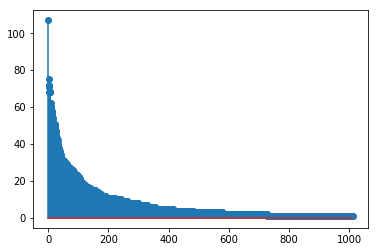

In [730]:
# print len(tree_count)
# plt.stem(tree_count)
# plt.show()

print len(samp_counts)
plt.stem(sorted(samp_counts, reverse=True))
plt.show()

In [5]:
kl_div_mean = np.mean(kl_div_mat, axis=0)

In [53]:
kl_div_mean[:,:,4]

array([[ 0.53983534,  0.33109597,  0.13385312,  0.08473684,  0.03558142],
       [ 1.16769969,  0.59875125,  0.29896699,  0.14101982,  0.06966361],
       [ 2.19968487,  1.10666181,  0.54572728,  0.27121188,  0.12936061],
       [ 3.79442897,  2.01701466,  1.0002488 ,  0.49706705,  0.26825701],
       [ 6.57580598,  3.45227792,  1.78905137,  0.92995965,  0.4519709 ],
       [ 9.78969968,  5.3866844 ,  3.00880108,  1.56736835,  0.78940912]])

In [54]:
kl_div_mean[:,:,5]

array([[  0.55044994,   0.33245489,   0.13520992,   0.0849722 ,
          0.03573956],
       [  1.17228976,   0.60355795,   0.30441703,   0.14460182,
          0.07138488],
       [  2.25065031,   1.1338661 ,   0.57466212,   0.28074971,
          0.13221289],
       [  3.96841567,   2.1694219 ,   1.08288202,   0.5350164 ,
          0.28191525],
       [  7.08871889,   3.88019234,   2.05435232,   1.06709574,   0.5193437 ],
       [ 11.08872189,   6.38918361,   3.76712494,   2.01022271,
          1.00495064]])

In [11]:
kl_div_std = np.std(kl_div_mat, axis=0)

In [24]:
kl_div_mean.min(), kl_div_mean.max()

(0.034699620755251993, 11.086815432242576)

In [56]:
kl_div_mean.min(), kl_div_mean.max()

(0.035581422818309158, 11.088721893749126)

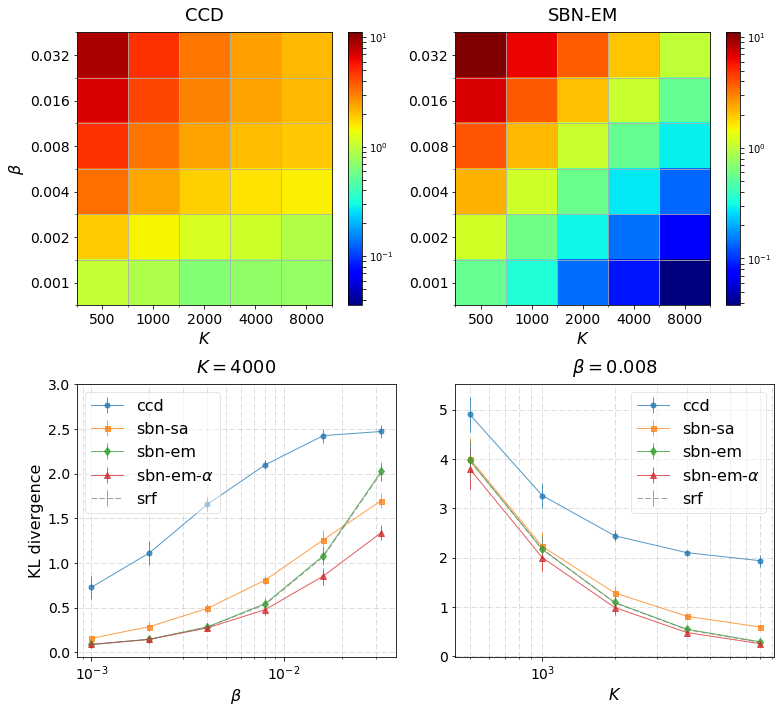

In [16]:
fig, axes = plt.subplots(2,2,figsize=(11,10))

ccd_kl_div = kl_div_mean[:,:,0]
im = axes[0,0].imshow(ccd_kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=kl_div_mean.min(), vmax=kl_div_mean.max()))
# cbar = plt.colorbar(im, ticks=np.logspace(np.log10(sbn_em_kl_div.min()),np.log10(sbn_em_kl_div.max()), 5), format='$%.2f$')
cbar = plt.colorbar(im, ax=axes[0,0])
axes[0,0].set_aspect('auto')
axes[0,0].set_xticks(range(5))
axes[0,0].set_yticks(range(6))
axes[0,0].set_xticks(np.arange(-0.5,5,1), minor=True)
axes[0,0].set_yticks(np.arange(-0.5,6,1), minor=True)
axes[0,0].set_xticklabels([500, 1000, 2000, 4000, 8000])
axes[0,0].set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
axes[0,0].grid(which='minor')
axes[0,0].tick_params(labelsize=14)
axes[0,0].set_xlabel(r'$K$', fontsize=16)
axes[0,0].set_ylabel(r'$\beta$', fontsize=16)
axes[0,0].set_title('CCD', fontsize=18, y=1.02)

sbn_em_kl_div = kl_div_mean[:,:,2]
im = axes[0,1].imshow(sbn_em_kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=sbn_em_kl_div.min(), vmax=sbn_em_kl_div.max()))
# cbar = plt.colorbar(im, ticks=np.logspace(np.log10(sbn_em_kl_div.min()),np.log10(sbn_em_kl_div.max()), 5), format='$%.2f$')
cbar = plt.colorbar(im, ax=axes[0,1])
axes[0,1].set_aspect('auto')
axes[0,1].set_xticks(range(5))
axes[0,1].set_yticks(range(6))
axes[0,1].set_xticks(np.arange(-0.5,5,1), minor=True)
axes[0,1].set_yticks(np.arange(-0.5,6,1), minor=True)
axes[0,1].set_xticklabels([500, 1000, 2000, 4000, 8000])
axes[0,1].set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
axes[0,1].grid(which='minor')
axes[0,1].tick_params(labelsize=14)
axes[0,1].set_xlabel(r'$K$', fontsize=16)
axes[0,1].set_ylabel(r'$\beta$', fontsize=16)
axes[0,1].set_title('SBN-EM', fontsize=18, y=1.02)


labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'sbn-em-'+r'$\alpha_1$',5:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'-*',5:'--'}
marksz={0:5,1:5,2:6,3:6,4:8,5:0}

beta_v = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
k = 3
# ax.set_yscale('log')
axes[1,0].set_xscale('log')
for i in [0,1,2,3,5]:
    axes[1,0].errorbar(beta_v, kl_div_mean[:,k,i], yerr=kl_div_std[:,k,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)

leg = axes[1,0].legend(loc='best',fontsize=16)
leg.get_frame().set_alpha(0.5)
axes[1,0].grid(which='both', linestyle='--', alpha=0.5)
axes[1,0].tick_params(labelsize=14)
axes[1,0].set_xlabel(r'$\beta$', fontsize=16)
axes[1,0].set_ylabel('KL divergence', fontsize=16)
axes[1,0].set_title(r'$K=4000$', y=1.02, fontsize=18)
axes[1,0].set_ylim(top=3)


K_v = [500, 1000, 2000, 4000, 8000]
l = 3
axes[1,1].set_xscale('log')

for i in [0,1,2,3,5]:
    axes[1,1].errorbar(K_v, kl_div_mean[l,:,i], yerr=kl_div_std[l,:,i], c=colors[i], label=labels[i], fmt=fmts[i], markersize=marksz[i], alpha=0.75, linewidth=1)

leg = axes[1,1].legend(loc='best',fontsize=16)
leg.get_frame().set_alpha(0.5)
axes[1,1].grid(which='both', linestyle='--', alpha=0.5)
axes[1,1].tick_params(labelsize=14)
axes[1,1].set_xlabel(r'$K$', fontsize=16)
axes[1,1].set_ylabel('KL divergence', fontsize=16)
axes[1,1].set_title(r'$\beta=0.008$', y=1.02, fontsize=18)

fig.tight_layout()

# plt.savefig('../figs/simulation-kl-divergence03-freq.pdf', transparent=True, dpi=1200, bbox_inches='tight')
plt.show()

# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)

In [34]:
import matplotlib.gridspec as gridspec

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'gray'] 

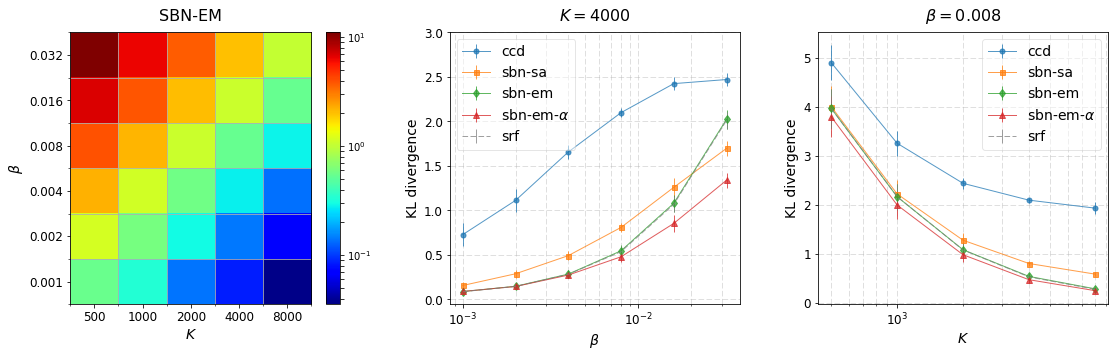

In [82]:
fig = plt.figure(figsize=(15.5, 5))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05, right=0.32)
ax1 = plt.subplot(gs1[0,0])
# sbn_em_kl_div = kl_div_mean[:,:,3]
sbn_em_kl_div = kl_div_mean[:,:,2]
im = ax1.imshow(sbn_em_kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=kl_div_mean.min(), vmax=kl_div_mean.max()))
# cbar = plt.colorbar(im, ticks=np.logspace(np.log10(sbn_em_kl_div.min()),np.log10(sbn_em_kl_div.max()), 5), format='$%.2f$')
cbar = plt.colorbar(im, ax=ax1)
ax1.set_aspect('auto')
ax1.set_xticks(range(5))
ax1.set_yticks(range(6))
ax1.set_xticks(np.arange(-0.5,5,1), minor=True)
ax1.set_yticks(np.arange(-0.5,6,1), minor=True)
ax1.set_xticklabels([500, 1000, 2000, 4000, 8000])
ax1.set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
ax1.grid(which='minor')
ax1.tick_params(labelsize=12)
ax1.set_xlabel(r'$K$', fontsize=14)
ax1.set_ylabel(r'$\beta$', fontsize=14)
ax1.set_title('SBN-EM', fontsize=16, y=1.02)

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.39, right=0.98, wspace=0.27)
ax2 = plt.subplot(gs2[0,0])

labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'sbn-em-'+r'$\alpha_1$',5:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'-*',5:'--'}
marksz={0:5,1:5,2:6,3:6,4:8,5:0}

beta_v = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
k = 3
# ax.set_yscale('log')
ax2.set_xscale('log')
for i in [0,1,2,3,5]:
    ax2.errorbar(beta_v, kl_div_mean[:,k,i], yerr=kl_div_std[:,k,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax2.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax2.grid(which='both', linestyle='--', alpha=0.5)
ax2.tick_params(labelsize=12)
ax2.set_xlabel(r'$\beta$', fontsize=14)
ax2.set_ylabel('KL divergence', fontsize=14)
ax2.set_title(r'$K=4000$', y=1.02, fontsize=16)
ax2.set_ylim(top=3)

ax3 = plt.subplot(gs2[0,1])
K_v = [500, 1000, 2000, 4000, 8000]
l = 3
ax3.set_xscale('log')

for i in [0,1,2,3,5]:
    ax3.errorbar(K_v, kl_div_mean[l,:,i], yerr=kl_div_std[l,:,i], c=colors[i], label=labels[i], fmt=fmts[i], markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_ylabel('KL divergence', fontsize=14)
ax3.set_title(r'$\beta=0.008$', y=1.02, fontsize=16)

plt.savefig('../figs/simulation-kl-divergence02-freq.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [204]:
kl_div_mean.min(), kl_div_mean.max()

(0.040877184128566446, 10.796468181457083)

In [37]:
kl_div_mean.min(), kl_div_mean.max()

(0.034699620755251993, 11.086815432242576)

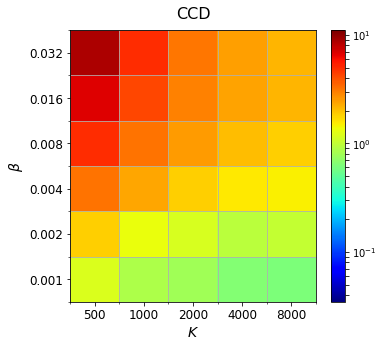

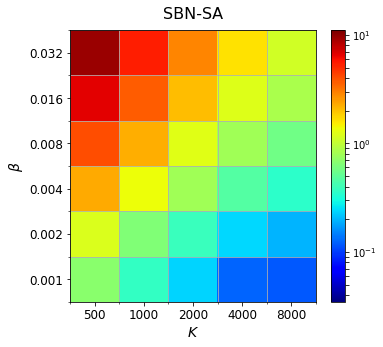

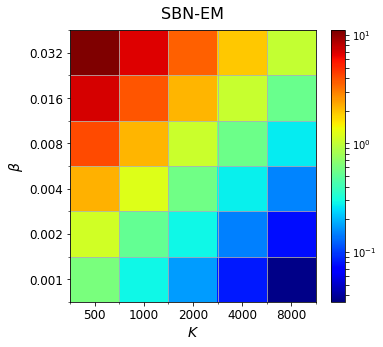

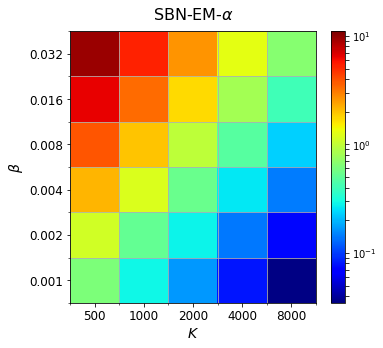

In [38]:
# methods = ['CCD', 'SBN-SA', 'SBN-SA-'+r'$\alpha$', 'SBN-EM', 'SBN-EM-'+r'$\alpha_0$', 'SBN-EM-'+r'$\alpha_1$']
methods = ['CCD', 'SBN-SA', 'SBN-EM', 'SBN-EM-'+r'$\alpha$']

for i, method in enumerate(methods):
    fig, ax = plt.subplots(figsize=(5.5,5))
    kl_div = kl_div_mean[:,:,i]
    im = ax.imshow(kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=kl_div_mean.min(), vmax=kl_div_mean.max()))
    # cbar = plt.colorbar(im, ticks=np.logspace(np.log10(sbn_em_kl_div.min()),np.log10(sbn_em_kl_div.max()), 5), format='$%.2f$')
    cbar = plt.colorbar(im)
    ax.set_aspect('auto')
    ax.set_xticks(range(5))
    ax.set_yticks(range(6))
    ax.set_xticks(np.arange(-0.5,5,1), minor=True)
    ax.set_yticks(np.arange(-0.5,6,1), minor=True)
    ax.set_xticklabels([500, 1000, 2000, 4000, 8000])
    ax.set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
    ax.grid(which='minor')
    ax.tick_params(labelsize=12)
    ax.set_xlabel(r'$K$', fontsize=14)
    ax.set_ylabel(r'$\beta$', fontsize=14)
    ax.set_title(method, fontsize=16, y=1.02)
    
    plt.savefig('../figs/simulation-kl-divergence-'+method+'-rescale.pdf', transparent=True, dpi=1200, bbox_inches='tight')
    
    plt.show()

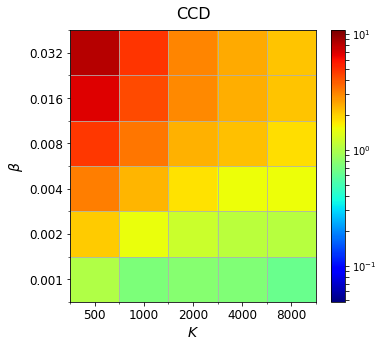

In [80]:
fig, ax = plt.subplots(figsize=(5.5,5))
ccd_kl_div = kl_div_mean[:,:,0]
im = ax.imshow(ccd_kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=sbn_em_kl_div.min(), vmax=sbn_em_kl_div.max()))
# cbar = plt.colorbar(im, ticks=np.logspace(np.log10(sbn_em_kl_div.min()),np.log10(sbn_em_kl_div.max()), 5), format='$%.2f$')
cbar = plt.colorbar(im)
ax.set_aspect('auto')
ax.set_xticks(range(5))
ax.set_yticks(range(6))
ax.set_xticks(np.arange(-0.5,5,1), minor=True)
ax.set_yticks(np.arange(-0.5,6,1), minor=True)
ax.set_xticklabels([500, 1000, 2000, 4000, 8000])
ax.set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
ax.grid(which='minor')
ax.tick_params(labelsize=12)
ax.set_xlabel(r'$K$', fontsize=14)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_title('CCD', fontsize=16, y=1.02)
plt.show()

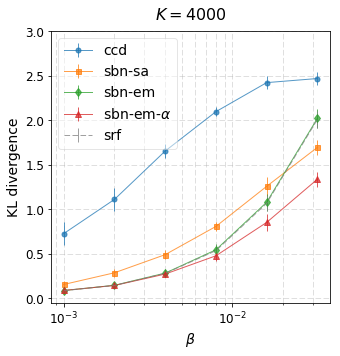

In [86]:
beta_v = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
k = 3
fig, ax = plt.subplots(figsize=(5,5))
# ax.set_yscale('log')
ax.set_xscale('log')
# labels={0:'ccd',1:'sbn-sa',3:'sbn-em',4:'sbn-em-'+r'$\alpha_0$',5:'sbn-em-'+r'$\alpha_1$'}
# fmts={0:'-o',1:'-s',3:'-d',4:'-^',5:'-*'}
# marksz={0:5,1:5,3:6,4:6,5:8}
labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'sbn-em-'+r'$\alpha_1$',5:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'-*',5:'--'}
marksz={0:5,1:5,2:6,3:6,4:8,5:0}

for i in [0,1,2,3,5]:
    ax.errorbar(beta_v, kl_div_mean[:,k,i], yerr=kl_div_std[:,k,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax.grid(which='both', linestyle='--', alpha=0.5)
ax.tick_params(labelsize=12)
ax.set_xlabel(r'$\beta$', fontsize=14)
ax.set_ylabel('KL divergence', fontsize=14)
ax.set_title(r'$K=4000$', y=1.02, fontsize=16)
ax.set_ylim(top=3)

plt.savefig('../figs/simulation-kl-divergence-K4000-freq-gray.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

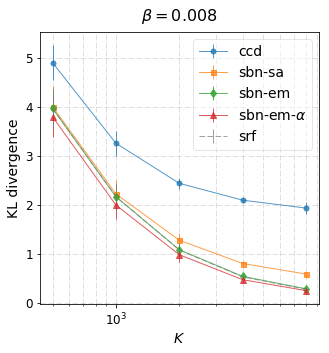

In [85]:
K_v = [500, 1000, 2000, 4000, 8000]
l = 3
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xscale('log')
# labels={0:'ccd',1:'sbn-sa',3:'sbn-em',4:'sbn-em-'+r'$\alpha_0$',5:'sbn-em-'+r'$\alpha_1$'}
# fmts={0:'-o',1:'-s',3:'-d',4:'-^',5:'-*'}
# marksz={0:5,1:5,3:6,4:6,5:8}
labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'sbn-em-'+r'$\alpha_1$',5:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'-*',5:'--'}
marksz={0:5,1:5,2:6,3:6,4:8,5:0}

for i in [0,1,2,3,5]:
    ax.errorbar(K_v, kl_div_mean[l,:,i], yerr=kl_div_std[l,:,i], c=colors[i], label=labels[i], fmt=fmts[i], markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax.grid(which='both', linestyle='--', alpha=0.5)
ax.tick_params(labelsize=12)
ax.set_xlabel(r'$K$', fontsize=14)
ax.set_ylabel('KL divergence', fontsize=14)
ax.set_title(r'$\beta=0.008$', y=1.02, fontsize=16)

# plt.savefig('../figs/simulation-kl-divergence-beta8e-03-freq-gray.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [48]:
np.arange(-0.5,5,1)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

In [16]:
kl_div_mean = np.mean(kl_div_mat, axis=0)

In [19]:
kl_div_std = np.std(kl_div_mat, axis=0)

In [20]:
kl_div_std[:,:,0]

array([[ 0.17200612,  0.17032555,  0.14335754,  0.13928708,  0.20988222],
       [ 0.43574548,  0.1893685 ,  0.19460693,  0.15541485,  0.20655012],
       [ 0.25576972,  0.13988326,  0.12521233,  0.07928026,  0.08101633],
       [ 0.27280697,  0.17635177,  0.09464012,  0.06734309,  0.09660677],
       [ 0.40401181,  0.19071176,  0.10565955,  0.06200303,  0.05748856],
       [ 0.38109692,  0.19071587,  0.11439391,  0.04323591,  0.03402086]])

In [17]:
kl_div_mean[:,:,0]

array([[ 1.02200093,  0.73470779,  0.78671587,  0.74206798,  0.65169889],
       [ 2.06709976,  1.49522983,  1.20371132,  1.1014538 ,  1.06520972],
       [ 3.17542582,  2.34809989,  1.80521285,  1.5473399 ,  1.52288242],
       [ 4.83868839,  3.36040575,  2.39764451,  2.17527865,  1.85968243],
       [ 6.92856307,  4.32065403,  3.03384651,  2.42165527,  2.13490369],
       [ 8.27913041,  4.88720309,  3.1001778 ,  2.46721687,  2.14772067]])

In [30]:
kl_div_std[:,:,3]

array([[ 0.1437257 ,  0.07174743,  0.03708795,  0.03387587,  0.02191759],
       [ 0.33992244,  0.1610303 ,  0.04918773,  0.0211141 ,  0.01017815],
       [ 0.2971782 ,  0.15184235,  0.05441175,  0.04747504,  0.02102181],
       [ 0.32353172,  0.24293072,  0.09132283,  0.0624274 ,  0.02915288],
       [ 0.38782853,  0.27329393,  0.10220467,  0.08021598,  0.03136739],
       [ 0.31601998,  0.31883732,  0.14580168,  0.07612058,  0.04267184]])

In [31]:
kl_div_mean[:,:,3]

array([[  0.52772735,   0.2754172 ,   0.14479369,   0.09195506,
          0.04868031],
       [  1.27664196,   0.71568833,   0.26851588,   0.14615537,
          0.07346735],
       [  2.1477816 ,   1.16435767,   0.5314516 ,   0.3016384 ,
          0.14343454],
       [  4.13127913,   2.24997719,   1.02754803,   0.5904723 ,
          0.28201381],
       [  6.96955175,   3.97479269,   2.13024999,   1.06367274,
          0.56166264],
       [ 10.79646818,   6.55427195,   3.69015986,   1.93612049,
          1.00017707]])

In [722]:
model = SBN(taxa, emp_tree_freq)

In [723]:
model.bn_train_count(tree_count_dict, tree_id)

In [726]:
model.kl_div()

defaultdict(float, {'bn': 0.4415046193661154, 'ccd': 0.90478599279609107})

In [602]:
ccd_est_prob = [model.ccd_estimate(tree_id[key][0]) for key in tree_id]

In [603]:
bn_est_prob = [model.bn_estimate(tree_id[key][0]) for key in tree_id]

In [604]:
sum(ccd_est_prob), max(ccd_est_prob)

(0.3611055730911385, 0.00069062834767832731)

In [605]:
sum(bn_est_prob), max(bn_est_prob)

(0.58945635000854235, 0.0025228772674288579)

In [481]:
ccd_est_prob_full = [model.ccd_estimate(tree) for tree in all_tree]

In [482]:
bn_est_prob_full = [model.bn_estimate(tree) for tree in all_tree]

In [483]:
sum(ccd_est_prob_full), sum(bn_est_prob_full)

(1.0000000000000002, 0.99999999999999978)

In [606]:
tree_wts = [tree_count_dict[key]/10000.0 for key in tree_id]

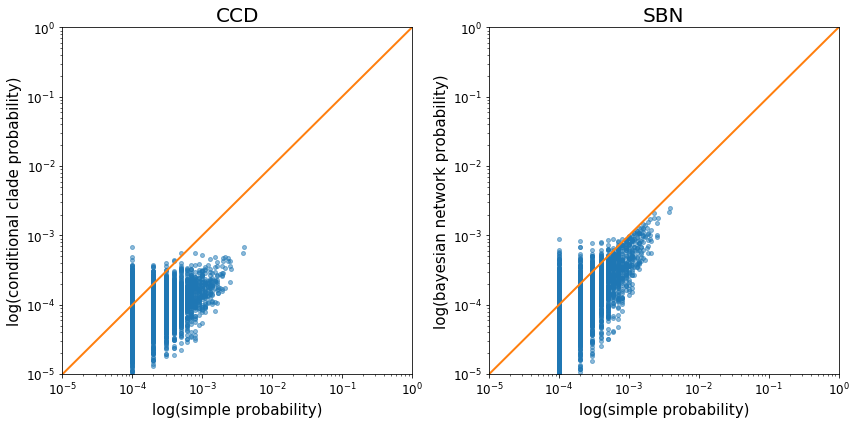

In [607]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(tree_wts, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-5,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-5,1],[1e-5,1],linewidth=2)
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(simple probability)',fontsize=15)
ax1.set_ylabel('log(conditional clade probability)',fontsize=15)
ax1.tick_params(labelsize=12)
# ax.axis('equal')

ax2.plot(tree_wts, bn_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-5,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-5,1],[1e-5,1],linewidth=2)
ax2.set_title('SBN', fontsize=20)
ax2.set_xlabel('log(simple probability)',fontsize=15)
ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()

# plt.savefig('figs/cbn-vs-ccd-simu.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [682]:
logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=40, monitor=True, MAP=False)

Iter: 1: current per tree log-likelihood -6.921602
Iter: 2: current per tree log-likelihood -6.887559
Iter: 3: current per tree log-likelihood -6.867855
Iter: 4: current per tree log-likelihood -6.835716
Iter: 5: current per tree log-likelihood -6.771684
Iter: 6: current per tree log-likelihood -6.667984
Iter: 7: current per tree log-likelihood -6.554095
Iter: 8: current per tree log-likelihood -6.464764
Iter: 9: current per tree log-likelihood -6.405521
Iter: 10: current per tree log-likelihood -6.365988
Iter: 11: current per tree log-likelihood -6.339861
Iter: 12: current per tree log-likelihood -6.322170
Iter: 13: current per tree log-likelihood -6.310027
Iter: 14: current per tree log-likelihood -6.301641
Iter: 15: current per tree log-likelihood -6.295503
Iter: 16: current per tree log-likelihood -6.291039
Iter: 17: current per tree log-likelihood -6.287909
Iter: 18: current per tree log-likelihood -6.285448
Iter: 19: current per tree log-likelihood -6.283195
Iter: 20: current per

In [683]:
model.kl_div(method='bn')

defaultdict(float, {'bn': 1.0326046511064764})

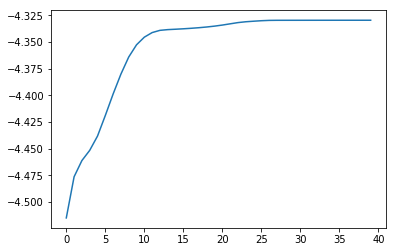

In [488]:
plt.plot(logp)
plt.show()

In [611]:
bn_est_prob = [model.bn_estimate(tree_id[key][0]) for key in tree_id]

In [610]:
sum(bn_est_prob), max(bn_est_prob)

(0.58945635000854235, 0.0025228772674288579)

In [612]:
sum(bn_est_prob), max(bn_est_prob)

(0.89647983426453193, 0.0038956593593711718)

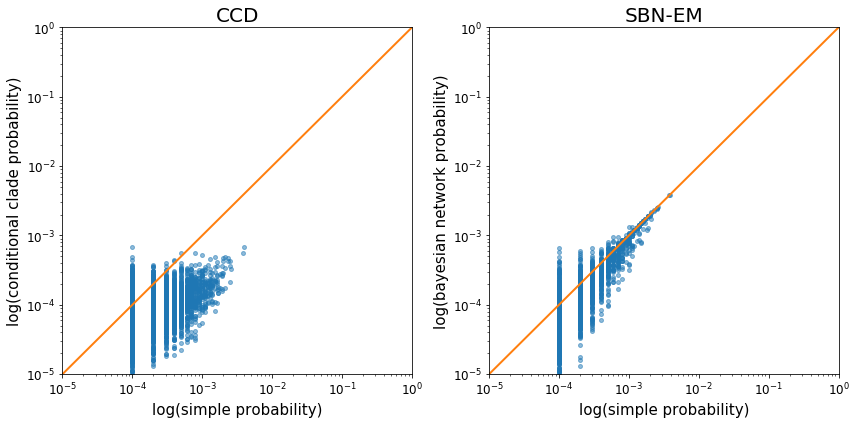

In [613]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(tree_wts, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-5,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-5,1],[1e-5,1],linewidth=2)
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(simple probability)',fontsize=15)
ax1.set_ylabel('log(conditional clade probability)',fontsize=15)
ax1.tick_params(labelsize=12)
# ax.axis('equal')

ax2.plot(tree_wts, bn_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-5,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-5,1],[1e-5,1],linewidth=2)
ax2.set_title('SBN-EM', fontsize=20)
ax2.set_xlabel('log(simple probability)',fontsize=15)
ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()

# plt.savefig('figs/cbn-vs-ccd-simu.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [409]:
bn_est_prob_full = [model.bn_estimate(tree) for tree in all_tree]

In [410]:
sum(bn_est_prob_full)

1.0

In [687]:
model = SBN(taxa, emp_tree_freq, alpha=0.5)

In [688]:
logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=100, monitor=True, MAP=True)

Iter: 1: current per tree log-likelihood -13.114990
Iter: 2: current per tree log-likelihood -12.916170
Iter: 3: current per tree log-likelihood -12.809149
Iter: 4: current per tree log-likelihood -12.724384
Iter: 5: current per tree log-likelihood -12.653566
Iter: 6: current per tree log-likelihood -12.593427
Iter: 7: current per tree log-likelihood -12.542774
Iter: 8: current per tree log-likelihood -12.502016
Iter: 9: current per tree log-likelihood -12.472126
Iter: 10: current per tree log-likelihood -12.450814
Iter: 11: current per tree log-likelihood -12.434881
Iter: 12: current per tree log-likelihood -12.422448
Iter: 13: current per tree log-likelihood -12.412342
Iter: 14: current per tree log-likelihood -12.404649
Iter: 15: current per tree log-likelihood -12.399114
Iter: 16: current per tree log-likelihood -12.394764
Iter: 17: current per tree log-likelihood -12.391130
Iter: 18: current per tree log-likelihood -12.387920
Iter: 19: current per tree log-likelihood -12.384904
It

In [667]:
bn_est_prob = [model.bn_estimate(tree_id[key][0]) for key in tree_id]

In [668]:
sum(bn_est_prob), max(bn_est_prob)

(0.95908197915531335, 0.022615016968832544)

In [666]:
sum(bn_est_prob), max(bn_est_prob)

(0.78873249065117668, 0.0037598470078908891)

ValueError: x and y must have same first dimension, but have shapes (3091,) and (1015,)

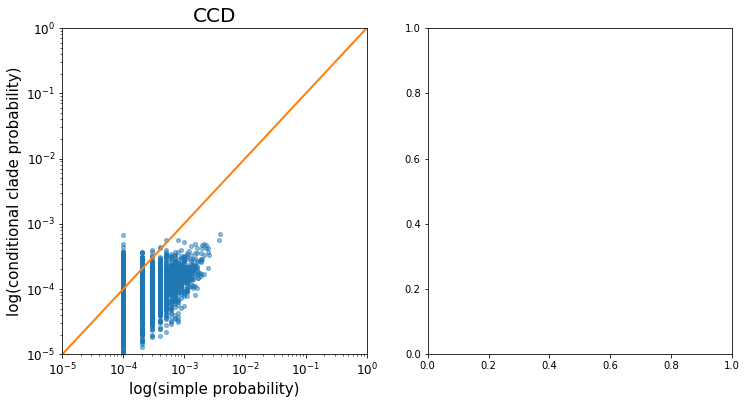

In [669]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(tree_wts, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-5,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-5,1],[1e-5,1],linewidth=2)
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(simple probability)',fontsize=15)
ax1.set_ylabel('log(conditional clade probability)',fontsize=15)
ax1.tick_params(labelsize=12)
# ax.axis('equal')

ax2.plot(tree_wts, bn_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-5,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-5,1],[1e-5,1],linewidth=2)
ax2.set_title('SBN-EM', fontsize=20)
ax2.set_xlabel('log(simple probability)',fontsize=15)
ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()

# plt.savefig('figs/cbn-vs-ccd-simu.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [689]:
model.kl_div(method='bn')

defaultdict(float, {'bn': 0.69743375325302992})

In [528]:
bn_est_prob_full = [model.bn_estimate(tree) for tree in all_tree]

In [529]:
sum(bn_est_prob_full)

1.0000000000000002

In [530]:
sorted(model.clade_dict.items(), key=lambda x:x[1], reverse=True)

[('01011111', 0.089751505590283429),
 ('00000110', 0.07439643892534914),
 ('01001100', 0.035407342402443608),
 ('01100101', 0.030521382048705352),
 ('01111011', 0.029968345356689831),
 ('00100100', 0.028406444985150596),
 ('00001001', 0.023419944607456784),
 ('00000011', 0.021091713383758728),
 ('00110111', 0.020134421175618176),
 ('00110000', 0.019772021674281735),
 ('00111011', 0.018310648790458656),
 ('01100010', 0.015647120192020504),
 ('00011001', 0.015268415218716776),
 ('01111010', 0.014962733015022198),
 ('00111101', 0.014215756129912181),
 ('00011000', 0.013610954802830175),
 ('01011110', 0.013566736829125967),
 ('00110110', 0.012793072588684487),
 ('01100111', 0.012598206852599556),
 ('00010001', 0.01249981625844534),
 ('00000101', 0.012177794380510502),
 ('01110100', 0.012170159421107309),
 ('00011010', 0.011845089149876857),
 ('00010111', 0.011245732397060299),
 ('01101001', 0.011133417767657512),
 ('00101000', 0.010898713257782177),
 ('01111101', 0.010343240688824126),
 ('